<a href="https://colab.research.google.com/github/FranciscoGlez25/CNN-TC/blob/main/GridSearch_ResNet50_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Configuración del Entorno y Dispositivo de Entrenamiento**

Este bloque de código se encarga de configurar el entorno de trabajo y el dispositivo de entrenamiento.

1. **Librerías Importadas:**
    - Se importan las bibliotecas y módulos necesarios, incluyendo PyTorch, torchvision, y otras utilidades para manipulación de datos y visualización.

2. **Verificación de Disponibilidad de GPU:**
    - Se utiliza `torch.cuda.is_available()` para determinar si una GPU (unidad de procesamiento gráfico) está disponible. Si es así, el código configura el dispositivo de entrenamiento como la GPU (`"cuda:0"`), de lo contrario, utiliza la CPU (`"cpu"`).

3. **Mover el Modelo a Dispositivo:**
    - El modelo se mueve al dispositivo de entrenamiento utilizando la función `to(device)`. Esto es crucial cuando se trabaja con GPUs, ya que permite realizar cálculos en paralelo, acelerando el proceso de entrenamiento.

Este bloque establece las bases para el entrenamiento de modelos de aprendizaje profundo y garantiza que los recursos de hardware, como las GPU, se utilicen eficientemente para acelerar los cálculos. La elección de la GPU como dispositivo de entrenamiento mejora significativamente el rendimiento al aprovechar la capacidad de procesamiento masivo de las unidades gráficas.

In [ ]:
import torch
import torchvision
from torchvision.transforms import v2
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import pandas as pd
from PIL import Image
import os
from tqdm.notebook import tqdm
import matplotlib.image as img
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    # Mover modelo a dispositivo de entrenamient

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

# **Definición de Transformaciones de Imágenes**

En este bloque de código, se definen las transformaciones para el preprocesamiento de imágenes.

1. **Transformaciones para el Conjunto de Entrenamiento:**
    - Se define un conjunto de transformaciones (`transform_train`) que se aplicarán a las imágenes durante el entrenamiento del modelo. Estas transformaciones incluyen la conversión a tensores, el redimensionamiento a una dimensión específica (224x224), y la normalización. También se incluyen transformaciones opcionales, como la inversión horizontal y la equalización aleatoria, aunque están actualmente comentadas.

2. **Transformaciones para el Conjunto de Prueba:**
    - Se define otro conjunto de transformaciones (`transform_test`) destinado a las imágenes del conjunto de prueba. Al igual que en el conjunto de entrenamiento, se realiza la conversión a tensores, el redimensionamiento y la normalización. Aquí también se pueden aplicar transformaciones adicionales, pero en este caso, la inversión horizontal está comentada.

Estas transformaciones son esenciales para preparar adecuadamente las imágenes antes de alimentarlas al modelo de aprendizaje profundo. El redimensionamiento asegura que todas las imágenes tengan el mismo tamaño, la conversión a tensores es necesaria para el procesamiento en PyTorch, y la normalización ayuda a estandarizar los valores de píxeles, mejorando así el rendimiento del modelo durante el entrenamiento y la evaluación.

In [ ]:
# Definir transformaciones para el preprocesamiento de las imágenes
transform_train = v2.Compose([
                    v2.ToTensor(),
                    v2.Resize(size = (224, 224)),
                    #v2.RandomHorizontalFlip(p=0.5),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

transform_test = v2.Compose([v2.ToTensor(),
                    v2.Resize(size = (224, 224)),
                    #v2.RandomEqualize(p = 1),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


# **Definición del Conjunto de Datos Personalizado**

En este bloque de código, se define un conjunto de datos personalizado denominado `CustomDataset`.

1. **Inicialización:**
   - Se utiliza el método `__init__` para inicializar la instancia del conjunto de datos. Este método recibe tres parámetros: `csv_file` (ruta al archivo CSV que contiene las anotaciones), `root_dir` (directorio raíz que contiene las imágenes), y `transform` (transformaciones a aplicar a las imágenes).
   - Se lee el archivo CSV con las anotaciones usando Pandas y se almacena en el atributo `annotations`.
   - Se almacenan las rutas de las imágenes y las transformaciones en los atributos `root_dir` y `transform`, respectivamente.
   - Se calcula el número de clases únicas en el conjunto de datos y se almacena en `num_classes`.

2. **Longitud del Conjunto de Datos:**
   - Se utiliza el método `__len__` para obtener la longitud del conjunto de datos, que corresponde al número total de muestras en el conjunto.

3. **Obtención de Elementos:**
   - Se utiliza el método `__getitem__` para obtener un elemento del conjunto de datos en función de un índice dado.
   - Se construye la ruta de la imagen utilizando la información del archivo CSV y el directorio raíz.
   - La imagen se carga utilizando la biblioteca PIL y se convierte a modo RGB.
   - Se obtiene la etiqueta correspondiente desde el archivo CSV.
   - Si se proporciona una transformación, se aplica a la imagen.
   - La función retorna la imagen y su etiqueta asociada.

Este conjunto de datos personalizado es esencial para cargar las imágenes y las etiquetas desde un archivo CSV, proporcionando una interfaz compatible con PyTorch para que el modelo pueda entrenarse y evaluarse de manera efectiva.

In [ ]:
# Definir dataset personalizado para cargar imágenes y clases desde archivos CSV
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        # Obtener el número de clases desde el conjunto de datos
        self.num_classes = len(self.annotations['Egreso'].unique())  # Suponiendo que la columna de etiquetas se llama 'label'

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.annotations.iloc[index, 3]

        if self.transform:
            image = self.transform(image)

        return image, label

# **Creación del Conjunto de Datos de Entrenamiento**

En este bloque de código, se crea el conjunto de datos de entrenamiento (`train_dataset`) utilizando la clase `CustomDataset` definida previamente.

1. **Importación de Librerías:**
   - Se importan las clases `DataLoader` y `random_split` de la biblioteca PyTorch.

2. **Definición del Conjunto de Datos de Entrenamiento:**
   - Se instancia la clase `CustomDataset`, proporcionando la ruta al archivo CSV (`'ruta_archivo_csv'`), el directorio que contiene las imágenes (`'ruta_carpeta_imagenes'`), y las transformaciones específicas para el entrenamiento (`transform=transform_train`).
   - La variable `train_dataset` representa el conjunto de datos de entrenamiento.

3. **Obtención de la Cantidad Total de Imágenes en el Conjunto de Datos de Entrenamiento:**
   - La variable `total_train` se calcula utilizando la función `len(train_dataset)`, representando la cantidad total de imágenes en el conjunto de datos de entrenamiento.

4. **Impresión del Resultado:**
   - Se imprime la cantidad total de imágenes en el conjunto de datos de entrenamiento mediante la función `print()`.

Este bloque es esencial para configurar el conjunto de datos de entrenamiento que se utilizará durante el entrenamiento del modelo. La cantidad total de imágenes proporciona información sobre el tamaño del conjunto de datos de entrenamiento.

In [ ]:
from torch.utils.data import DataLoader, random_split

# Define el conjunto de datos completo
train_dataset = CustomDataset('ruta_archivo_csv', 'ruta_carpeta_imagenes', transform=transform_train)

total_train = len(train_dataset)
print(f'Cantidad total de imágenes en Train Dataset: {total_train}')

Cantidad total de imágenes en Train Dataset: 963


# **Número de Clases en el Conjunto de Datos de Entrenamiento**

En este bloque de código, se obtiene el número de clases presente en el conjunto de datos de entrenamiento (`train_dataset`).

1. **Obtención del Número de Clases:**
   - Se accede a la propiedad `num_classes` de `train_dataset` para obtener el número de clases presentes en el conjunto de datos de entrenamiento.
   - La variable `num_classes` almacena este valor.

2. **Impresión del Resultado:**
   - Se utiliza la función `print()` para mostrar en la consola el número de clases obtenidas en el conjunto de datos de entrenamiento.

Este bloque es fundamental para conocer la cantidad de clases únicas presentes en el conjunto de datos de entrenamiento. La información sobre el número de clases es crucial para configurar la capa de salida del modelo de clasificación y garantizar la correspondencia adecuada entre las predicciones y las etiquetas reales durante el entrenamiento.

In [ ]:
num_classes = train_dataset.num_classes
print("Clases obtenidas en el conjunto Train Dataset:", num_classes)

Clases obtenidas en el conjunto Train Dataset: 2


# **División del Conjunto de Datos en Entrenamiento y Validación**

En este bloque de código, se realiza la división del conjunto de datos en conjuntos de entrenamiento y validación, y se definen los DataLoaders correspondientes.

1. **Obtención del Número Total de Muestras:**
   - La variable `total_samples` almacena el número total de muestras en el conjunto de entrenamiento, obtenido mediante la función `len(train_dataset)`.

2. **Cálculo del Tamaño del Conjunto de Validación:**
   - Se define la proporción de muestras para el conjunto de validación (`validation_split`).
   - Se calcula el tamaño del conjunto de validación (`validation_size`) como el 20% del total de muestras.

3. **Cálculo del Tamaño del Conjunto de Entrenamiento:**
   - Se calcula el tamaño del conjunto de entrenamiento (`train_size`) restando el tamaño del conjunto de validación al total de muestras.

4. **División del Conjunto de Entrenamiento:**
   - Se utiliza la función `random_split` de PyTorch para dividir el conjunto de entrenamiento en conjuntos de entrenamiento y validación según los tamaños calculados anteriormente.
   - Se actualizan las variables `train_dataset` y `validation_dataset` con las divisiones correspondientes.

5. **Definición de DataLoaders:**
   - Se definen los DataLoaders `train_loader` y `val_loader` utilizando los conjuntos de entrenamiento y validación, respectivamente.
   - Se especifica un tamaño de lote de 64 y se activa la mezcla aleatoria de muestras (`shuffle=True`) para el DataLoader de entrenamiento.

Este bloque es esencial para preparar los conjuntos de datos necesarios para el entrenamiento y la evaluación del modelo. La división en conjuntos de entrenamiento y validación es crucial para evaluar el rendimiento del modelo en datos no vistos durante el entrenamiento.

In [ ]:
# Obtén el número total de muestras en el conjunto de entrenamiento
total_samples = len(train_dataset)

# Calcula el número de muestras para el conjunto de validación (por ejemplo, el 20%)
validation_split = 0.2
validation_size = int(validation_split * total_samples)

# Calcula el tamaño del conjunto de entrenamiento
train_size = total_samples - validation_size

# Divide el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

# Define los DataLoaders para entrenamiento y validación
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=64, shuffle=True)

# **Obtención de la Cantidad Total de Imágenes en DataLoaders**

En este bloque de código, se obtiene la cantidad total de imágenes en los DataLoaders de entrenamiento y validación, y se imprime esta información.

1. **Obtención del Número Total de Imágenes en DataLoaders:**
   - La variable `total_images_train` almacena la cantidad total de imágenes en el DataLoader de entrenamiento (`train_loader`) mediante la propiedad `len(train_loader.dataset)`.
   - De manera similar, la variable `total_images_validation` almacena la cantidad total de imágenes en el DataLoader de validación (`val_loader`) mediante `len(val_loader.dataset)`.

2. **Impresión de la Información:**
   - Se imprime la cantidad total de imágenes en el conjunto de entrenamiento después de realizar la división (`total_images_train`).
   - Se imprime la cantidad total de imágenes en el conjunto de validación (`total_images_validation`).

Estos valores son útiles para verificar y validar la correcta configuración de los DataLoaders y para tener una visión general de la cantidad de datos disponibles para el entrenamiento y la evaluación del modelo.

In [ ]:
# Obtén la cantidad total de imágenes en train_loader y validation_loader
total_images_train = len(train_loader.dataset)
total_images_validation = len(val_loader.dataset)

# Imprime la cantidad total de imágenes
print(f'Cantidad total de imágenes en Train Dataset despues de realizar split: {total_images_train}')
print(f'Cantidad total de imágenes en Validation Dataset: {total_images_validation}')

Cantidad total de imágenes en Train Dataset despues de realizar split: 771
Cantidad total de imágenes en Validation Dataset: 192


# **Definición de Search Grid**

En este bloque de código, se definen los hiperparámetros que serán ajustados durante el proceso de búsqueda de hiperparámetros.

1. **Hiperparámetros a Ajustar:**
   - Se crea un diccionario denominado `param_grid` que contiene los hiperparámetros que se ajustarán.
   - Los hiperparámetros incluidos son:
      - `learning_rate`: Una lista de tasas de aprendizaje para evaluar, como `[0.00001, 0.0001, 0.001]`.
      - `optimizer`: Una lista de optimizadores para probar, como `['SGD', 'Adam', 'RMSprop']`.

Estos hiperparámetros son esenciales para el entrenamiento del modelo y su ajuste puede influir significativamente en el rendimiento del modelo. La búsqueda de hiperparámetros implica evaluar el rendimiento del modelo para combinaciones específicas de estos valores con el objetivo de encontrar la configuración óptima.

In [ ]:
# Hiperparámetros a ajustar
param_grid = {
    'learning_rate': [0.00001, 0.0001, 0.001],
    'optimizer': ['SGD', 'Adam', 'RMSprop']
}


# **Búsqueda de Hiperparámetros y Entrenamiento del Modelo**

En este bloque de código, se lleva a cabo un proceso de búsqueda de hiperparámetros y entrenamiento del modelo.

1. **Definición de Hiperparámetros y Variables:**
   - El diccionario `param_grid` contiene las combinaciones de hiperparámetros a evaluar, incluyendo tasas de aprendizaje y optimizadores.
   - El número de épocas (`epochs`) se establece en 100.
   - `best_val_loss` se inicializa como infinito para rastrear la mejor pérdida de validación.
   - `best_hyperparameters` almacena los mejores hiperparámetros encontrados durante la búsqueda.
   - `best_model` es una variable que almacenará el modelo con el mejor rendimiento.

2. **Bucle Principal de Búsqueda de Hiperparámetros:**
   - Se itera a través de todas las combinaciones de hiperparámetros definidas en `param_grid`.
   - Por cada combinación, se crea un modelo ResNet-50 preentrenado y se ajusta para las dos clases específicas.
   - Se utilizan las tasas de aprendizaje y optimizadores especificados en la iteración actual.
   - Se registra la pérdida de validación mínima alcanzada durante el entrenamiento.

3. **Visualización de Resultados:**
   - Se generan gráficos que muestran la pérdida y la precisión en función del número de épocas para el conjunto de entrenamiento y validación.
   - Cada gráfico está etiquetado con información sobre las tasas de aprendizaje y los optimizadores utilizados en esa iteración.
   - Los gráficos se guardan como archivos PDF.

4. **Selección de Mejores Hiperparámetros:**
   - Después de completar la búsqueda, se identifican los mejores hiperparámetros según la mínima pérdida de validación.

Este bloque de código realiza una búsqueda exhaustiva de hiperparámetros, evaluando diferentes combinaciones para encontrar aquella que resulta en el mejor rendimiento en el conjunto de validación.

Entrenando con learning_rate=0.00001, epochs=100, optimizer=SGD


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 195MB/s]


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.562905317769131
Epoch 1 Training Loss = 0.68641314818856
Epoch 1 Validation Accuracy = 0.5625
Epoch 1 Validation Loss = 0.683346152305603
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.582360570687419
Epoch 2 Training Loss = 0.6840023155651513
Epoch 2 Validation Accuracy = 0.5520833333333334
Epoch 2 Validation Loss = 0.6881187558174133
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.603112840466926
Epoch 3 Training Loss = 0.6797095990984975
Epoch 3 Validation Accuracy = 0.515625
Epoch 3 Validation Loss = 0.6935046315193176
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.5992217898832685
Epoch 4 Training Loss = 0.6756050609119826
Epoch 4 Validation Accuracy = 0.4895833333333333
Epoch 4 Validation Loss = 0.7026873032251993
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.6005188067444877
Epoch 5 Training Loss = 0.6722986422933338
Epoch 5 Validation Accuracy = 0.4895833333333333
Epoch 5 Validation Loss = 0.7026811242103577
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.5992217898832685
Epoch 6 Training Loss = 0.669812677435374
Epoch 6 Validation Accuracy = 0.53125
Epoch 6 Validation Loss = 0.6960836251576742
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.5966277561608301
Epoch 7 Training Loss = 0.6682677535695325
Epoch 7 Validation Accuracy = 0.5104166666666666
Epoch 7 Validation Loss = 0.6986504395802816
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.5914396887159533
Epoch 8 Training Loss = 0.6675366983494097
Epoch 8 Validation Accuracy = 0.5208333333333334
Epoch 8 Validation Loss = 0.6975886623064677
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.6095979247730221
Epoch 9 Training Loss = 0.6648192956908359
Epoch 9 Validation Accuracy = 0.5208333333333334
Epoch 9 Validation Loss = 0.6954430937767029
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.6005188067444877
Epoch 10 Training Loss = 0.6633319616626981
Epoch 10 Validation Accuracy = 0.5416666666666666
Epoch 10 Validation Loss = 0.6917399764060974
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.6057068741893644
Epoch 11 Training Loss = 0.6613490043447176
Epoch 11 Validation Accuracy = 0.5416666666666666
Epoch 11 Validation Loss = 0.6908741593360901
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.6018158236057068
Epoch 12 Training Loss = 0.6584968190403455
Epoch 12 Validation Accuracy = 0.5260416666666666
Epoch 12 Validation Loss = 0.6978843212127686
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.6121919584954605
Epoch 13 Training Loss = 0.6551366276778136
Epoch 13 Validation Accuracy = 0.5416666666666666
Epoch 13 Validation Loss = 0.6907617847124735
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.6121919584954605
Epoch 14 Training Loss = 0.6554713128605705
Epoch 14 Validation Accuracy = 0.5104166666666666
Epoch 14 Validation Loss = 0.6919865806897482
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.603112840466926
Epoch 15 Training Loss = 0.6537220375237917
Epoch 15 Validation Accuracy = 0.515625
Epoch 15 Validation Loss = 0.6927364071210226
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.6238651102464332
Epoch 16 Training Loss = 0.6517291564576512
Epoch 16 Validation Accuracy = 0.5364583333333334
Epoch 16 Validation Loss = 0.6903609832127889
La mejor precisión de Validation Loss (0.683346152305603) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.6070038910505836
Epoch 17 Training Loss = 0.6510358395588847
Epoch 17 Validation Accuracy = 0.5572916666666666
Epoch 17 Validation Loss = 0.6816420753796896
La mejor precisión de Validation Loss (0.6816420753796896) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.6238651102464332
Epoch 18 Training Loss = 0.6477607544294127
Epoch 18 Validation Accuracy = 0.5625
Epoch 18 Validation Loss = 0.6835322578748068
La mejor precisión de Validation Loss (0.6816420753796896) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.6303501945525292
Epoch 19 Training Loss = 0.6448906288227373
Epoch 19 Validation Accuracy = 0.5416666666666666
Epoch 19 Validation Loss = 0.6860206127166748
La mejor precisión de Validation Loss (0.6816420753796896) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.6238651102464332
Epoch 20 Training Loss = 0.6463492880690114
Epoch 20 Validation Accuracy = 0.5260416666666666
Epoch 20 Validation Loss = 0.6842751502990723
La mejor precisión de Validation Loss (0.6816420753796896) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.62905317769131
Epoch 21 Training Loss = 0.6448893311268006
Epoch 21 Validation Accuracy = 0.5260416666666666
Epoch 21 Validation Loss = 0.6845687031745911
La mejor precisión de Validation Loss (0.6816420753796896) se alcanzó en la época 17


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.6368352788586251
Epoch 22 Training Loss = 0.6412698812058
Epoch 22 Validation Accuracy = 0.5572916666666666
Epoch 22 Validation Loss = 0.6807666023572286
La mejor precisión de Validation Loss (0.6807666023572286) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.6329442282749675
Epoch 23 Training Loss = 0.6425956417305151
Epoch 23 Validation Accuracy = 0.5416666666666666
Epoch 23 Validation Loss = 0.6824965278307596
La mejor precisión de Validation Loss (0.6807666023572286) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.6342412451361867
Epoch 24 Training Loss = 0.6391800717002533
Epoch 24 Validation Accuracy = 0.53125
Epoch 24 Validation Loss = 0.682234545548757
La mejor precisión de Validation Loss (0.6807666023572286) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.6303501945525292
Epoch 25 Training Loss = 0.6383378715985171
Epoch 25 Validation Accuracy = 0.5520833333333334
Epoch 25 Validation Loss = 0.6785375475883484
La mejor precisión de Validation Loss (0.6785375475883484) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.6381322957198443
Epoch 26 Training Loss = 0.635939699898434
Epoch 26 Validation Accuracy = 0.5520833333333334
Epoch 26 Validation Loss = 0.6782183051109314
La mejor precisión de Validation Loss (0.6782183051109314) se alcanzó en la época 26


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.6381322957198443
Epoch 27 Training Loss = 0.6357151757727646
Epoch 27 Validation Accuracy = 0.5416666666666666
Epoch 27 Validation Loss = 0.6772756576538086
La mejor precisión de Validation Loss (0.6772756576538086) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.6446173800259404
Epoch 28 Training Loss = 0.6337166340434598
Epoch 28 Validation Accuracy = 0.5364583333333334
Epoch 28 Validation Loss = 0.6759536663691202
La mejor precisión de Validation Loss (0.6759536663691202) se alcanzó en la época 28


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.6511024643320363
Epoch 29 Training Loss = 0.6325872085901549
Epoch 29 Validation Accuracy = 0.5677083333333334
Epoch 29 Validation Loss = 0.6735070546468099
La mejor precisión de Validation Loss (0.6735070546468099) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.6472114137483788
Epoch 30 Training Loss = 0.631131370166551
Epoch 30 Validation Accuracy = 0.5729166666666666
Epoch 30 Validation Loss = 0.6715933879216512
La mejor precisión de Validation Loss (0.6715933879216512) se alcanzó en la época 30


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.648508430609598
Epoch 31 Training Loss = 0.6271083627074918
Epoch 31 Validation Accuracy = 0.5520833333333334
Epoch 31 Validation Loss = 0.6726661721865336
La mejor precisión de Validation Loss (0.6715933879216512) se alcanzó en la época 30


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.6459143968871596
Epoch 32 Training Loss = 0.6278815667607596
Epoch 32 Validation Accuracy = 0.5572916666666666
Epoch 32 Validation Loss = 0.6738343437512716
La mejor precisión de Validation Loss (0.6715933879216512) se alcanzó en la época 30


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.6446173800259404
Epoch 33 Training Loss = 0.6253409132883243
Epoch 33 Validation Accuracy = 0.5520833333333334
Epoch 33 Validation Loss = 0.6713115771611532
La mejor precisión de Validation Loss (0.6713115771611532) se alcanzó en la época 33


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.6601815823605707
Epoch 34 Training Loss = 0.6242662638851022
Epoch 34 Validation Accuracy = 0.5625
Epoch 34 Validation Loss = 0.6689038475354513
La mejor precisión de Validation Loss (0.6689038475354513) se alcanzó en la época 34


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.6679636835278858
Epoch 35 Training Loss = 0.62270254955836
Epoch 35 Validation Accuracy = 0.578125
Epoch 35 Validation Loss = 0.6631577213605245
La mejor precisión de Validation Loss (0.6631577213605245) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.6718547341115434
Epoch 36 Training Loss = 0.6224964156688884
Epoch 36 Validation Accuracy = 0.5677083333333334
Epoch 36 Validation Loss = 0.6650887330373129
La mejor precisión de Validation Loss (0.6631577213605245) se alcanzó en la época 35


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.6835278858625162
Epoch 37 Training Loss = 0.6177249586381183
Epoch 37 Validation Accuracy = 0.5833333333333334
Epoch 37 Validation Loss = 0.6607084274291992
La mejor precisión de Validation Loss (0.6607084274291992) se alcanzó en la época 37


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.6848249027237354
Epoch 38 Training Loss = 0.6167996012437823
Epoch 38 Validation Accuracy = 0.578125
Epoch 38 Validation Loss = 0.6581586400667826
La mejor precisión de Validation Loss (0.6581586400667826) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.6874189364461738
Epoch 39 Training Loss = 0.6170490827851104
Epoch 39 Validation Accuracy = 0.5729166666666666
Epoch 39 Validation Loss = 0.660858154296875
La mejor precisión de Validation Loss (0.6581586400667826) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.6627756160830091
Epoch 40 Training Loss = 0.6169223773804157
Epoch 40 Validation Accuracy = 0.5572916666666666
Epoch 40 Validation Loss = 0.6649044950803121
La mejor precisión de Validation Loss (0.6581586400667826) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.6718547341115434
Epoch 41 Training Loss = 0.614855077866605
Epoch 41 Validation Accuracy = 0.578125
Epoch 41 Validation Loss = 0.6579510172208151
La mejor precisión de Validation Loss (0.6579510172208151) se alcanzó en la época 41


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.6900129701686122
Epoch 42 Training Loss = 0.6135379433168048
Epoch 42 Validation Accuracy = 0.5625
Epoch 42 Validation Loss = 0.6579069892565409
La mejor precisión de Validation Loss (0.6579069892565409) se alcanzó en la época 42


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.6939040207522698
Epoch 43 Training Loss = 0.6137688905967039
Epoch 43 Validation Accuracy = 0.5625
Epoch 43 Validation Loss = 0.66018674770991
La mejor precisión de Validation Loss (0.6579069892565409) se alcanzó en la época 42


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.7029831387808041
Epoch 44 Training Loss = 0.6113596194449102
Epoch 44 Validation Accuracy = 0.5885416666666666
Epoch 44 Validation Loss = 0.6538240710894266
La mejor precisión de Validation Loss (0.6538240710894266) se alcanzó en la época 44


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.7068741893644618
Epoch 45 Training Loss = 0.6082771392647858
Epoch 45 Validation Accuracy = 0.5989583333333334
Epoch 45 Validation Loss = 0.6474738518397013
La mejor precisión de Validation Loss (0.6474738518397013) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.7068741893644618
Epoch 46 Training Loss = 0.6049608598268759
Epoch 46 Validation Accuracy = 0.578125
Epoch 46 Validation Loss = 0.6545995672543844
La mejor precisión de Validation Loss (0.6474738518397013) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.6913099870298314
Epoch 47 Training Loss = 0.606624746446325
Epoch 47 Validation Accuracy = 0.5833333333333334
Epoch 47 Validation Loss = 0.6560810407002767
La mejor precisión de Validation Loss (0.6474738518397013) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.7042801556420234
Epoch 48 Training Loss = 0.6033175102931516
Epoch 48 Validation Accuracy = 0.5833333333333334
Epoch 48 Validation Loss = 0.6493348677953085
La mejor precisión de Validation Loss (0.6474738518397013) se alcanzó en la época 45


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.7172503242542153
Epoch 49 Training Loss = 0.6047879672390633
Epoch 49 Validation Accuracy = 0.6041666666666666
Epoch 49 Validation Loss = 0.6474308371543884
La mejor precisión de Validation Loss (0.6474308371543884) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.7094682230869002
Epoch 50 Training Loss = 0.6022128952925616
Epoch 50 Validation Accuracy = 0.5833333333333334
Epoch 50 Validation Loss = 0.6482327580451965
La mejor precisión de Validation Loss (0.6474308371543884) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.7042801556420234
Epoch 51 Training Loss = 0.5983985181603141
Epoch 51 Validation Accuracy = 0.5833333333333334
Epoch 51 Validation Loss = 0.6514049371083578
La mejor precisión de Validation Loss (0.6474308371543884) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.7042801556420234
Epoch 52 Training Loss = 0.5974706627051654
Epoch 52 Validation Accuracy = 0.5677083333333334
Epoch 52 Validation Loss = 0.6541101535161337
La mejor precisión de Validation Loss (0.6474308371543884) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.7133592736705577
Epoch 53 Training Loss = 0.5949659388507541
Epoch 53 Validation Accuracy = 0.578125
Epoch 53 Validation Loss = 0.651216983795166
La mejor precisión de Validation Loss (0.6474308371543884) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.7016861219195849
Epoch 54 Training Loss = 0.595695223944351
Epoch 54 Validation Accuracy = 0.5729166666666666
Epoch 54 Validation Loss = 0.6509345571200053
La mejor precisión de Validation Loss (0.6474308371543884) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.7055771725032426
Epoch 55 Training Loss = 0.5935701533050388
Epoch 55 Validation Accuracy = 0.5833333333333334
Epoch 55 Validation Loss = 0.6486954092979431
La mejor precisión de Validation Loss (0.6474308371543884) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.7042801556420234
Epoch 56 Training Loss = 0.5924757532727084
Epoch 56 Validation Accuracy = 0.5625
Epoch 56 Validation Loss = 0.6533584396044413
La mejor precisión de Validation Loss (0.6474308371543884) se alcanzó en la época 49


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.7172503242542153
Epoch 57 Training Loss = 0.5893247143767687
Epoch 57 Validation Accuracy = 0.5833333333333334
Epoch 57 Validation Loss = 0.6453838547070821
La mejor precisión de Validation Loss (0.6453838547070821) se alcanzó en la época 57


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.7055771725032426
Epoch 58 Training Loss = 0.5914437835782419
Epoch 58 Validation Accuracy = 0.5989583333333334
Epoch 58 Validation Loss = 0.6423468788464864
La mejor precisión de Validation Loss (0.6423468788464864) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.7133592736705577
Epoch 59 Training Loss = 0.5890272678722822
Epoch 59 Validation Accuracy = 0.609375
Epoch 59 Validation Loss = 0.6420516570409139
La mejor precisión de Validation Loss (0.6420516570409139) se alcanzó en la época 59


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.7094682230869002
Epoch 60 Training Loss = 0.5883233826293401
Epoch 60 Validation Accuracy = 0.625
Epoch 60 Validation Loss = 0.6401331027348837
La mejor precisión de Validation Loss (0.6401331027348837) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.7029831387808041
Epoch 61 Training Loss = 0.5859911781186105
Epoch 61 Validation Accuracy = 0.609375
Epoch 61 Validation Loss = 0.640616257985433
La mejor precisión de Validation Loss (0.6401331027348837) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.7172503242542153
Epoch 62 Training Loss = 0.5839260189604357
Epoch 62 Validation Accuracy = 0.5885416666666666
Epoch 62 Validation Loss = 0.6439439256985983
La mejor precisión de Validation Loss (0.6401331027348837) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.7133592736705577
Epoch 63 Training Loss = 0.5828364711018079
Epoch 63 Validation Accuracy = 0.578125
Epoch 63 Validation Loss = 0.6469306945800781
La mejor precisión de Validation Loss (0.6401331027348837) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.7159533073929961
Epoch 64 Training Loss = 0.5803352811611735
Epoch 64 Validation Accuracy = 0.5833333333333334
Epoch 64 Validation Loss = 0.6430395841598511
La mejor precisión de Validation Loss (0.6401331027348837) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.7237354085603113
Epoch 65 Training Loss = 0.5772836217620494
Epoch 65 Validation Accuracy = 0.6302083333333334
Epoch 65 Validation Loss = 0.6349937518437704
La mejor precisión de Validation Loss (0.6349937518437704) se alcanzó en la época 65


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.7276264591439688
Epoch 66 Training Loss = 0.5775099534314275
Epoch 66 Validation Accuracy = 0.625
Epoch 66 Validation Loss = 0.6326614022254944
La mejor precisión de Validation Loss (0.6326614022254944) se alcanzó en la época 66


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.7392996108949417
Epoch 67 Training Loss = 0.5757434761632432
Epoch 67 Validation Accuracy = 0.625
Epoch 67 Validation Loss = 0.6360856691996256
La mejor precisión de Validation Loss (0.6326614022254944) se alcanzó en la época 66


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.7263294422827496
Epoch 68 Training Loss = 0.5770665884172561
Epoch 68 Validation Accuracy = 0.6145833333333334
Epoch 68 Validation Loss = 0.6339704990386963
La mejor precisión de Validation Loss (0.6326614022254944) se alcanzó en la época 66


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.7250324254215305
Epoch 69 Training Loss = 0.5727304422747146
Epoch 69 Validation Accuracy = 0.609375
Epoch 69 Validation Loss = 0.6335871815681458
La mejor precisión de Validation Loss (0.6326614022254944) se alcanzó en la época 66


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.728923476005188
Epoch 70 Training Loss = 0.5747647736941485
Epoch 70 Validation Accuracy = 0.6354166666666666
Epoch 70 Validation Loss = 0.6302698453267416
La mejor precisión de Validation Loss (0.6302698453267416) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.7574578469520103
Epoch 71 Training Loss = 0.569784779106442
Epoch 71 Validation Accuracy = 0.625
Epoch 71 Validation Loss = 0.6297128200531006
La mejor precisión de Validation Loss (0.6297128200531006) se alcanzó en la época 71


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.7561608300907912
Epoch 72 Training Loss = 0.5699516338442395
Epoch 72 Validation Accuracy = 0.640625
Epoch 72 Validation Loss = 0.6264578898747762
La mejor precisión de Validation Loss (0.6264578898747762) se alcanzó en la época 72


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.74189364461738
Epoch 73 Training Loss = 0.571078152740048
Epoch 73 Validation Accuracy = 0.640625
Epoch 73 Validation Loss = 0.6278514862060547
La mejor precisión de Validation Loss (0.6264578898747762) se alcanzó en la época 72


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.7341115434500648
Epoch 74 Training Loss = 0.5669367903246799
Epoch 74 Validation Accuracy = 0.609375
Epoch 74 Validation Loss = 0.6316508253415426
La mejor precisión de Validation Loss (0.6264578898747762) se alcanzó en la época 72


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.7522697795071336
Epoch 75 Training Loss = 0.566898982348609
Epoch 75 Validation Accuracy = 0.625
Epoch 75 Validation Loss = 0.6278877059618632
La mejor precisión de Validation Loss (0.6264578898747762) se alcanzó en la época 72


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.7639429312581063
Epoch 76 Training Loss = 0.5626815388174836
Epoch 76 Validation Accuracy = 0.640625
Epoch 76 Validation Loss = 0.6198192040125529
La mejor precisión de Validation Loss (0.6198192040125529) se alcanzó en la época 76


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.7691309987029832
Epoch 77 Training Loss = 0.5647092537348063
Epoch 77 Validation Accuracy = 0.6510416666666666
Epoch 77 Validation Loss = 0.6188395619392395
La mejor precisión de Validation Loss (0.6188395619392395) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.7717250324254216
Epoch 78 Training Loss = 0.560280071003737
Epoch 78 Validation Accuracy = 0.6510416666666666
Epoch 78 Validation Loss = 0.6213593284289042
La mejor precisión de Validation Loss (0.6188395619392395) se alcanzó en la época 77


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.7574578469520103
Epoch 79 Training Loss = 0.5608363698892557
Epoch 79 Validation Accuracy = 0.65625
Epoch 79 Validation Loss = 0.617722769578298
La mejor precisión de Validation Loss (0.617722769578298) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.7808041504539559
Epoch 80 Training Loss = 0.5589683972753284
Epoch 80 Validation Accuracy = 0.6510416666666666
Epoch 80 Validation Loss = 0.6190708875656128
La mejor precisión de Validation Loss (0.617722769578298) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.7665369649805448
Epoch 81 Training Loss = 0.5611971581183209
Epoch 81 Validation Accuracy = 0.6197916666666666
Epoch 81 Validation Loss = 0.6198078195254008
La mejor precisión de Validation Loss (0.617722769578298) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.7782101167315175
Epoch 82 Training Loss = 0.5538915340074769
Epoch 82 Validation Accuracy = 0.6197916666666666
Epoch 82 Validation Loss = 0.6208219726880392
La mejor precisión de Validation Loss (0.617722769578298) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.7496757457846952
Epoch 83 Training Loss = 0.558579462124989
Epoch 83 Validation Accuracy = 0.6041666666666666
Epoch 83 Validation Loss = 0.6210195223490397
La mejor precisión de Validation Loss (0.617722769578298) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.7639429312581063
Epoch 84 Training Loss = 0.5532774838646717
Epoch 84 Validation Accuracy = 0.6302083333333334
Epoch 84 Validation Loss = 0.6255188981691996
La mejor precisión de Validation Loss (0.617722769578298) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.7613488975356679
Epoch 85 Training Loss = 0.5562248671410458
Epoch 85 Validation Accuracy = 0.6302083333333334
Epoch 85 Validation Loss = 0.618903398513794
La mejor precisión de Validation Loss (0.617722769578298) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.7704280155642024
Epoch 86 Training Loss = 0.5529129714662772
Epoch 86 Validation Accuracy = 0.6302083333333334
Epoch 86 Validation Loss = 0.6159863869349161
La mejor precisión de Validation Loss (0.6159863869349161) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.7561608300907912
Epoch 87 Training Loss = 0.55181229964923
Epoch 87 Validation Accuracy = 0.6510416666666666
Epoch 87 Validation Loss = 0.6118356982866923
La mejor precisión de Validation Loss (0.6118356982866923) se alcanzó en la época 87


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.7665369649805448
Epoch 88 Training Loss = 0.5470928973415637
Epoch 88 Validation Accuracy = 0.625
Epoch 88 Validation Loss = 0.6165583729743958
La mejor precisión de Validation Loss (0.6118356982866923) se alcanzó en la época 87


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.754863813229572
Epoch 89 Training Loss = 0.546986478234698
Epoch 89 Validation Accuracy = 0.640625
Epoch 89 Validation Loss = 0.6152380704879761
La mejor precisión de Validation Loss (0.6118356982866923) se alcanzó en la época 87


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.7561608300907912
Epoch 90 Training Loss = 0.5435817489828118
Epoch 90 Validation Accuracy = 0.6197916666666666
Epoch 90 Validation Loss = 0.6214219729105631
La mejor precisión de Validation Loss (0.6118356982866923) se alcanzó en la época 87


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.7600518806744487
Epoch 91 Training Loss = 0.5455694447927438
Epoch 91 Validation Accuracy = 0.640625
Epoch 91 Validation Loss = 0.6122506260871887
La mejor precisión de Validation Loss (0.6118356982866923) se alcanzó en la época 87


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.7652399481193255
Epoch 92 Training Loss = 0.5405207801267176
Epoch 92 Validation Accuracy = 0.625
Epoch 92 Validation Loss = 0.6135883728663126
La mejor precisión de Validation Loss (0.6118356982866923) se alcanzó en la época 87


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.754863813229572
Epoch 93 Training Loss = 0.5442198798659555
Epoch 93 Validation Accuracy = 0.6041666666666666
Epoch 93 Validation Loss = 0.6224265893300375
La mejor precisión de Validation Loss (0.6118356982866923) se alcanzó en la época 87


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.7769130998702983
Epoch 94 Training Loss = 0.5380091060305693
Epoch 94 Validation Accuracy = 0.6354166666666666
Epoch 94 Validation Loss = 0.610673209031423
La mejor precisión de Validation Loss (0.610673209031423) se alcanzó en la época 94


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.7795071335927367
Epoch 95 Training Loss = 0.5418427951450323
Epoch 95 Validation Accuracy = 0.6041666666666666
Epoch 95 Validation Loss = 0.6129674315452576
La mejor precisión de Validation Loss (0.610673209031423) se alcanzó en la época 94


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.7756160830090791
Epoch 96 Training Loss = 0.5384326125706526
Epoch 96 Validation Accuracy = 0.6354166666666666
Epoch 96 Validation Loss = 0.604724109172821
La mejor precisión de Validation Loss (0.604724109172821) se alcanzó en la época 96


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.7833981841763943
Epoch 97 Training Loss = 0.5357844283763228
Epoch 97 Validation Accuracy = 0.640625
Epoch 97 Validation Loss = 0.6071170171101888
La mejor precisión de Validation Loss (0.604724109172821) se alcanzó en la época 96


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.7730220492866408
Epoch 98 Training Loss = 0.53361638224697
Epoch 98 Validation Accuracy = 0.625
Epoch 98 Validation Loss = 0.6114934682846069
La mejor precisión de Validation Loss (0.604724109172821) se alcanzó en la época 96


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.7574578469520103
Epoch 99 Training Loss = 0.5354740411700287
Epoch 99 Validation Accuracy = 0.6197916666666666
Epoch 99 Validation Loss = 0.6147385239601135
La mejor precisión de Validation Loss (0.604724109172821) se alcanzó en la época 96


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.7704280155642024
Epoch 100 Training Loss = 0.5320228170096178
Epoch 100 Validation Accuracy = 0.6510416666666666
Epoch 100 Validation Loss = 0.6018941799799601
La mejor precisión de Validation Loss (0.6018941799799601) se alcanzó en la época 100


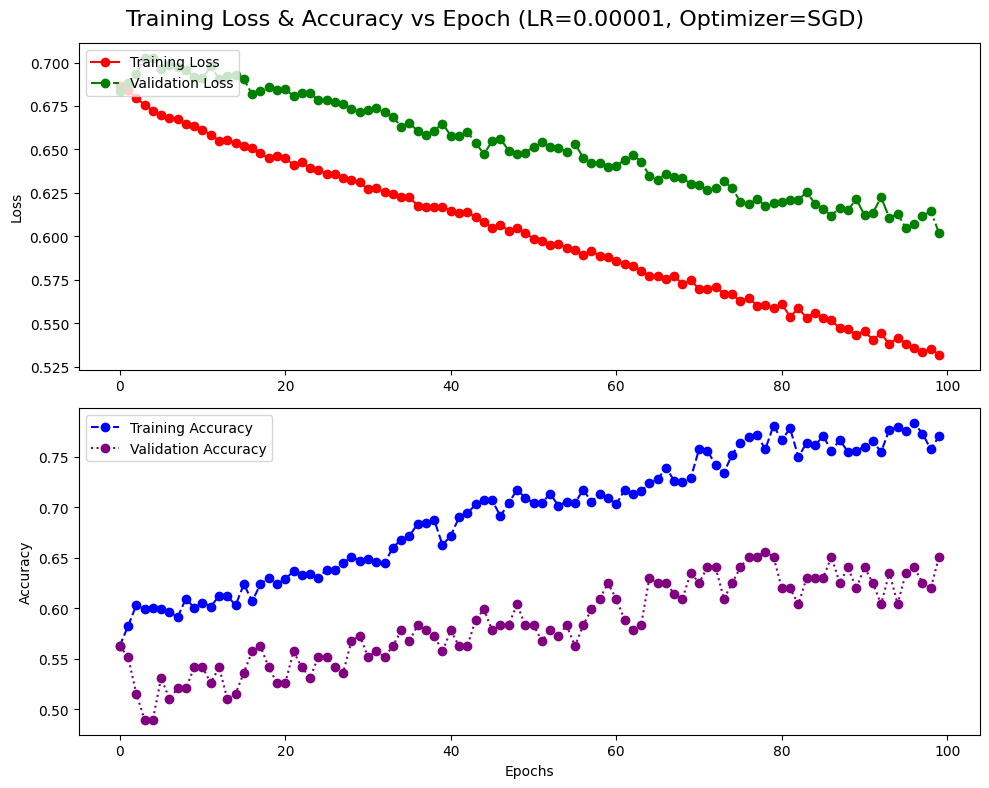

Entrenando con learning_rate=0.00001, epochs=100, optimizer=Adam


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5745784695201037
Epoch 1 Training Loss = 0.6728344742889998
Epoch 1 Validation Accuracy = 0.671875
Epoch 1 Validation Loss = 0.6396615306536356
La mejor precisión de Validation Loss (0.6396615306536356) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.8106355382619974
Epoch 2 Training Loss = 0.5385655825703989
Epoch 2 Validation Accuracy = 0.7083333333333334
Epoch 2 Validation Loss = 0.5944233735402426
La mejor precisión de Validation Loss (0.5944233735402426) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.880674448767834
Epoch 3 Training Loss = 0.45183325872965513
Epoch 3 Validation Accuracy = 0.7447916666666666
Epoch 3 Validation Loss = 0.539142390092214
La mejor precisión de Validation Loss (0.539142390092214) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.940337224383917
Epoch 4 Training Loss = 0.3663848715842775
Epoch 4 Validation Accuracy = 0.8125
Epoch 4 Validation Loss = 0.485299676656723
La mejor precisión de Validation Loss (0.485299676656723) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.9584954604409858
Epoch 5 Training Loss = 0.29161431631689405
Epoch 5 Validation Accuracy = 0.8125
Epoch 5 Validation Loss = 0.44124547640482586
La mejor precisión de Validation Loss (0.44124547640482586) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.9740596627756161
Epoch 6 Training Loss = 0.22485598786486416
Epoch 6 Validation Accuracy = 0.8385416666666666
Epoch 6 Validation Loss = 0.39876648783683777
La mejor precisión de Validation Loss (0.39876648783683777) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.9831387808041504
Epoch 7 Training Loss = 0.1711811835354559
Epoch 7 Validation Accuracy = 0.828125
Epoch 7 Validation Loss = 0.3775439163049062
La mejor precisión de Validation Loss (0.3775439163049062) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.993514915693904
Epoch 8 Training Loss = 0.12793234002265486
Epoch 8 Validation Accuracy = 0.8385416666666666
Epoch 8 Validation Loss = 0.35035576423009235
La mejor precisión de Validation Loss (0.35035576423009235) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.9961089494163424
Epoch 9 Training Loss = 0.1061072087280172
Epoch 9 Validation Accuracy = 0.8385416666666666
Epoch 9 Validation Loss = 0.3581589063008626
La mejor precisión de Validation Loss (0.35035576423009235) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9961089494163424
Epoch 10 Training Loss = 0.08439068942682289
Epoch 10 Validation Accuracy = 0.8333333333333334
Epoch 10 Validation Loss = 0.36125696698824566
La mejor precisión de Validation Loss (0.35035576423009235) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9987029831387808
Epoch 11 Training Loss = 0.06000840773107786
Epoch 11 Validation Accuracy = 0.8229166666666666
Epoch 11 Validation Loss = 0.35594571630160016
La mejor precisión de Validation Loss (0.35035576423009235) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9961089494163424
Epoch 12 Training Loss = 0.05772343150372635
Epoch 12 Validation Accuracy = 0.8125
Epoch 12 Validation Loss = 0.3668115834395091
La mejor precisión de Validation Loss (0.35035576423009235) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9961089494163424
Epoch 13 Training Loss = 0.049006586099567734
Epoch 13 Validation Accuracy = 0.859375
Epoch 13 Validation Loss = 0.33770954608917236
La mejor precisión de Validation Loss (0.33770954608917236) se alcanzó en la época 13


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9961089494163424
Epoch 14 Training Loss = 0.04659169719067684
Epoch 14 Validation Accuracy = 0.8489583333333334
Epoch 14 Validation Loss = 0.33692728479703266
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9961089494163424
Epoch 15 Training Loss = 0.045104500413636756
Epoch 15 Validation Accuracy = 0.7604166666666666
Epoch 15 Validation Loss = 0.4531368414560954
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.9909208819714657
Epoch 16 Training Loss = 0.04643602068167561
Epoch 16 Validation Accuracy = 0.78125
Epoch 16 Validation Loss = 0.41341232260068256
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9961089494163424
Epoch 17 Training Loss = 0.0384115720537386
Epoch 17 Validation Accuracy = 0.8385416666666666
Epoch 17 Validation Loss = 0.3418428699175517
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9974059662775616
Epoch 18 Training Loss = 0.031816141172547746
Epoch 18 Validation Accuracy = 0.8541666666666666
Epoch 18 Validation Loss = 0.34348997473716736
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9961089494163424
Epoch 19 Training Loss = 0.034685784189849515
Epoch 19 Validation Accuracy = 0.8177083333333334
Epoch 19 Validation Loss = 0.3568843603134155
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9974059662775616
Epoch 20 Training Loss = 0.02452965769747661
Epoch 20 Validation Accuracy = 0.8072916666666666
Epoch 20 Validation Loss = 0.40282200773557025
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9987029831387808
Epoch 21 Training Loss = 0.021242471307941293
Epoch 21 Validation Accuracy = 0.8177083333333334
Epoch 21 Validation Loss = 0.38818220297495526
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.9987029831387808
Epoch 22 Training Loss = 0.018968381731735904
Epoch 22 Validation Accuracy = 0.8489583333333334
Epoch 22 Validation Loss = 0.34421443939208984
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9987029831387808
Epoch 23 Training Loss = 0.01652341578566456
Epoch 23 Validation Accuracy = 0.828125
Epoch 23 Validation Loss = 0.3588571945826213
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 1.0
Epoch 24 Training Loss = 0.014214577143661552
Epoch 24 Validation Accuracy = 0.8229166666666666
Epoch 24 Validation Loss = 0.34462709228197735
La mejor precisión de Validation Loss (0.33692728479703266) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 1.0
Epoch 25 Training Loss = 0.012236232926100299
Epoch 25 Validation Accuracy = 0.859375
Epoch 25 Validation Loss = 0.33229532837867737
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 1.0
Epoch 26 Training Loss = 0.013428267376586776
Epoch 26 Validation Accuracy = 0.828125
Epoch 26 Validation Loss = 0.3653605580329895
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 1.0
Epoch 27 Training Loss = 0.009695174010656532
Epoch 27 Validation Accuracy = 0.828125
Epoch 27 Validation Loss = 0.35736239949862164
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 1.0
Epoch 28 Training Loss = 0.009995450905914359
Epoch 28 Validation Accuracy = 0.8333333333333334
Epoch 28 Validation Loss = 0.38096632560094196
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9987029831387808
Epoch 29 Training Loss = 0.010959313658154274
Epoch 29 Validation Accuracy = 0.8489583333333334
Epoch 29 Validation Loss = 0.35560372471809387
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 1.0
Epoch 30 Training Loss = 0.008725775096531663
Epoch 30 Validation Accuracy = 0.8645833333333334
Epoch 30 Validation Loss = 0.35123692949612934
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 1.0
Epoch 31 Training Loss = 0.009066145272802285
Epoch 31 Validation Accuracy = 0.8229166666666666
Epoch 31 Validation Loss = 0.3718806803226471
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9987029831387808
Epoch 32 Training Loss = 0.008360911126885123
Epoch 32 Validation Accuracy = 0.8645833333333334
Epoch 32 Validation Loss = 0.3635171850522359
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 1.0
Epoch 33 Training Loss = 0.007868195766759444
Epoch 33 Validation Accuracy = 0.796875
Epoch 33 Validation Loss = 0.484393705924352
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9948119325551232
Epoch 34 Training Loss = 0.025504210772990563
Epoch 34 Validation Accuracy = 0.796875
Epoch 34 Validation Loss = 0.523339202006658
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.993514915693904
Epoch 35 Training Loss = 0.025521787533345698
Epoch 35 Validation Accuracy = 0.7239583333333334
Epoch 35 Validation Loss = 0.6309172213077545
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9974059662775616
Epoch 36 Training Loss = 0.01822646486967918
Epoch 36 Validation Accuracy = 0.7864583333333334
Epoch 36 Validation Loss = 0.48950352271397907
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9961089494163424
Epoch 37 Training Loss = 0.0258522859343295
Epoch 37 Validation Accuracy = 0.78125
Epoch 37 Validation Loss = 0.5017930765946707
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9948119325551232
Epoch 38 Training Loss = 0.025024114946089443
Epoch 38 Validation Accuracy = 0.7760416666666666
Epoch 38 Validation Loss = 0.5609565377235413
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9961089494163424
Epoch 39 Training Loss = 0.02444014640285811
Epoch 39 Validation Accuracy = 0.8072916666666666
Epoch 39 Validation Loss = 0.4692043562730153
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9961089494163424
Epoch 40 Training Loss = 0.019561276207019692
Epoch 40 Validation Accuracy = 0.7916666666666666
Epoch 40 Validation Loss = 0.46741146842638653
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9974059662775616
Epoch 41 Training Loss = 0.018865564231665372
Epoch 41 Validation Accuracy = 0.8125
Epoch 41 Validation Loss = 0.4237054189046224
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9961089494163424
Epoch 42 Training Loss = 0.024257934394977435
Epoch 42 Validation Accuracy = 0.8229166666666666
Epoch 42 Validation Loss = 0.39156587918599445
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9974059662775616
Epoch 43 Training Loss = 0.019217070124453915
Epoch 43 Validation Accuracy = 0.7708333333333334
Epoch 43 Validation Loss = 0.5540317495663961
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9961089494163424
Epoch 44 Training Loss = 0.023322069286652654
Epoch 44 Validation Accuracy = 0.7864583333333334
Epoch 44 Validation Loss = 0.507686048746109
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9974059662775616
Epoch 45 Training Loss = 0.015821914090720597
Epoch 45 Validation Accuracy = 0.7864583333333334
Epoch 45 Validation Loss = 0.47685539722442627
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9974059662775616
Epoch 46 Training Loss = 0.012068667754666196
Epoch 46 Validation Accuracy = 0.796875
Epoch 46 Validation Loss = 0.5112506945927938
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9987029831387808
Epoch 47 Training Loss = 0.010764660026235493
Epoch 47 Validation Accuracy = 0.796875
Epoch 47 Validation Loss = 0.4782605667908986
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9987029831387808
Epoch 48 Training Loss = 0.010148474735228391
Epoch 48 Validation Accuracy = 0.8072916666666666
Epoch 48 Validation Loss = 0.4554418126742045
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9974059662775616
Epoch 49 Training Loss = 0.010185283233064932
Epoch 49 Validation Accuracy = 0.8229166666666666
Epoch 49 Validation Loss = 0.4213283061981201
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9987029831387808
Epoch 50 Training Loss = 0.011546644134550862
Epoch 50 Validation Accuracy = 0.8020833333333334
Epoch 50 Validation Loss = 0.46395691235860187
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9961089494163424
Epoch 51 Training Loss = 0.02213085285265931
Epoch 51 Validation Accuracy = 0.8385416666666666
Epoch 51 Validation Loss = 0.39662045737107593
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9974059662775616
Epoch 52 Training Loss = 0.013181811312138648
Epoch 52 Validation Accuracy = 0.8177083333333334
Epoch 52 Validation Loss = 0.4078264534473419
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9987029831387808
Epoch 53 Training Loss = 0.00798668880764535
Epoch 53 Validation Accuracy = 0.8020833333333334
Epoch 53 Validation Loss = 0.4268496831258138
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9974059662775616
Epoch 54 Training Loss = 0.008722626977393599
Epoch 54 Validation Accuracy = 0.8072916666666666
Epoch 54 Validation Loss = 0.45746861894925434
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9961089494163424
Epoch 55 Training Loss = 0.014072086053251756
Epoch 55 Validation Accuracy = 0.8125
Epoch 55 Validation Loss = 0.4641847411791484
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9974059662775616
Epoch 56 Training Loss = 0.013578028117346392
Epoch 56 Validation Accuracy = 0.8125
Epoch 56 Validation Loss = 0.46197327971458435
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9948119325551232
Epoch 57 Training Loss = 0.012941149982651539
Epoch 57 Validation Accuracy = 0.796875
Epoch 57 Validation Loss = 0.4932507574558258
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9974059662775616
Epoch 58 Training Loss = 0.010878745917032742
Epoch 58 Validation Accuracy = 0.796875
Epoch 58 Validation Loss = 0.49324623743693036
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9961089494163424
Epoch 59 Training Loss = 0.021855112334324384
Epoch 59 Validation Accuracy = 0.8125
Epoch 59 Validation Loss = 0.42452869812647503
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9961089494163424
Epoch 60 Training Loss = 0.02235543380712489
Epoch 60 Validation Accuracy = 0.828125
Epoch 60 Validation Loss = 0.4246894915898641
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9987029831387808
Epoch 61 Training Loss = 0.018914019029428058
Epoch 61 Validation Accuracy = 0.8177083333333334
Epoch 61 Validation Loss = 0.429906964302063
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9974059662775616
Epoch 62 Training Loss = 0.024455681733120276
Epoch 62 Validation Accuracy = 0.828125
Epoch 62 Validation Loss = 0.40722491840521496
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9961089494163424
Epoch 63 Training Loss = 0.0209215035620985
Epoch 63 Validation Accuracy = 0.8072916666666666
Epoch 63 Validation Loss = 0.5130667984485626
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9974059662775616
Epoch 64 Training Loss = 0.029050535958468064
Epoch 64 Validation Accuracy = 0.8072916666666666
Epoch 64 Validation Loss = 0.5377717614173889
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9948119325551232
Epoch 65 Training Loss = 0.03724341361448845
Epoch 65 Validation Accuracy = 0.796875
Epoch 65 Validation Loss = 0.4532659649848938
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9922178988326849
Epoch 66 Training Loss = 0.025157450817902265
Epoch 66 Validation Accuracy = 0.8333333333333334
Epoch 66 Validation Loss = 0.3909613887468974
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9974059662775616
Epoch 67 Training Loss = 0.0181521192137466
Epoch 67 Validation Accuracy = 0.828125
Epoch 67 Validation Loss = 0.38966691493988037
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9961089494163424
Epoch 68 Training Loss = 0.02025954572220566
Epoch 68 Validation Accuracy = 0.78125
Epoch 68 Validation Loss = 0.4700253407160441
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9974059662775616
Epoch 69 Training Loss = 0.015079594597742252
Epoch 69 Validation Accuracy = 0.8385416666666666
Epoch 69 Validation Loss = 0.37849270304044086
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9974059662775616
Epoch 70 Training Loss = 0.011677891557164075
Epoch 70 Validation Accuracy = 0.84375
Epoch 70 Validation Loss = 0.3843645354111989
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9974059662775616
Epoch 71 Training Loss = 0.009266185043947398
Epoch 71 Validation Accuracy = 0.828125
Epoch 71 Validation Loss = 0.39296847581863403
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9974059662775616
Epoch 72 Training Loss = 0.014614674174522765
Epoch 72 Validation Accuracy = 0.7864583333333334
Epoch 72 Validation Loss = 0.4761991600195567
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 1.0
Epoch 73 Training Loss = 0.007769349718468817
Epoch 73 Validation Accuracy = 0.7916666666666666
Epoch 73 Validation Loss = 0.49028366804122925
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9961089494163424
Epoch 74 Training Loss = 0.019380975828715025
Epoch 74 Validation Accuracy = 0.78125
Epoch 74 Validation Loss = 0.4992608328660329
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9974059662775616
Epoch 75 Training Loss = 0.011124868839785902
Epoch 75 Validation Accuracy = 0.8489583333333334
Epoch 75 Validation Loss = 0.36691813667615253
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9987029831387808
Epoch 76 Training Loss = 0.01696606337946831
Epoch 76 Validation Accuracy = 0.84375
Epoch 76 Validation Loss = 0.4222758611043294
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9987029831387808
Epoch 77 Training Loss = 0.018909367075583737
Epoch 77 Validation Accuracy = 0.8385416666666666
Epoch 77 Validation Loss = 0.4156390130519867
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9974059662775616
Epoch 78 Training Loss = 0.017322077052293276
Epoch 78 Validation Accuracy = 0.859375
Epoch 78 Validation Loss = 0.3900225857893626
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9948119325551232
Epoch 79 Training Loss = 0.019332796760415598
Epoch 79 Validation Accuracy = 0.7291666666666666
Epoch 79 Validation Loss = 0.5966811180114746
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9948119325551232
Epoch 80 Training Loss = 0.019061022308859227
Epoch 80 Validation Accuracy = 0.75
Epoch 80 Validation Loss = 0.5622990131378174
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.993514915693904
Epoch 81 Training Loss = 0.025255885569501944
Epoch 81 Validation Accuracy = 0.8333333333333334
Epoch 81 Validation Loss = 0.4648778736591339
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9961089494163424
Epoch 82 Training Loss = 0.025010615229683935
Epoch 82 Validation Accuracy = 0.8333333333333334
Epoch 82 Validation Loss = 0.4230704605579376
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.993514915693904
Epoch 83 Training Loss = 0.025116324256839843
Epoch 83 Validation Accuracy = 0.8489583333333334
Epoch 83 Validation Loss = 0.37027544776598614
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9948119325551232
Epoch 84 Training Loss = 0.02650915142317845
Epoch 84 Validation Accuracy = 0.8489583333333334
Epoch 84 Validation Loss = 0.34907354911168414
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9974059662775616
Epoch 85 Training Loss = 0.01620172907570534
Epoch 85 Validation Accuracy = 0.8177083333333334
Epoch 85 Validation Loss = 0.42735575636227924
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9922178988326849
Epoch 86 Training Loss = 0.029304041124967286
Epoch 86 Validation Accuracy = 0.8125
Epoch 86 Validation Loss = 0.4193425973256429
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9974059662775616
Epoch 87 Training Loss = 0.01446789606618085
Epoch 87 Validation Accuracy = 0.875
Epoch 87 Validation Loss = 0.34434125820795697
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9948119325551232
Epoch 88 Training Loss = 0.01636164257575875
Epoch 88 Validation Accuracy = 0.8697916666666666
Epoch 88 Validation Loss = 0.34482525289058685
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9961089494163424
Epoch 89 Training Loss = 0.013041084049445916
Epoch 89 Validation Accuracy = 0.8697916666666666
Epoch 89 Validation Loss = 0.34640824794769287
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 1.0
Epoch 90 Training Loss = 0.009742195408757481
Epoch 90 Validation Accuracy = 0.875
Epoch 90 Validation Loss = 0.3416864375273387
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 1.0
Epoch 91 Training Loss = 0.008738124919463379
Epoch 91 Validation Accuracy = 0.8489583333333334
Epoch 91 Validation Loss = 0.3893876572450002
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9987029831387808
Epoch 92 Training Loss = 0.012267787323542298
Epoch 92 Validation Accuracy = 0.8385416666666666
Epoch 92 Validation Loss = 0.3888392249743144
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9974059662775616
Epoch 93 Training Loss = 0.01625562573260061
Epoch 93 Validation Accuracy = 0.7864583333333334
Epoch 93 Validation Loss = 0.5179284512996674
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9974059662775616
Epoch 94 Training Loss = 0.029077765789129392
Epoch 94 Validation Accuracy = 0.796875
Epoch 94 Validation Loss = 0.4565228819847107
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9987029831387808
Epoch 95 Training Loss = 0.02178530346713332
Epoch 95 Validation Accuracy = 0.8020833333333334
Epoch 95 Validation Loss = 0.4281463623046875
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9961089494163424
Epoch 96 Training Loss = 0.015624167139118902
Epoch 96 Validation Accuracy = 0.8072916666666666
Epoch 96 Validation Loss = 0.42237242062886554
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9987029831387808
Epoch 97 Training Loss = 0.011705190286368867
Epoch 97 Validation Accuracy = 0.8541666666666666
Epoch 97 Validation Loss = 0.39251379172007245
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9961089494163424
Epoch 98 Training Loss = 0.02514878121215546
Epoch 98 Validation Accuracy = 0.8541666666666666
Epoch 98 Validation Loss = 0.39112138748168945
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9987029831387808
Epoch 99 Training Loss = 0.013868246560894562
Epoch 99 Validation Accuracy = 0.8489583333333334
Epoch 99 Validation Loss = 0.4114742577075958
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9974059662775616
Epoch 100 Training Loss = 0.010675734428425553
Epoch 100 Validation Accuracy = 0.84375
Epoch 100 Validation Loss = 0.39995702107747394
La mejor precisión de Validation Loss (0.33229532837867737) se alcanzó en la época 25


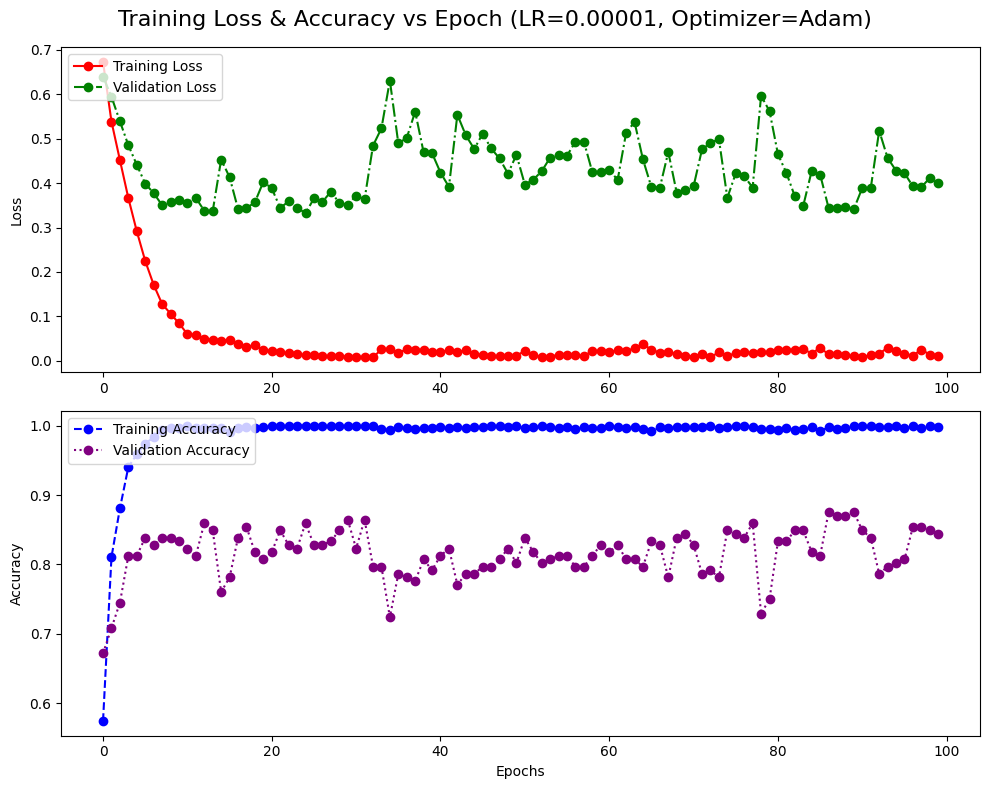

Entrenando con learning_rate=0.00001, epochs=100, optimizer=RMSprop


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.6990920881971465
Epoch 1 Training Loss = 0.5727196949619882
Epoch 1 Validation Accuracy = 0.7552083333333334
Epoch 1 Validation Loss = 0.5375461379686991
La mejor precisión de Validation Loss (0.5375461379686991) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.9455252918287937
Epoch 2 Training Loss = 0.24843257597989454
Epoch 2 Validation Accuracy = 0.75
Epoch 2 Validation Loss = 0.4638318518797557
La mejor precisión de Validation Loss (0.4638318518797557) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.993514915693904
Epoch 3 Training Loss = 0.10956741788275974
Epoch 3 Validation Accuracy = 0.8072916666666666
Epoch 3 Validation Loss = 0.42166415353616077
La mejor precisión de Validation Loss (0.42166415353616077) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 1.0
Epoch 4 Training Loss = 0.056297487119060546
Epoch 4 Validation Accuracy = 0.8020833333333334
Epoch 4 Validation Loss = 0.4353346327940623
La mejor precisión de Validation Loss (0.42166415353616077) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.9987029831387808
Epoch 5 Training Loss = 0.03629979912563675
Epoch 5 Validation Accuracy = 0.7916666666666666
Epoch 5 Validation Loss = 0.5106272300084432
La mejor precisión de Validation Loss (0.42166415353616077) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.9948119325551232
Epoch 6 Training Loss = 0.04016858030076775
Epoch 6 Validation Accuracy = 0.8333333333333334
Epoch 6 Validation Loss = 0.3497832814852397
La mejor precisión de Validation Loss (0.3497832814852397) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.9987029831387808
Epoch 7 Training Loss = 0.024526275387553236
Epoch 7 Validation Accuracy = 0.8645833333333334
Epoch 7 Validation Loss = 0.3226361076037089
La mejor precisión de Validation Loss (0.3226361076037089) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.9987029831387808
Epoch 8 Training Loss = 0.01861870997668704
Epoch 8 Validation Accuracy = 0.8802083333333334
Epoch 8 Validation Loss = 0.3184514045715332
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.9961089494163424
Epoch 9 Training Loss = 0.020836423884415287
Epoch 9 Validation Accuracy = 0.8229166666666666
Epoch 9 Validation Loss = 0.43999675909678143
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9961089494163424
Epoch 10 Training Loss = 0.03676449399726555
Epoch 10 Validation Accuracy = 0.8645833333333334
Epoch 10 Validation Loss = 0.35899093747138977
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9974059662775616
Epoch 11 Training Loss = 0.01605988188553722
Epoch 11 Validation Accuracy = 0.859375
Epoch 11 Validation Loss = 0.33955196539560956
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9974059662775616
Epoch 12 Training Loss = 0.01654709722899896
Epoch 12 Validation Accuracy = 0.8333333333333334
Epoch 12 Validation Loss = 0.40586918592453003
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9987029831387808
Epoch 13 Training Loss = 0.026896602006679843
Epoch 13 Validation Accuracy = 0.8489583333333334
Epoch 13 Validation Loss = 0.3643602828184764
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9987029831387808
Epoch 14 Training Loss = 0.015066636491919616
Epoch 14 Validation Accuracy = 0.84375
Epoch 14 Validation Loss = 0.3472503324349721
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9987029831387808
Epoch 15 Training Loss = 0.011001327018290952
Epoch 15 Validation Accuracy = 0.8541666666666666
Epoch 15 Validation Loss = 0.3560917377471924
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.9987029831387808
Epoch 16 Training Loss = 0.012183037983922798
Epoch 16 Validation Accuracy = 0.8333333333333334
Epoch 16 Validation Loss = 0.375300665696462
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9974059662775616
Epoch 17 Training Loss = 0.019100107378223683
Epoch 17 Validation Accuracy = 0.8072916666666666
Epoch 17 Validation Loss = 0.3894764681657155
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9987029831387808
Epoch 18 Training Loss = 0.019475854015226647
Epoch 18 Validation Accuracy = 0.7864583333333334
Epoch 18 Validation Loss = 0.4119251569112142
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9974059662775616
Epoch 19 Training Loss = 0.020325597119547824
Epoch 19 Validation Accuracy = 0.8177083333333334
Epoch 19 Validation Loss = 0.4040290315945943
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9974059662775616
Epoch 20 Training Loss = 0.019561956210204446
Epoch 20 Validation Accuracy = 0.8177083333333334
Epoch 20 Validation Loss = 0.38909844557444256
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9974059662775616
Epoch 21 Training Loss = 0.01761784724379019
Epoch 21 Validation Accuracy = 0.8645833333333334
Epoch 21 Validation Loss = 0.35242364803949994
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.9974059662775616
Epoch 22 Training Loss = 0.017261576405140523
Epoch 22 Validation Accuracy = 0.8229166666666666
Epoch 22 Validation Loss = 0.3984805842240651
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9974059662775616
Epoch 23 Training Loss = 0.01825352241653567
Epoch 23 Validation Accuracy = 0.84375
Epoch 23 Validation Loss = 0.35852926472822827
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9961089494163424
Epoch 24 Training Loss = 0.015289131073636303
Epoch 24 Validation Accuracy = 0.8177083333333334
Epoch 24 Validation Loss = 0.4534929096698761
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.9961089494163424
Epoch 25 Training Loss = 0.0214745750947917
Epoch 25 Validation Accuracy = 0.859375
Epoch 25 Validation Loss = 0.3571015993754069
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9974059662775616
Epoch 26 Training Loss = 0.017204871166850186
Epoch 26 Validation Accuracy = 0.8177083333333334
Epoch 26 Validation Loss = 0.4290475050608317
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.9974059662775616
Epoch 27 Training Loss = 0.019666582771157785
Epoch 27 Validation Accuracy = 0.8489583333333334
Epoch 27 Validation Loss = 0.376831849416097
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9974059662775616
Epoch 28 Training Loss = 0.014028922585231746
Epoch 28 Validation Accuracy = 0.8489583333333334
Epoch 28 Validation Loss = 0.3662722110748291
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9961089494163424
Epoch 29 Training Loss = 0.014100250914866823
Epoch 29 Validation Accuracy = 0.8541666666666666
Epoch 29 Validation Loss = 0.3693183859189351
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9961089494163424
Epoch 30 Training Loss = 0.01721923290987423
Epoch 30 Validation Accuracy = 0.8385416666666666
Epoch 30 Validation Loss = 0.4307199815909068
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.9974059662775616
Epoch 31 Training Loss = 0.01783850129051122
Epoch 31 Validation Accuracy = 0.8645833333333334
Epoch 31 Validation Loss = 0.3813379406929016
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9987029831387808
Epoch 32 Training Loss = 0.009644812076858664
Epoch 32 Validation Accuracy = 0.84375
Epoch 32 Validation Loss = 0.3857905864715576
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9987029831387808
Epoch 33 Training Loss = 0.009628736676138509
Epoch 33 Validation Accuracy = 0.8489583333333334
Epoch 33 Validation Loss = 0.3789972762266795
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9987029831387808
Epoch 34 Training Loss = 0.007670498596825643
Epoch 34 Validation Accuracy = 0.8541666666666666
Epoch 34 Validation Loss = 0.3653223514556885
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9987029831387808
Epoch 35 Training Loss = 0.008367525387057689
Epoch 35 Validation Accuracy = 0.796875
Epoch 35 Validation Loss = 0.5121460358301798
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 1.0
Epoch 36 Training Loss = 0.008055354969820004
Epoch 36 Validation Accuracy = 0.859375
Epoch 36 Validation Loss = 0.3929067552089691
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9987029831387808
Epoch 37 Training Loss = 0.00835382814691843
Epoch 37 Validation Accuracy = 0.828125
Epoch 37 Validation Loss = 0.4981074233849843
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9987029831387808
Epoch 38 Training Loss = 0.014607987979042855
Epoch 38 Validation Accuracy = 0.7239583333333334
Epoch 38 Validation Loss = 0.6019830306371053
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9974059662775616
Epoch 39 Training Loss = 0.013609331212309703
Epoch 39 Validation Accuracy = 0.7604166666666666
Epoch 39 Validation Loss = 0.4807177682717641
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9987029831387808
Epoch 40 Training Loss = 0.019100095519866075
Epoch 40 Validation Accuracy = 0.8489583333333334
Epoch 40 Validation Loss = 0.3568793833255768
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9987029831387808
Epoch 41 Training Loss = 0.016117871531204413
Epoch 41 Validation Accuracy = 0.8489583333333334
Epoch 41 Validation Loss = 0.34335005283355713
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9987029831387808
Epoch 42 Training Loss = 0.011686130208186757
Epoch 42 Validation Accuracy = 0.8489583333333334
Epoch 42 Validation Loss = 0.3530610501766205
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9987029831387808
Epoch 43 Training Loss = 0.00975359428007199
Epoch 43 Validation Accuracy = 0.8541666666666666
Epoch 43 Validation Loss = 0.34525027871131897
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9987029831387808
Epoch 44 Training Loss = 0.008680375367487586
Epoch 44 Validation Accuracy = 0.8645833333333334
Epoch 44 Validation Loss = 0.3368759751319885
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9987029831387808
Epoch 45 Training Loss = 0.007933125827562948
Epoch 45 Validation Accuracy = 0.875
Epoch 45 Validation Loss = 0.34406113624572754
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9974059662775616
Epoch 46 Training Loss = 0.00800129829213777
Epoch 46 Validation Accuracy = 0.8489583333333334
Epoch 46 Validation Loss = 0.40050020813941956
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9922178988326849
Epoch 47 Training Loss = 0.02308583530161322
Epoch 47 Validation Accuracy = 0.7864583333333334
Epoch 47 Validation Loss = 0.48148752252260846
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9961089494163424
Epoch 48 Training Loss = 0.01886450484317719
Epoch 48 Validation Accuracy = 0.859375
Epoch 48 Validation Loss = 0.33465710779031116
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9987029831387808
Epoch 49 Training Loss = 0.0078007528212902305
Epoch 49 Validation Accuracy = 0.859375
Epoch 49 Validation Loss = 0.3419046302636464
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9961089494163424
Epoch 50 Training Loss = 0.012026233953724576
Epoch 50 Validation Accuracy = 0.8125
Epoch 50 Validation Loss = 0.5190481940905253
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9987029831387808
Epoch 51 Training Loss = 0.012771671003723655
Epoch 51 Validation Accuracy = 0.8489583333333334
Epoch 51 Validation Loss = 0.38254283865292865
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9974059662775616
Epoch 52 Training Loss = 0.013372895705251533
Epoch 52 Validation Accuracy = 0.8489583333333334
Epoch 52 Validation Loss = 0.41903894146283466
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9987029831387808
Epoch 53 Training Loss = 0.011849223813658095
Epoch 53 Validation Accuracy = 0.8385416666666666
Epoch 53 Validation Loss = 0.4070127507050832
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 1.0
Epoch 54 Training Loss = 0.00722441782669953
Epoch 54 Validation Accuracy = 0.859375
Epoch 54 Validation Loss = 0.40049639344215393
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 1.0
Epoch 55 Training Loss = 0.0061340398576724235
Epoch 55 Validation Accuracy = 0.875
Epoch 55 Validation Loss = 0.37112487355868023
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 1.0
Epoch 56 Training Loss = 0.004438517385690283
Epoch 56 Validation Accuracy = 0.875
Epoch 56 Validation Loss = 0.35165737569332123
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 1.0
Epoch 57 Training Loss = 0.0038296513515494366
Epoch 57 Validation Accuracy = 0.875
Epoch 57 Validation Loss = 0.3548392554124196
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 1.0
Epoch 58 Training Loss = 0.0037851067520822995
Epoch 58 Validation Accuracy = 0.8645833333333334
Epoch 58 Validation Loss = 0.3616188367207845
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9987029831387808
Epoch 59 Training Loss = 0.006310905077423413
Epoch 59 Validation Accuracy = 0.8020833333333334
Epoch 59 Validation Loss = 0.473951131105423
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9987029831387808
Epoch 60 Training Loss = 0.012657415590474888
Epoch 60 Validation Accuracy = 0.8385416666666666
Epoch 60 Validation Loss = 0.45915788412094116
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9987029831387808
Epoch 61 Training Loss = 0.0072431195232577515
Epoch 61 Validation Accuracy = 0.859375
Epoch 61 Validation Loss = 0.42430293560028076
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 1.0
Epoch 62 Training Loss = 0.005423013643928152
Epoch 62 Validation Accuracy = 0.8489583333333334
Epoch 62 Validation Loss = 0.40119653940200806
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9987029831387808
Epoch 63 Training Loss = 0.007077077826141982
Epoch 63 Validation Accuracy = 0.8645833333333334
Epoch 63 Validation Loss = 0.41033034523328143
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 1.0
Epoch 64 Training Loss = 0.003280262935401729
Epoch 64 Validation Accuracy = 0.8645833333333334
Epoch 64 Validation Loss = 0.3920128246148427
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9987029831387808
Epoch 65 Training Loss = 0.010472061646433037
Epoch 65 Validation Accuracy = 0.78125
Epoch 65 Validation Loss = 0.5554737448692322
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9974059662775616
Epoch 66 Training Loss = 0.01849562892854581
Epoch 66 Validation Accuracy = 0.8333333333333334
Epoch 66 Validation Loss = 0.43184932072957355
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9987029831387808
Epoch 67 Training Loss = 0.008049716890322096
Epoch 67 Validation Accuracy = 0.8645833333333334
Epoch 67 Validation Loss = 0.3980038066705068
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 1.0
Epoch 68 Training Loss = 0.00557478421262614
Epoch 68 Validation Accuracy = 0.8697916666666666
Epoch 68 Validation Loss = 0.3734298249085744
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 1.0
Epoch 69 Training Loss = 0.0036883223868288033
Epoch 69 Validation Accuracy = 0.875
Epoch 69 Validation Loss = 0.36235080162684125
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 1.0
Epoch 70 Training Loss = 0.0033434636784589397
Epoch 70 Validation Accuracy = 0.8333333333333334
Epoch 70 Validation Loss = 0.45768341422080994
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 1.0
Epoch 71 Training Loss = 0.0030325627517336848
Epoch 71 Validation Accuracy = 0.859375
Epoch 71 Validation Loss = 0.3849898775418599
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 1.0
Epoch 72 Training Loss = 0.004127689438235454
Epoch 72 Validation Accuracy = 0.8645833333333334
Epoch 72 Validation Loss = 0.3656301001707713
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 1.0
Epoch 73 Training Loss = 0.003337168442773912
Epoch 73 Validation Accuracy = 0.8645833333333334
Epoch 73 Validation Loss = 0.3624738355477651
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 1.0
Epoch 74 Training Loss = 0.0026777072211101784
Epoch 74 Validation Accuracy = 0.8645833333333334
Epoch 74 Validation Loss = 0.3589072525501251
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 1.0
Epoch 75 Training Loss = 0.0026352696903484806
Epoch 75 Validation Accuracy = 0.8697916666666666
Epoch 75 Validation Loss = 0.3724984327952067
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9974059662775616
Epoch 76 Training Loss = 0.006642876799313784
Epoch 76 Validation Accuracy = 0.7447916666666666
Epoch 76 Validation Loss = 0.8706716696421305
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9961089494163424
Epoch 77 Training Loss = 0.020073563324338267
Epoch 77 Validation Accuracy = 0.8125
Epoch 77 Validation Loss = 0.48912827173868817
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9961089494163424
Epoch 78 Training Loss = 0.01683031205249764
Epoch 78 Validation Accuracy = 0.859375
Epoch 78 Validation Loss = 0.37268516421318054
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9987029831387808
Epoch 79 Training Loss = 0.0075137452856575936
Epoch 79 Validation Accuracy = 0.8385416666666666
Epoch 79 Validation Loss = 0.4017118414243062
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9948119325551232
Epoch 80 Training Loss = 0.01952707494975064
Epoch 80 Validation Accuracy = 0.8333333333333334
Epoch 80 Validation Loss = 0.4477667510509491
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.9974059662775616
Epoch 81 Training Loss = 0.017988450101053707
Epoch 81 Validation Accuracy = 0.84375
Epoch 81 Validation Loss = 0.396531601746877
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9961089494163424
Epoch 82 Training Loss = 0.012575893956399613
Epoch 82 Validation Accuracy = 0.8645833333333334
Epoch 82 Validation Loss = 0.37555978695551556
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9974059662775616
Epoch 83 Training Loss = 0.009922072532962423
Epoch 83 Validation Accuracy = 0.8697916666666666
Epoch 83 Validation Loss = 0.3633619447549184
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 1.0
Epoch 84 Training Loss = 0.0058811430694914665
Epoch 84 Validation Accuracy = 0.8645833333333334
Epoch 84 Validation Loss = 0.3673494756221771
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9987029831387808
Epoch 85 Training Loss = 0.005006197264995402
Epoch 85 Validation Accuracy = 0.8333333333333334
Epoch 85 Validation Loss = 0.4332858721415202
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9974059662775616
Epoch 86 Training Loss = 0.013069245582579329
Epoch 86 Validation Accuracy = 0.8072916666666666
Epoch 86 Validation Loss = 0.5060975054899851
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9948119325551232
Epoch 87 Training Loss = 0.01773788114156859
Epoch 87 Validation Accuracy = 0.8489583333333334
Epoch 87 Validation Loss = 0.3767245411872864
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9974059662775616
Epoch 88 Training Loss = 0.009916118165265513
Epoch 88 Validation Accuracy = 0.8541666666666666
Epoch 88 Validation Loss = 0.372996320327123
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9987029831387808
Epoch 89 Training Loss = 0.00773141467545167
Epoch 89 Validation Accuracy = 0.8541666666666666
Epoch 89 Validation Loss = 0.36744282643000287
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.9987029831387808
Epoch 90 Training Loss = 0.007028168033513732
Epoch 90 Validation Accuracy = 0.84375
Epoch 90 Validation Loss = 0.3929981589317322
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9987029831387808
Epoch 91 Training Loss = 0.005383455198760665
Epoch 91 Validation Accuracy = 0.859375
Epoch 91 Validation Loss = 0.3717385133107503
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9987029831387808
Epoch 92 Training Loss = 0.006951885058722143
Epoch 92 Validation Accuracy = 0.8333333333333334
Epoch 92 Validation Loss = 0.38947831590970355
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9974059662775616
Epoch 93 Training Loss = 0.014243812895779789
Epoch 93 Validation Accuracy = 0.8072916666666666
Epoch 93 Validation Loss = 0.5091606378555298
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9961089494163424
Epoch 94 Training Loss = 0.01691508214635685
Epoch 94 Validation Accuracy = 0.84375
Epoch 94 Validation Loss = 0.43225635091463727
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 1.0
Epoch 95 Training Loss = 0.006766462159837111
Epoch 95 Validation Accuracy = 0.8125
Epoch 95 Validation Loss = 0.44639772176742554
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9974059662775616
Epoch 96 Training Loss = 0.007597674926122029
Epoch 96 Validation Accuracy = 0.8229166666666666
Epoch 96 Validation Loss = 0.4565115173657735
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 1.0
Epoch 97 Training Loss = 0.006541934593951501
Epoch 97 Validation Accuracy = 0.84375
Epoch 97 Validation Loss = 0.4176650544007619
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 1.0
Epoch 98 Training Loss = 0.005385505094708713
Epoch 98 Validation Accuracy = 0.8333333333333334
Epoch 98 Validation Loss = 0.4176424443721771
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9987029831387808
Epoch 99 Training Loss = 0.006508764551152824
Epoch 99 Validation Accuracy = 0.7604166666666666
Epoch 99 Validation Loss = 0.6230239272117615
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9974059662775616
Epoch 100 Training Loss = 0.007413627939774678
Epoch 100 Validation Accuracy = 0.7135416666666666
Epoch 100 Validation Loss = 0.7081660827000936
La mejor precisión de Validation Loss (0.3184514045715332) se alcanzó en la época 8


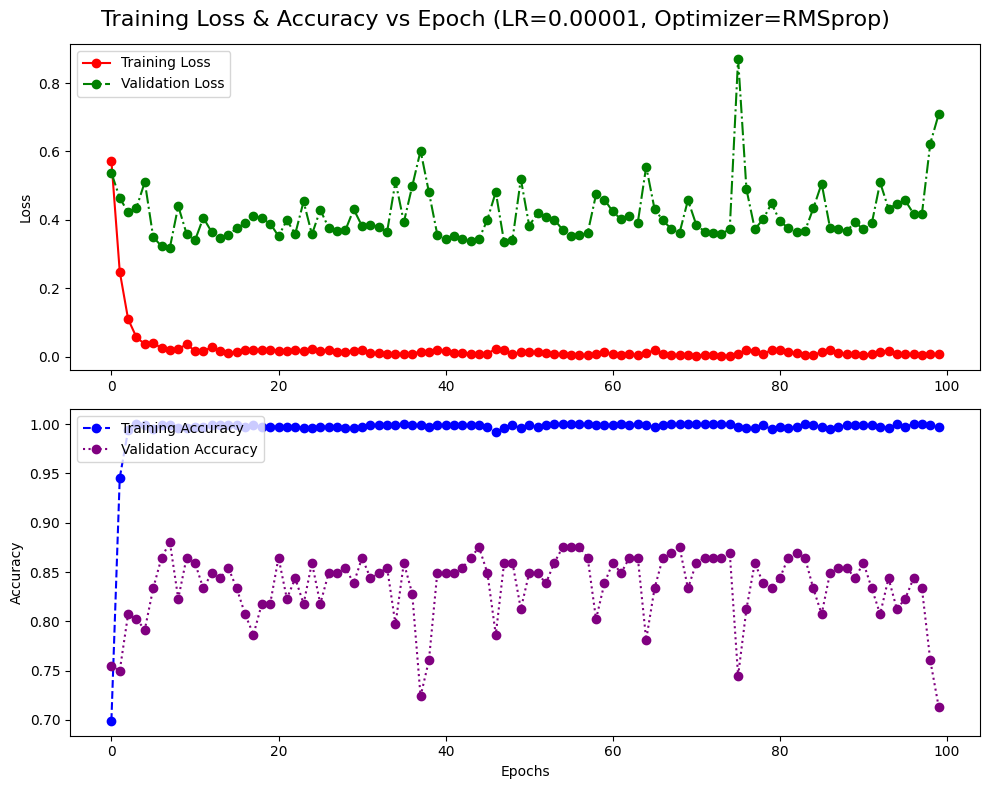

Entrenando con learning_rate=0.00010, epochs=100, optimizer=SGD


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.48119325551232167
Epoch 1 Training Loss = 0.7141563693682352
Epoch 1 Validation Accuracy = 0.4375
Epoch 1 Validation Loss = 0.739238957564036
La mejor precisión de Validation Loss (0.739238957564036) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.5603112840466926
Epoch 2 Training Loss = 0.6771171702175908
Epoch 2 Validation Accuracy = 0.4583333333333333
Epoch 2 Validation Loss = 0.7482619484265646
La mejor precisión de Validation Loss (0.739238957564036) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.5654993514915694
Epoch 3 Training Loss = 0.6644747916671861
Epoch 3 Validation Accuracy = 0.4583333333333333
Epoch 3 Validation Loss = 0.7378304799397787
La mejor precisión de Validation Loss (0.7378304799397787) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.5914396887159533
Epoch 4 Training Loss = 0.6538500829893328
Epoch 4 Validation Accuracy = 0.515625
Epoch 4 Validation Loss = 0.6897552013397217
La mejor precisión de Validation Loss (0.6897552013397217) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.6498054474708171
Epoch 5 Training Loss = 0.6360526173804366
Epoch 5 Validation Accuracy = 0.5208333333333334
Epoch 5 Validation Loss = 0.6775873700777689
La mejor precisión de Validation Loss (0.6775873700777689) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.6939040207522698
Epoch 6 Training Loss = 0.6169312433973825
Epoch 6 Validation Accuracy = 0.5572916666666666
Epoch 6 Validation Loss = 0.6630610823631287
La mejor precisión de Validation Loss (0.6630610823631287) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.6355382619974059
Epoch 7 Training Loss = 0.6048812301087781
Epoch 7 Validation Accuracy = 0.4947916666666667
Epoch 7 Validation Loss = 0.6668850978215536
La mejor precisión de Validation Loss (0.6630610823631287) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.6744487678339819
Epoch 8 Training Loss = 0.5888442765104787
Epoch 8 Validation Accuracy = 0.5885416666666666
Epoch 8 Validation Loss = 0.6388757228851318
La mejor precisión de Validation Loss (0.6388757228851318) se alcanzó en la época 8


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.7237354085603113
Epoch 9 Training Loss = 0.5713999237377201
Epoch 9 Validation Accuracy = 0.6145833333333334
Epoch 9 Validation Loss = 0.6271434624989828
La mejor precisión de Validation Loss (0.6271434624989828) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.7665369649805448
Epoch 10 Training Loss = 0.5681532254942661
Epoch 10 Validation Accuracy = 0.71875
Epoch 10 Validation Loss = 0.6078423857688904
La mejor precisión de Validation Loss (0.6078423857688904) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.7808041504539559
Epoch 11 Training Loss = 0.5630911911817221
Epoch 11 Validation Accuracy = 0.7552083333333334
Epoch 11 Validation Loss = 0.5969822208086649
La mejor precisión de Validation Loss (0.5969822208086649) se alcanzó en la época 11


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.7704280155642024
Epoch 12 Training Loss = 0.5380616169495341
Epoch 12 Validation Accuracy = 0.5416666666666666
Epoch 12 Validation Loss = 0.6431497931480408
La mejor precisión de Validation Loss (0.5969822208086649) se alcanzó en la época 11


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.7756160830090791
Epoch 13 Training Loss = 0.5197493458690965
Epoch 13 Validation Accuracy = 0.6822916666666666
Epoch 13 Validation Loss = 0.5899253090222677
La mejor precisión de Validation Loss (0.5899253090222677) se alcanzó en la época 13


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.8041504539559015
Epoch 14 Training Loss = 0.5045693516731262
Epoch 14 Validation Accuracy = 0.71875
Epoch 14 Validation Loss = 0.579834779103597
La mejor precisión de Validation Loss (0.579834779103597) se alcanzó en la época 14


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.8313878080415046
Epoch 15 Training Loss = 0.49188032069868
Epoch 15 Validation Accuracy = 0.7395833333333334
Epoch 15 Validation Loss = 0.5623452067375183
La mejor precisión de Validation Loss (0.5623452067375183) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.8352788586251622
Epoch 16 Training Loss = 0.48541015711275987
Epoch 16 Validation Accuracy = 0.7708333333333334
Epoch 16 Validation Loss = 0.5444700717926025
La mejor precisión de Validation Loss (0.5444700717926025) se alcanzó en la época 16


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.8495460440985733
Epoch 17 Training Loss = 0.4664168803917604
Epoch 17 Validation Accuracy = 0.7239583333333334
Epoch 17 Validation Loss = 0.5554448167483012
La mejor precisión de Validation Loss (0.5444700717926025) se alcanzó en la época 16


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.8469520103761349
Epoch 18 Training Loss = 0.4489079586262833
Epoch 18 Validation Accuracy = 0.6875
Epoch 18 Validation Loss = 0.5513845284779867
La mejor precisión de Validation Loss (0.5444700717926025) se alcanzó en la época 16


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.8352788586251622
Epoch 19 Training Loss = 0.438641634046181
Epoch 19 Validation Accuracy = 0.78125
Epoch 19 Validation Loss = 0.5179485281308492
La mejor precisión de Validation Loss (0.5179485281308492) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.874189364461738
Epoch 20 Training Loss = 0.42032448137625955
Epoch 20 Validation Accuracy = 0.703125
Epoch 20 Validation Loss = 0.5601559480031332
La mejor precisión de Validation Loss (0.5179485281308492) se alcanzó en la época 19


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.8767833981841764
Epoch 21 Training Loss = 0.409402944389175
Epoch 21 Validation Accuracy = 0.7239583333333334
Epoch 21 Validation Loss = 0.5162343184153239
La mejor precisión de Validation Loss (0.5162343184153239) se alcanzó en la época 21


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.8923476005188068
Epoch 22 Training Loss = 0.38579320536513273
Epoch 22 Validation Accuracy = 0.7916666666666666
Epoch 22 Validation Loss = 0.4854261775811513
La mejor precisión de Validation Loss (0.4854261775811513) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.8910505836575876
Epoch 23 Training Loss = 0.3828406698818182
Epoch 23 Validation Accuracy = 0.7864583333333334
Epoch 23 Validation Loss = 0.4845975736776988
La mejor precisión de Validation Loss (0.4845975736776988) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9053177691309987
Epoch 24 Training Loss = 0.36763755267850773
Epoch 24 Validation Accuracy = 0.765625
Epoch 24 Validation Loss = 0.4979022244612376
La mejor precisión de Validation Loss (0.4845975736776988) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.9182879377431906
Epoch 25 Training Loss = 0.3427455637860082
Epoch 25 Validation Accuracy = 0.71875
Epoch 25 Validation Loss = 0.5180614590644836
La mejor precisión de Validation Loss (0.4845975736776988) se alcanzó en la época 23


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9273670557717251
Epoch 26 Training Loss = 0.33096742935372386
Epoch 26 Validation Accuracy = 0.7864583333333334
Epoch 26 Validation Loss = 0.4720402657985687
La mejor precisión de Validation Loss (0.4720402657985687) se alcanzó en la época 26


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.9299610894941635
Epoch 27 Training Loss = 0.3171636077216627
Epoch 27 Validation Accuracy = 0.7916666666666666
Epoch 27 Validation Loss = 0.4453536073366801
La mejor precisión de Validation Loss (0.4453536073366801) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9429312581063554
Epoch 28 Training Loss = 0.30940710516445985
Epoch 28 Validation Accuracy = 0.7604166666666666
Epoch 28 Validation Loss = 0.4886360466480255
La mejor precisión de Validation Loss (0.4453536073366801) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9416342412451362
Epoch 29 Training Loss = 0.2918666221984166
Epoch 29 Validation Accuracy = 0.7760416666666666
Epoch 29 Validation Loss = 0.47893381118774414
La mejor precisión de Validation Loss (0.4453536073366801) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9481193255512321
Epoch 30 Training Loss = 0.2790832880947222
Epoch 30 Validation Accuracy = 0.78125
Epoch 30 Validation Loss = 0.45551783839861554
La mejor precisión de Validation Loss (0.4453536073366801) se alcanzó en la época 27


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.9520103761348897
Epoch 31 Training Loss = 0.2662325262946068
Epoch 31 Validation Accuracy = 0.8177083333333334
Epoch 31 Validation Loss = 0.4327130119005839
La mejor precisión de Validation Loss (0.4327130119005839) se alcanzó en la época 31


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.959792477302205
Epoch 32 Training Loss = 0.25215203775969924
Epoch 32 Validation Accuracy = 0.796875
Epoch 32 Validation Loss = 0.44282497962315875
La mejor precisión de Validation Loss (0.4327130119005839) se alcanzó en la época 31


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9507133592736705
Epoch 33 Training Loss = 0.25228545668833297
Epoch 33 Validation Accuracy = 0.796875
Epoch 33 Validation Loss = 0.4488701323668162
La mejor precisión de Validation Loss (0.4327130119005839) se alcanzó en la época 31


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9636835278858625
Epoch 34 Training Loss = 0.2327552670866599
Epoch 34 Validation Accuracy = 0.8125
Epoch 34 Validation Loss = 0.40747566024462384
La mejor precisión de Validation Loss (0.40747566024462384) se alcanzó en la época 34


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9831387808041504
Epoch 35 Training Loss = 0.21081189701065478
Epoch 35 Validation Accuracy = 0.8020833333333334
Epoch 35 Validation Loss = 0.428199162085851
La mejor precisión de Validation Loss (0.40747566024462384) se alcanzó en la época 34


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9844357976653697
Epoch 36 Training Loss = 0.19654821499157818
Epoch 36 Validation Accuracy = 0.7604166666666666
Epoch 36 Validation Loss = 0.4571426212787628
La mejor precisión de Validation Loss (0.40747566024462384) se alcanzó en la época 34


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9870298313878081
Epoch 37 Training Loss = 0.1795615651264265
Epoch 37 Validation Accuracy = 0.8177083333333334
Epoch 37 Validation Loss = 0.41081934173901874
La mejor precisión de Validation Loss (0.40747566024462384) se alcanzó en la época 34


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9831387808041504
Epoch 38 Training Loss = 0.17727307938570797
Epoch 38 Validation Accuracy = 0.828125
Epoch 38 Validation Loss = 0.38704301913579303
La mejor precisión de Validation Loss (0.38704301913579303) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9883268482490273
Epoch 39 Training Loss = 0.17399649563621145
Epoch 39 Validation Accuracy = 0.78125
Epoch 39 Validation Loss = 0.4545631905396779
La mejor precisión de Validation Loss (0.38704301913579303) se alcanzó en la época 38


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9909208819714657
Epoch 40 Training Loss = 0.1628243226253569
Epoch 40 Validation Accuracy = 0.828125
Epoch 40 Validation Loss = 0.3857109546661377
La mejor precisión de Validation Loss (0.3857109546661377) se alcanzó en la época 40


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9909208819714657
Epoch 41 Training Loss = 0.1523123411642902
Epoch 41 Validation Accuracy = 0.8229166666666666
Epoch 41 Validation Loss = 0.40128666162490845
La mejor precisión de Validation Loss (0.3857109546661377) se alcanzó en la época 40


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9922178988326849
Epoch 42 Training Loss = 0.1430405655878218
Epoch 42 Validation Accuracy = 0.8125
Epoch 42 Validation Loss = 0.4145737290382385
La mejor precisión de Validation Loss (0.3857109546661377) se alcanzó en la época 40


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9909208819714657
Epoch 43 Training Loss = 0.13858381696480257
Epoch 43 Validation Accuracy = 0.8385416666666666
Epoch 43 Validation Loss = 0.3803701003392537
La mejor precisión de Validation Loss (0.3803701003392537) se alcanzó en la época 43


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9948119325551232
Epoch 44 Training Loss = 0.13062157055747184
Epoch 44 Validation Accuracy = 0.828125
Epoch 44 Validation Loss = 0.3813542425632477
La mejor precisión de Validation Loss (0.3803701003392537) se alcanzó en la época 43


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9961089494163424
Epoch 45 Training Loss = 0.12330881201803452
Epoch 45 Validation Accuracy = 0.8072916666666666
Epoch 45 Validation Loss = 0.3947889705499013
La mejor precisión de Validation Loss (0.3803701003392537) se alcanzó en la época 43


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9974059662775616
Epoch 46 Training Loss = 0.11243513313480852
Epoch 46 Validation Accuracy = 0.84375
Epoch 46 Validation Loss = 0.36924612522125244
La mejor precisión de Validation Loss (0.36924612522125244) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9974059662775616
Epoch 47 Training Loss = 0.10871434155682491
Epoch 47 Validation Accuracy = 0.8177083333333334
Epoch 47 Validation Loss = 0.3861430486043294
La mejor precisión de Validation Loss (0.36924612522125244) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9987029831387808
Epoch 48 Training Loss = 0.09611405548186618
Epoch 48 Validation Accuracy = 0.7760416666666666
Epoch 48 Validation Loss = 0.4170377850532532
La mejor precisión de Validation Loss (0.36924612522125244) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9948119325551232
Epoch 49 Training Loss = 0.09314898031385647
Epoch 49 Validation Accuracy = 0.8072916666666666
Epoch 49 Validation Loss = 0.3825880785783132
La mejor precisión de Validation Loss (0.36924612522125244) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9987029831387808
Epoch 50 Training Loss = 0.0873017973531081
Epoch 50 Validation Accuracy = 0.8541666666666666
Epoch 50 Validation Loss = 0.34781281153361004
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9987029831387808
Epoch 51 Training Loss = 0.0850998721388682
Epoch 51 Validation Accuracy = 0.8385416666666666
Epoch 51 Validation Loss = 0.3518960475921631
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9987029831387808
Epoch 52 Training Loss = 0.080929003994134
Epoch 52 Validation Accuracy = 0.8229166666666666
Epoch 52 Validation Loss = 0.3881327211856842
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 1.0
Epoch 53 Training Loss = 0.07729708093149652
Epoch 53 Validation Accuracy = 0.8489583333333334
Epoch 53 Validation Loss = 0.36978912353515625
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 1.0
Epoch 54 Training Loss = 0.06929947208279766
Epoch 54 Validation Accuracy = 0.8177083333333334
Epoch 54 Validation Loss = 0.3874989052613576
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9987029831387808
Epoch 55 Training Loss = 0.06628459978041791
Epoch 55 Validation Accuracy = 0.7447916666666666
Epoch 55 Validation Loss = 0.47541019320487976
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9987029831387808
Epoch 56 Training Loss = 0.07834088052447823
Epoch 56 Validation Accuracy = 0.8229166666666666
Epoch 56 Validation Loss = 0.36829738815625507
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9987029831387808
Epoch 57 Training Loss = 0.07009148191849081
Epoch 57 Validation Accuracy = 0.8229166666666666
Epoch 57 Validation Loss = 0.38317347566286725
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9961089494163424
Epoch 58 Training Loss = 0.06828520177403313
Epoch 58 Validation Accuracy = 0.8072916666666666
Epoch 58 Validation Loss = 0.39044663310050964
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 1.0
Epoch 59 Training Loss = 0.06079343683176931
Epoch 59 Validation Accuracy = 0.8385416666666666
Epoch 59 Validation Loss = 0.3566841979821523
La mejor precisión de Validation Loss (0.34781281153361004) se alcanzó en la época 50


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 1.0
Epoch 60 Training Loss = 0.06144722202254022
Epoch 60 Validation Accuracy = 0.84375
Epoch 60 Validation Loss = 0.3422693908214569
La mejor precisión de Validation Loss (0.3422693908214569) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9987029831387808
Epoch 61 Training Loss = 0.05539003455221421
Epoch 61 Validation Accuracy = 0.8229166666666666
Epoch 61 Validation Loss = 0.36588091651598614
La mejor precisión de Validation Loss (0.3422693908214569) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 1.0
Epoch 62 Training Loss = 0.055652895403588636
Epoch 62 Validation Accuracy = 0.8385416666666666
Epoch 62 Validation Loss = 0.3681359688440959
La mejor precisión de Validation Loss (0.3422693908214569) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9974059662775616
Epoch 63 Training Loss = 0.05613114552429833
Epoch 63 Validation Accuracy = 0.8541666666666666
Epoch 63 Validation Loss = 0.33531015117963153
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9987029831387808
Epoch 64 Training Loss = 0.05757216511997267
Epoch 64 Validation Accuracy = 0.8385416666666666
Epoch 64 Validation Loss = 0.33967192967732746
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 1.0
Epoch 65 Training Loss = 0.06670052799771886
Epoch 65 Validation Accuracy = 0.8072916666666666
Epoch 65 Validation Loss = 0.38514019052187604
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 1.0
Epoch 66 Training Loss = 0.05801755139645281
Epoch 66 Validation Accuracy = 0.7864583333333334
Epoch 66 Validation Loss = 0.44126521547635394
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 1.0
Epoch 67 Training Loss = 0.05665165571019962
Epoch 67 Validation Accuracy = 0.8125
Epoch 67 Validation Loss = 0.36126115918159485
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 1.0
Epoch 68 Training Loss = 0.046625634131109976
Epoch 68 Validation Accuracy = 0.8177083333333334
Epoch 68 Validation Loss = 0.37019548813501996
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 1.0
Epoch 69 Training Loss = 0.03943721909950525
Epoch 69 Validation Accuracy = 0.8229166666666666
Epoch 69 Validation Loss = 0.3705119490623474
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 1.0
Epoch 70 Training Loss = 0.03896249851982572
Epoch 70 Validation Accuracy = 0.84375
Epoch 70 Validation Loss = 0.3507503767808278
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 1.0
Epoch 71 Training Loss = 0.03514269824428472
Epoch 71 Validation Accuracy = 0.8229166666666666
Epoch 71 Validation Loss = 0.36397529641787213
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 1.0
Epoch 72 Training Loss = 0.035132784932735826
Epoch 72 Validation Accuracy = 0.796875
Epoch 72 Validation Loss = 0.41112615664800006
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9987029831387808
Epoch 73 Training Loss = 0.034680527587808985
Epoch 73 Validation Accuracy = 0.7708333333333334
Epoch 73 Validation Loss = 0.42841024200121564
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 1.0
Epoch 74 Training Loss = 0.041883684375870554
Epoch 74 Validation Accuracy = 0.8072916666666666
Epoch 74 Validation Loss = 0.4163022538026174
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 1.0
Epoch 75 Training Loss = 0.049362662469366644
Epoch 75 Validation Accuracy = 0.84375
Epoch 75 Validation Loss = 0.3443974008162816
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 1.0
Epoch 76 Training Loss = 0.04205049174305066
Epoch 76 Validation Accuracy = 0.8385416666666666
Epoch 76 Validation Loss = 0.36247627933820087
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 1.0
Epoch 77 Training Loss = 0.02913811835720072
Epoch 77 Validation Accuracy = 0.8489583333333334
Epoch 77 Validation Loss = 0.34240418672561646
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 1.0
Epoch 78 Training Loss = 0.0314775784095283
Epoch 78 Validation Accuracy = 0.859375
Epoch 78 Validation Loss = 0.36207125584284466
La mejor precisión de Validation Loss (0.33531015117963153) se alcanzó en la época 63


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 1.0
Epoch 79 Training Loss = 0.028476346583720467
Epoch 79 Validation Accuracy = 0.8645833333333334
Epoch 79 Validation Loss = 0.33366774519284564
La mejor precisión de Validation Loss (0.33366774519284564) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 1.0
Epoch 80 Training Loss = 0.026595825302848247
Epoch 80 Validation Accuracy = 0.828125
Epoch 80 Validation Loss = 0.3608572880427043
La mejor precisión de Validation Loss (0.33366774519284564) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 1.0
Epoch 81 Training Loss = 0.025033772252645012
Epoch 81 Validation Accuracy = 0.84375
Epoch 81 Validation Loss = 0.3450906078020732
La mejor precisión de Validation Loss (0.33366774519284564) se alcanzó en la época 79


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 1.0
Epoch 82 Training Loss = 0.02276399323835138
Epoch 82 Validation Accuracy = 0.8697916666666666
Epoch 82 Validation Loss = 0.328094482421875
La mejor precisión de Validation Loss (0.328094482421875) se alcanzó en la época 82


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9974059662775616
Epoch 83 Training Loss = 0.03088031050141529
Epoch 83 Validation Accuracy = 0.8229166666666666
Epoch 83 Validation Loss = 0.3685322602589925
La mejor precisión de Validation Loss (0.328094482421875) se alcanzó en la época 82


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9974059662775616
Epoch 84 Training Loss = 0.04188559104805636
Epoch 84 Validation Accuracy = 0.8333333333333334
Epoch 84 Validation Loss = 0.3792703449726105
La mejor precisión de Validation Loss (0.328094482421875) se alcanzó en la época 82


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 1.0
Epoch 85 Training Loss = 0.03489556740462084
Epoch 85 Validation Accuracy = 0.8489583333333334
Epoch 85 Validation Loss = 0.33285557727018994
La mejor precisión de Validation Loss (0.328094482421875) se alcanzó en la época 82


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 1.0
Epoch 86 Training Loss = 0.02943438345665443
Epoch 86 Validation Accuracy = 0.8489583333333334
Epoch 86 Validation Loss = 0.3251356283823649
La mejor precisión de Validation Loss (0.3251356283823649) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 1.0
Epoch 87 Training Loss = 0.0256037490754044
Epoch 87 Validation Accuracy = 0.8333333333333334
Epoch 87 Validation Loss = 0.35701818267504376
La mejor precisión de Validation Loss (0.3251356283823649) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 1.0
Epoch 88 Training Loss = 0.027149828249919586
Epoch 88 Validation Accuracy = 0.8333333333333334
Epoch 88 Validation Loss = 0.3762117028236389
La mejor precisión de Validation Loss (0.3251356283823649) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 1.0
Epoch 89 Training Loss = 0.022752354167952613
Epoch 89 Validation Accuracy = 0.84375
Epoch 89 Validation Loss = 0.3346106807390849
La mejor precisión de Validation Loss (0.3251356283823649) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 1.0
Epoch 90 Training Loss = 0.019914040424113297
Epoch 90 Validation Accuracy = 0.8489583333333334
Epoch 90 Validation Loss = 0.33238471547762555
La mejor precisión de Validation Loss (0.3251356283823649) se alcanzó en la época 86


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9987029831387808
Epoch 91 Training Loss = 0.02086293198719099
Epoch 91 Validation Accuracy = 0.8489583333333334
Epoch 91 Validation Loss = 0.3245754539966583
La mejor precisión de Validation Loss (0.3245754539966583) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9987029831387808
Epoch 92 Training Loss = 0.023034394483158097
Epoch 92 Validation Accuracy = 0.8229166666666666
Epoch 92 Validation Loss = 0.3835262358188629
La mejor precisión de Validation Loss (0.3245754539966583) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9987029831387808
Epoch 93 Training Loss = 0.02688122189926266
Epoch 93 Validation Accuracy = 0.828125
Epoch 93 Validation Loss = 0.39152642091115314
La mejor precisión de Validation Loss (0.3245754539966583) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 1.0
Epoch 94 Training Loss = 0.027978032344200886
Epoch 94 Validation Accuracy = 0.8020833333333334
Epoch 94 Validation Loss = 0.40219148993492126
La mejor precisión de Validation Loss (0.3245754539966583) se alcanzó en la época 91


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 1.0
Epoch 95 Training Loss = 0.027274853128326233
Epoch 95 Validation Accuracy = 0.84375
Epoch 95 Validation Loss = 0.3171083827813466
La mejor precisión de Validation Loss (0.3171083827813466) se alcanzó en la época 95


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9987029831387808
Epoch 96 Training Loss = 0.02567911781998769
Epoch 96 Validation Accuracy = 0.8489583333333334
Epoch 96 Validation Loss = 0.32774009307225543
La mejor precisión de Validation Loss (0.3171083827813466) se alcanzó en la época 95


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 1.0
Epoch 97 Training Loss = 0.024143739191551924
Epoch 97 Validation Accuracy = 0.8177083333333334
Epoch 97 Validation Loss = 0.4326494038105011
La mejor precisión de Validation Loss (0.3171083827813466) se alcanzó en la época 95


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 1.0
Epoch 98 Training Loss = 0.026690312085042668
Epoch 98 Validation Accuracy = 0.8229166666666666
Epoch 98 Validation Loss = 0.3670070866743724
La mejor precisión de Validation Loss (0.3171083827813466) se alcanzó en la época 95


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 1.0
Epoch 99 Training Loss = 0.02407916354066203
Epoch 99 Validation Accuracy = 0.828125
Epoch 99 Validation Loss = 0.3680522640546163
La mejor precisión de Validation Loss (0.3171083827813466) se alcanzó en la época 95


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 1.0
Epoch 100 Training Loss = 0.020766211663953833
Epoch 100 Validation Accuracy = 0.859375
Epoch 100 Validation Loss = 0.3547763029734294
La mejor precisión de Validation Loss (0.3171083827813466) se alcanzó en la época 95


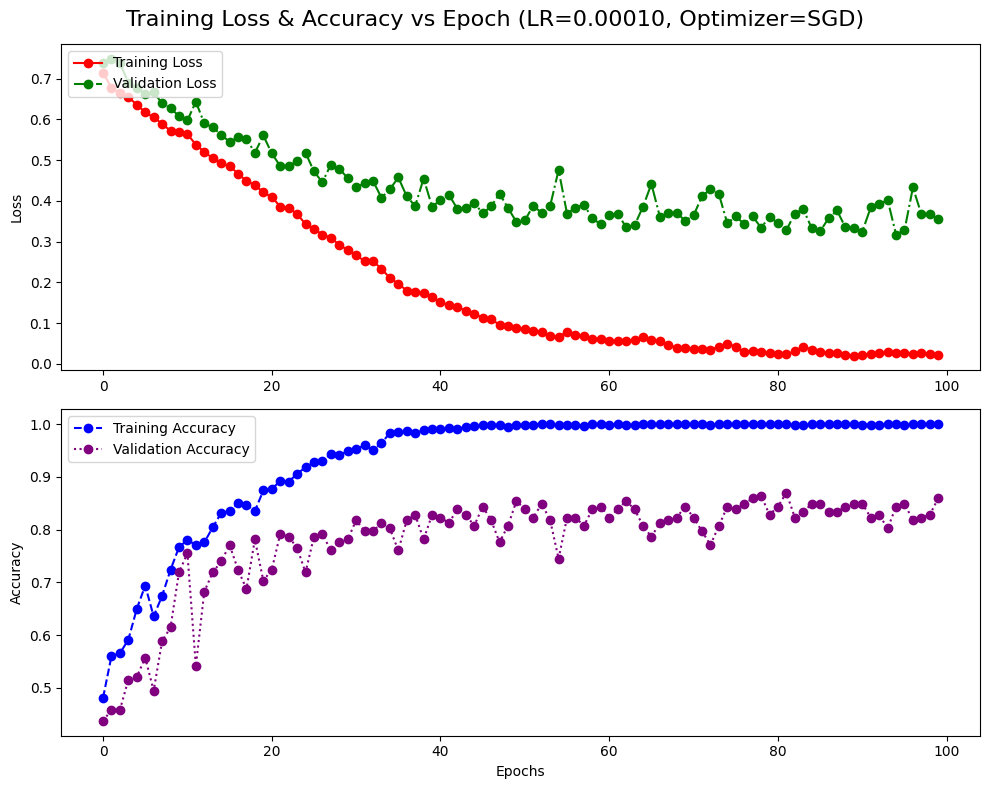

Entrenando con learning_rate=0.00010, epochs=100, optimizer=Adam


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.695201037613489
Epoch 1 Training Loss = 0.5461133474969678
Epoch 1 Validation Accuracy = 0.7083333333333334
Epoch 1 Validation Loss = 0.5763180156548818
La mejor precisión de Validation Loss (0.5763180156548818) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.9234760051880675
Epoch 2 Training Loss = 0.21054061172691918
Epoch 2 Validation Accuracy = 0.796875
Epoch 2 Validation Loss = 0.4883129894733429
La mejor precisión de Validation Loss (0.4883129894733429) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.980544747081712
Epoch 3 Training Loss = 0.08629446672867554
Epoch 3 Validation Accuracy = 0.7916666666666666
Epoch 3 Validation Loss = 0.520119865735372
La mejor precisión de Validation Loss (0.4883129894733429) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.9675745784695201
Epoch 4 Training Loss = 0.1279768582660555
Epoch 4 Validation Accuracy = 0.7760416666666666
Epoch 4 Validation Loss = 0.5718560516834259
La mejor precisión de Validation Loss (0.4883129894733429) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.9896238651102465
Epoch 5 Training Loss = 0.04435676965444565
Epoch 5 Validation Accuracy = 0.8645833333333334
Epoch 5 Validation Loss = 0.3723050008217494
La mejor precisión de Validation Loss (0.3723050008217494) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.9987029831387808
Epoch 6 Training Loss = 0.013834936086489455
Epoch 6 Validation Accuracy = 0.8697916666666666
Epoch 6 Validation Loss = 0.3663891851902008
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.9987029831387808
Epoch 7 Training Loss = 0.007854927171760959
Epoch 7 Validation Accuracy = 0.875
Epoch 7 Validation Loss = 0.3923836549123128
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.9961089494163424
Epoch 8 Training Loss = 0.01762611819998918
Epoch 8 Validation Accuracy = 0.8125
Epoch 8 Validation Loss = 0.5327375531196594
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.980544747081712
Epoch 9 Training Loss = 0.06896365948997428
Epoch 9 Validation Accuracy = 0.8385416666666666
Epoch 9 Validation Loss = 0.44890735546747845
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9727626459143969
Epoch 10 Training Loss = 0.08554411583837368
Epoch 10 Validation Accuracy = 0.84375
Epoch 10 Validation Loss = 0.5001406371593475
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9740596627756161
Epoch 11 Training Loss = 0.08548411854510178
Epoch 11 Validation Accuracy = 0.7760416666666666
Epoch 11 Validation Loss = 0.6305844585100809
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9870298313878081
Epoch 12 Training Loss = 0.06851388231866863
Epoch 12 Validation Accuracy = 0.8385416666666666
Epoch 12 Validation Loss = 0.4141986717780431
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9922178988326849
Epoch 13 Training Loss = 0.043404964234887704
Epoch 13 Validation Accuracy = 0.8645833333333334
Epoch 13 Validation Loss = 0.4043070872624715
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9909208819714657
Epoch 14 Training Loss = 0.0422418019365901
Epoch 14 Validation Accuracy = 0.8020833333333334
Epoch 14 Validation Loss = 0.5433738529682159
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9909208819714657
Epoch 15 Training Loss = 0.03355587127916853
Epoch 15 Validation Accuracy = 0.8802083333333334
Epoch 15 Validation Loss = 0.412733534971873
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.9974059662775616
Epoch 16 Training Loss = 0.015151617128097594
Epoch 16 Validation Accuracy = 0.8177083333333334
Epoch 16 Validation Loss = 0.42054498195648193
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9442282749675746
Epoch 17 Training Loss = 0.1665599002574127
Epoch 17 Validation Accuracy = 0.8333333333333334
Epoch 17 Validation Loss = 0.5503519872824351
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9649805447470817
Epoch 18 Training Loss = 0.07461681832763549
Epoch 18 Validation Accuracy = 0.8333333333333334
Epoch 18 Validation Loss = 0.4095549335082372
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9974059662775616
Epoch 19 Training Loss = 0.02266227021564557
Epoch 19 Validation Accuracy = 0.8333333333333334
Epoch 19 Validation Loss = 0.3950254023075104
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9987029831387808
Epoch 20 Training Loss = 0.009886105004915468
Epoch 20 Validation Accuracy = 0.875
Epoch 20 Validation Loss = 0.3820236027240753
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9922178988326849
Epoch 21 Training Loss = 0.03800828231017839
Epoch 21 Validation Accuracy = 0.84375
Epoch 21 Validation Loss = 0.47056029240290326
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.9987029831387808
Epoch 22 Training Loss = 0.014780333601469815
Epoch 22 Validation Accuracy = 0.8802083333333334
Epoch 22 Validation Loss = 0.41286460558573407
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9987029831387808
Epoch 23 Training Loss = 0.006277732772679562
Epoch 23 Validation Accuracy = 0.8854166666666666
Epoch 23 Validation Loss = 0.3733914991219838
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 1.0
Epoch 24 Training Loss = 0.006238855619645459
Epoch 24 Validation Accuracy = 0.875
Epoch 24 Validation Loss = 0.3862614780664444
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 1.0
Epoch 25 Training Loss = 0.002646999245046864
Epoch 25 Validation Accuracy = 0.8958333333333334
Epoch 25 Validation Loss = 0.39071858922640484
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 1.0
Epoch 26 Training Loss = 0.0021940928735273823
Epoch 26 Validation Accuracy = 0.8958333333333334
Epoch 26 Validation Loss = 0.40949098269144696
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 1.0
Epoch 27 Training Loss = 0.0022718581623469036
Epoch 27 Validation Accuracy = 0.9010416666666666
Epoch 27 Validation Loss = 0.49842927356561023
La mejor precisión de Validation Loss (0.3663891851902008) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9987029831387808
Epoch 28 Training Loss = 0.006115937564883202
Epoch 28 Validation Accuracy = 0.9010416666666666
Epoch 28 Validation Loss = 0.34433408578236896
La mejor precisión de Validation Loss (0.34433408578236896) se alcanzó en la época 28


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 1.0
Epoch 29 Training Loss = 0.0023587248185420007
Epoch 29 Validation Accuracy = 0.9114583333333334
Epoch 29 Validation Loss = 0.32165588935216266
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9961089494163424
Epoch 30 Training Loss = 0.011055543120037257
Epoch 30 Validation Accuracy = 0.8489583333333334
Epoch 30 Validation Loss = 0.6242499550183614
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.980544747081712
Epoch 31 Training Loss = 0.06324443993208165
Epoch 31 Validation Accuracy = 0.8333333333333334
Epoch 31 Validation Loss = 0.5846754511197408
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9883268482490273
Epoch 32 Training Loss = 0.0353355234568569
Epoch 32 Validation Accuracy = 0.8541666666666666
Epoch 32 Validation Loss = 0.4831143567959468
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9987029831387808
Epoch 33 Training Loss = 0.009433555627718415
Epoch 33 Validation Accuracy = 0.8802083333333334
Epoch 33 Validation Loss = 0.4458471934000651
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 1.0
Epoch 34 Training Loss = 0.0032642230683824123
Epoch 34 Validation Accuracy = 0.8802083333333334
Epoch 34 Validation Loss = 0.4214748442173004
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 1.0
Epoch 35 Training Loss = 0.0016637888181218986
Epoch 35 Validation Accuracy = 0.8802083333333334
Epoch 35 Validation Loss = 0.42094815398255986
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 1.0
Epoch 36 Training Loss = 0.002325286926887688
Epoch 36 Validation Accuracy = 0.9010416666666666
Epoch 36 Validation Loss = 0.42879637082417804
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 1.0
Epoch 37 Training Loss = 0.0017101645141105553
Epoch 37 Validation Accuracy = 0.8489583333333334
Epoch 37 Validation Loss = 0.5096853822469711
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9987029831387808
Epoch 38 Training Loss = 0.002648919782131408
Epoch 38 Validation Accuracy = 0.890625
Epoch 38 Validation Loss = 0.4410334676504135
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9987029831387808
Epoch 39 Training Loss = 0.0062182054949262095
Epoch 39 Validation Accuracy = 0.8697916666666666
Epoch 39 Validation Loss = 0.512121836344401
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 1.0
Epoch 40 Training Loss = 0.0013213249143266183
Epoch 40 Validation Accuracy = 0.875
Epoch 40 Validation Loss = 0.4964875777562459
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.993514915693904
Epoch 41 Training Loss = 0.02339744070682544
Epoch 41 Validation Accuracy = 0.8125
Epoch 41 Validation Loss = 0.7287202676137289
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9753566796368353
Epoch 42 Training Loss = 0.06699066794683961
Epoch 42 Validation Accuracy = 0.609375
Epoch 42 Validation Loss = 2.194100499153137
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9273670557717251
Epoch 43 Training Loss = 0.20343499204528007
Epoch 43 Validation Accuracy = 0.7395833333333334
Epoch 43 Validation Loss = 0.8031531373659769
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9118028534370947
Epoch 44 Training Loss = 0.24275369781411305
Epoch 44 Validation Accuracy = 0.8020833333333334
Epoch 44 Validation Loss = 0.733384758234024
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9636835278858625
Epoch 45 Training Loss = 0.09422386697603416
Epoch 45 Validation Accuracy = 0.8385416666666666
Epoch 45 Validation Loss = 0.6782704790433248
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9701686121919585
Epoch 46 Training Loss = 0.08782353007704069
Epoch 46 Validation Accuracy = 0.84375
Epoch 46 Validation Loss = 0.547531247138977
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9883268482490273
Epoch 47 Training Loss = 0.03255795640085767
Epoch 47 Validation Accuracy = 0.8802083333333334
Epoch 47 Validation Loss = 0.4694371223449707
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9948119325551232
Epoch 48 Training Loss = 0.04069362717907726
Epoch 48 Validation Accuracy = 0.8177083333333334
Epoch 48 Validation Loss = 0.6806757648785909
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9961089494163424
Epoch 49 Training Loss = 0.017861367154977586
Epoch 49 Validation Accuracy = 0.8541666666666666
Epoch 49 Validation Loss = 0.398938109477361
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9974059662775616
Epoch 50 Training Loss = 0.00919923165042422
Epoch 50 Validation Accuracy = 0.8385416666666666
Epoch 50 Validation Loss = 0.5268865426381429
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9662775616083009
Epoch 51 Training Loss = 0.08914120033402696
Epoch 51 Validation Accuracy = 0.8645833333333334
Epoch 51 Validation Loss = 0.6245621840159098
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9351491569390402
Epoch 52 Training Loss = 0.19207193748844273
Epoch 52 Validation Accuracy = 0.7239583333333334
Epoch 52 Validation Loss = 0.9295190175374349
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9753566796368353
Epoch 53 Training Loss = 0.08570285962867984
Epoch 53 Validation Accuracy = 0.8541666666666666
Epoch 53 Validation Loss = 0.48467751344045
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9494163424124513
Epoch 54 Training Loss = 0.16118765533231344
Epoch 54 Validation Accuracy = 0.8333333333333334
Epoch 54 Validation Loss = 0.4741859436035156
La mejor precisión de Validation Loss (0.32165588935216266) se alcanzó en la época 29


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9792477302204928
Epoch 55 Training Loss = 0.08076624740422468
Epoch 55 Validation Accuracy = 0.8697916666666666
Epoch 55 Validation Loss = 0.31265467902024585
La mejor precisión de Validation Loss (0.31265467902024585) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9766536964980544
Epoch 56 Training Loss = 0.07592033319436159
Epoch 56 Validation Accuracy = 0.8125
Epoch 56 Validation Loss = 0.6587900916735331
La mejor precisión de Validation Loss (0.31265467902024585) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9494163424124513
Epoch 57 Training Loss = 0.19228154967325206
Epoch 57 Validation Accuracy = 0.859375
Epoch 57 Validation Loss = 0.3969533344109853
La mejor precisión de Validation Loss (0.31265467902024585) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9740596627756161
Epoch 58 Training Loss = 0.07952917774054481
Epoch 58 Validation Accuracy = 0.8802083333333334
Epoch 58 Validation Loss = 0.3422469099362691
La mejor precisión de Validation Loss (0.31265467902024585) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.980544747081712
Epoch 59 Training Loss = 0.0710089550717177
Epoch 59 Validation Accuracy = 0.8385416666666666
Epoch 59 Validation Loss = 0.34391651550928753
La mejor precisión de Validation Loss (0.31265467902024585) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9948119325551232
Epoch 60 Training Loss = 0.03360028174885787
Epoch 60 Validation Accuracy = 0.8854166666666666
Epoch 60 Validation Loss = 0.3091498961051305
La mejor precisión de Validation Loss (0.3091498961051305) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9987029831387808
Epoch 61 Training Loss = 0.015648169614538916
Epoch 61 Validation Accuracy = 0.8697916666666666
Epoch 61 Validation Loss = 0.3464508255322774
La mejor precisión de Validation Loss (0.3091498961051305) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 1.0
Epoch 62 Training Loss = 0.008970927007390057
Epoch 62 Validation Accuracy = 0.875
Epoch 62 Validation Loss = 0.3435495098431905
La mejor precisión de Validation Loss (0.3091498961051305) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9974059662775616
Epoch 63 Training Loss = 0.014685392573031315
Epoch 63 Validation Accuracy = 0.8489583333333334
Epoch 63 Validation Loss = 0.4060175071159999
La mejor precisión de Validation Loss (0.3091498961051305) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9818417639429312
Epoch 64 Training Loss = 0.058320773521440654
Epoch 64 Validation Accuracy = 0.8541666666666666
Epoch 64 Validation Loss = 0.40724026163419086
La mejor precisión de Validation Loss (0.3091498961051305) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9636835278858625
Epoch 65 Training Loss = 0.10161506738779455
Epoch 65 Validation Accuracy = 0.8229166666666666
Epoch 65 Validation Loss = 0.4477948347727458
La mejor precisión de Validation Loss (0.3091498961051305) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9922178988326849
Epoch 66 Training Loss = 0.0455690073441284
Epoch 66 Validation Accuracy = 0.890625
Epoch 66 Validation Loss = 0.35473547875881195
La mejor precisión de Validation Loss (0.3091498961051305) se alcanzó en la época 60


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9948119325551232
Epoch 67 Training Loss = 0.0334051716033896
Epoch 67 Validation Accuracy = 0.9010416666666666
Epoch 67 Validation Loss = 0.30676307280858356
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9649805447470817
Epoch 68 Training Loss = 0.10422467526492944
Epoch 68 Validation Accuracy = 0.8697916666666666
Epoch 68 Validation Loss = 0.36156800389289856
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.993514915693904
Epoch 69 Training Loss = 0.034462866817278504
Epoch 69 Validation Accuracy = 0.8541666666666666
Epoch 69 Validation Loss = 0.38321055471897125
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9987029831387808
Epoch 70 Training Loss = 0.014220647451053487
Epoch 70 Validation Accuracy = 0.8541666666666666
Epoch 70 Validation Loss = 0.39321858684221905
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9987029831387808
Epoch 71 Training Loss = 0.008174132557308613
Epoch 71 Validation Accuracy = 0.8854166666666666
Epoch 71 Validation Loss = 0.3563283681869507
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 1.0
Epoch 72 Training Loss = 0.005904034702964948
Epoch 72 Validation Accuracy = 0.8854166666666666
Epoch 72 Validation Loss = 0.345261017481486
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 1.0
Epoch 73 Training Loss = 0.0036220769624403363
Epoch 73 Validation Accuracy = 0.8854166666666666
Epoch 73 Validation Loss = 0.3496410648028056
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 1.0
Epoch 74 Training Loss = 0.0041090004087513945
Epoch 74 Validation Accuracy = 0.8802083333333334
Epoch 74 Validation Loss = 0.34717849890391034
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 1.0
Epoch 75 Training Loss = 0.00282100766375371
Epoch 75 Validation Accuracy = 0.875
Epoch 75 Validation Loss = 0.33499014377593994
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 1.0
Epoch 76 Training Loss = 0.0020086875586406883
Epoch 76 Validation Accuracy = 0.875
Epoch 76 Validation Loss = 0.3465416431427002
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9974059662775616
Epoch 77 Training Loss = 0.011883624555149276
Epoch 77 Validation Accuracy = 0.8177083333333334
Epoch 77 Validation Loss = 0.5478236873944601
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9520103761348897
Epoch 78 Training Loss = 0.12650019255129744
Epoch 78 Validation Accuracy = 0.8333333333333334
Epoch 78 Validation Loss = 0.5526749988396963
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.959792477302205
Epoch 79 Training Loss = 0.09821377151516471
Epoch 79 Validation Accuracy = 0.8489583333333334
Epoch 79 Validation Loss = 0.39940444628397626
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9714656290531777
Epoch 80 Training Loss = 0.0949668211695749
Epoch 80 Validation Accuracy = 0.8541666666666666
Epoch 80 Validation Loss = 0.5334695180257162
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.9636835278858625
Epoch 81 Training Loss = 0.10446922140179055
Epoch 81 Validation Accuracy = 0.71875
Epoch 81 Validation Loss = 0.7407309810320536
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9909208819714657
Epoch 82 Training Loss = 0.0340900865060926
Epoch 82 Validation Accuracy = 0.8541666666666666
Epoch 82 Validation Loss = 0.4146934549013774
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9974059662775616
Epoch 83 Training Loss = 0.012088937791796393
Epoch 83 Validation Accuracy = 0.8958333333333334
Epoch 83 Validation Loss = 0.3875514715909958
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9987029831387808
Epoch 84 Training Loss = 0.007849889120084611
Epoch 84 Validation Accuracy = 0.8854166666666666
Epoch 84 Validation Loss = 0.4681044320265452
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.980544747081712
Epoch 85 Training Loss = 0.06463669935282411
Epoch 85 Validation Accuracy = 0.8697916666666666
Epoch 85 Validation Loss = 0.5690384904543558
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.993514915693904
Epoch 86 Training Loss = 0.029131744970143536
Epoch 86 Validation Accuracy = 0.890625
Epoch 86 Validation Loss = 0.4045190413792928
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9727626459143969
Epoch 87 Training Loss = 0.07884681432981445
Epoch 87 Validation Accuracy = 0.8489583333333334
Epoch 87 Validation Loss = 0.4983317752679189
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9922178988326849
Epoch 88 Training Loss = 0.03918665558843838
Epoch 88 Validation Accuracy = 0.8385416666666666
Epoch 88 Validation Loss = 0.4828410744667053
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9974059662775616
Epoch 89 Training Loss = 0.014966069532397666
Epoch 89 Validation Accuracy = 0.859375
Epoch 89 Validation Loss = 0.4602962036927541
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 1.0
Epoch 90 Training Loss = 0.006688511999258735
Epoch 90 Validation Accuracy = 0.8645833333333334
Epoch 90 Validation Loss = 0.44936099648475647
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 1.0
Epoch 91 Training Loss = 0.0037669201300572484
Epoch 91 Validation Accuracy = 0.8541666666666666
Epoch 91 Validation Loss = 0.45150184631347656
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 1.0
Epoch 92 Training Loss = 0.0037400622594855174
Epoch 92 Validation Accuracy = 0.8697916666666666
Epoch 92 Validation Loss = 0.44923733671506244
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 1.0
Epoch 93 Training Loss = 0.002983889774444734
Epoch 93 Validation Accuracy = 0.8697916666666666
Epoch 93 Validation Loss = 0.43998263279596966
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9987029831387808
Epoch 94 Training Loss = 0.010928939955475728
Epoch 94 Validation Accuracy = 0.7916666666666666
Epoch 94 Validation Loss = 0.6708737214406332
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9662775616083009
Epoch 95 Training Loss = 0.12740667649434853
Epoch 95 Validation Accuracy = 0.8177083333333334
Epoch 95 Validation Loss = 0.5476224223772684
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.980544747081712
Epoch 96 Training Loss = 0.07501579954466467
Epoch 96 Validation Accuracy = 0.84375
Epoch 96 Validation Loss = 0.41410860419273376
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9831387808041504
Epoch 97 Training Loss = 0.07168816679414608
Epoch 97 Validation Accuracy = 0.7083333333333334
Epoch 97 Validation Loss = 0.8238224188486735
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9922178988326849
Epoch 98 Training Loss = 0.048715725975973595
Epoch 98 Validation Accuracy = 0.8802083333333334
Epoch 98 Validation Loss = 0.4409702718257904
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9987029831387808
Epoch 99 Training Loss = 0.015693705901020386
Epoch 99 Validation Accuracy = 0.875
Epoch 99 Validation Loss = 0.4055989881356557
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9974059662775616
Epoch 100 Training Loss = 0.010980082605754046
Epoch 100 Validation Accuracy = 0.8958333333333334
Epoch 100 Validation Loss = 0.3595118323961894
La mejor precisión de Validation Loss (0.30676307280858356) se alcanzó en la época 67


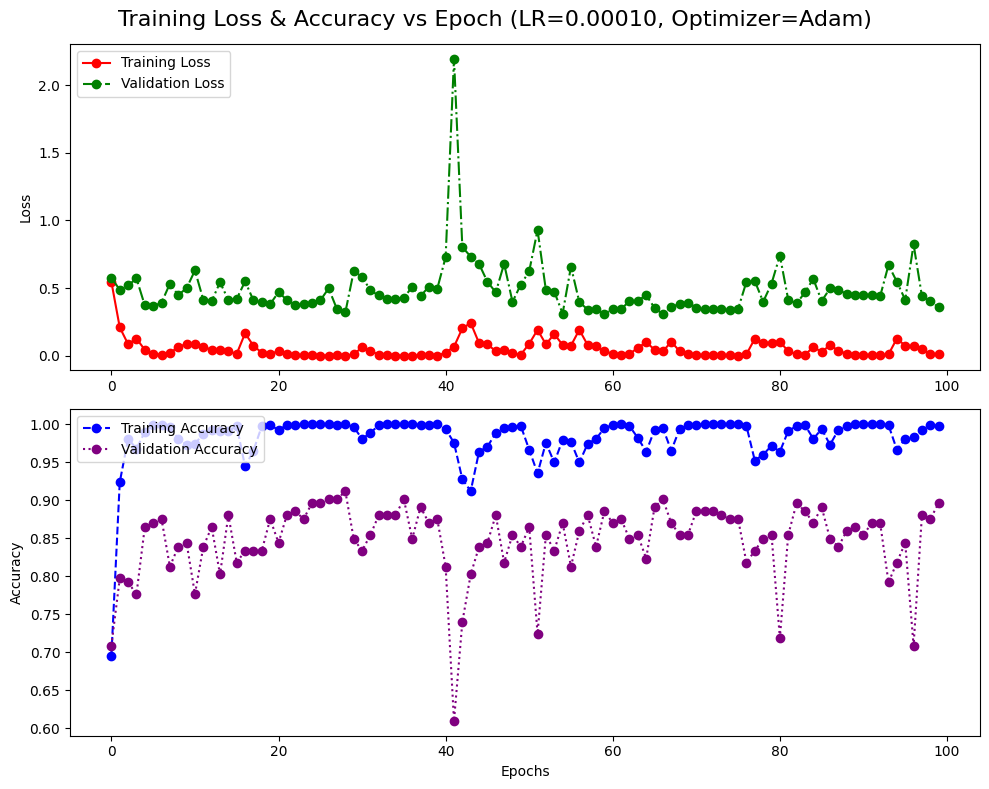

Entrenando con learning_rate=0.00010, epochs=100, optimizer=RMSprop


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.6134889753566797
Epoch 1 Training Loss = 0.7603193741055005
Epoch 1 Validation Accuracy = 0.6302083333333334
Epoch 1 Validation Loss = 0.8032213250796
La mejor precisión de Validation Loss (0.8032213250796) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.7380025940337225
Epoch 2 Training Loss = 0.4979178219956337
Epoch 2 Validation Accuracy = 0.7291666666666666
Epoch 2 Validation Loss = 0.5710841019948324
La mejor precisión de Validation Loss (0.5710841019948324) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.8586251621271076
Epoch 3 Training Loss = 0.3107150238002475
Epoch 3 Validation Accuracy = 0.625
Epoch 3 Validation Loss = 0.6827293435732523
La mejor precisión de Validation Loss (0.5710841019948324) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.9299610894941635
Epoch 4 Training Loss = 0.18452242700970126
Epoch 4 Validation Accuracy = 0.7135416666666666
Epoch 4 Validation Loss = 0.880083958307902
La mejor precisión de Validation Loss (0.5710841019948324) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.9494163424124513
Epoch 5 Training Loss = 0.14824254673587983
Epoch 5 Validation Accuracy = 0.484375
Epoch 5 Validation Loss = 5.172717571258545
La mejor precisión de Validation Loss (0.5710841019948324) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.9507133592736705
Epoch 6 Training Loss = 0.14946891701793547
Epoch 6 Validation Accuracy = 0.5416666666666666
Epoch 6 Validation Loss = 1.7026683886845906
La mejor precisión de Validation Loss (0.5710841019948324) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.9688715953307393
Epoch 7 Training Loss = 0.09407135554324791
Epoch 7 Validation Accuracy = 0.7135416666666666
Epoch 7 Validation Loss = 0.984382708867391
La mejor precisión de Validation Loss (0.5710841019948324) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.9701686121919585
Epoch 8 Training Loss = 0.07607698693736209
Epoch 8 Validation Accuracy = 0.796875
Epoch 8 Validation Loss = 0.8388275702794393
La mejor precisión de Validation Loss (0.5710841019948324) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.9364461738002594
Epoch 9 Training Loss = 0.16875307966868033
Epoch 9 Validation Accuracy = 0.8385416666666666
Epoch 9 Validation Loss = 0.40414108832677204
La mejor precisión de Validation Loss (0.40414108832677204) se alcanzó en la época 9


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9974059662775616
Epoch 10 Training Loss = 0.023164550427120328
Epoch 10 Validation Accuracy = 0.859375
Epoch 10 Validation Loss = 0.3798837463061015
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9987029831387808
Epoch 11 Training Loss = 0.01314028144793539
Epoch 11 Validation Accuracy = 0.8489583333333334
Epoch 11 Validation Loss = 0.38165584703286487
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9974059662775616
Epoch 12 Training Loss = 0.012203274128038132
Epoch 12 Validation Accuracy = 0.625
Epoch 12 Validation Loss = 1.1314066648483276
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9221789883268483
Epoch 13 Training Loss = 0.2588926154719098
Epoch 13 Validation Accuracy = 0.8385416666666666
Epoch 13 Validation Loss = 0.5378713607788086
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9922178988326849
Epoch 14 Training Loss = 0.035695121214083664
Epoch 14 Validation Accuracy = 0.828125
Epoch 14 Validation Loss = 0.5172702173391978
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9909208819714657
Epoch 15 Training Loss = 0.03770515373297973
Epoch 15 Validation Accuracy = 0.859375
Epoch 15 Validation Loss = 0.4716068108876546
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.9961089494163424
Epoch 16 Training Loss = 0.020511330584916932
Epoch 16 Validation Accuracy = 0.53125
Epoch 16 Validation Loss = 3.5055243174235025
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9364461738002594
Epoch 17 Training Loss = 0.23521259372532077
Epoch 17 Validation Accuracy = 0.796875
Epoch 17 Validation Loss = 0.46847598751386005
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.9740596627756161
Epoch 18 Training Loss = 0.0544012468767228
Epoch 18 Validation Accuracy = 0.4791666666666667
Epoch 18 Validation Loss = 8.410981019337973
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9584954604409858
Epoch 19 Training Loss = 0.10709879967781454
Epoch 19 Validation Accuracy = 0.7760416666666666
Epoch 19 Validation Loss = 0.5925987462202708
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9909208819714657
Epoch 20 Training Loss = 0.03318658860608085
Epoch 20 Validation Accuracy = 0.828125
Epoch 20 Validation Loss = 0.4281945725282033
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.9961089494163424
Epoch 21 Training Loss = 0.018892667908432872
Epoch 21 Validation Accuracy = 0.8385416666666666
Epoch 21 Validation Loss = 0.4336907962958018
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 1.0
Epoch 22 Training Loss = 0.009673616050436958
Epoch 22 Validation Accuracy = 0.6041666666666666
Epoch 22 Validation Loss = 5.017513672510783
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.9857328145265889
Epoch 23 Training Loss = 0.05881537521610111
Epoch 23 Validation Accuracy = 0.8333333333333334
Epoch 23 Validation Loss = 0.44091760118802387
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9974059662775616
Epoch 24 Training Loss = 0.008641388726296283
Epoch 24 Validation Accuracy = 0.8020833333333334
Epoch 24 Validation Loss = 1.3151333729426067
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.9831387808041504
Epoch 25 Training Loss = 0.06715277326323488
Epoch 25 Validation Accuracy = 0.5729166666666666
Epoch 25 Validation Loss = 1.506419579188029
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9818417639429312
Epoch 26 Training Loss = 0.07021660045581724
Epoch 26 Validation Accuracy = 0.5104166666666666
Epoch 26 Validation Loss = 1.7938317855199177
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.9351491569390402
Epoch 27 Training Loss = 0.18111935670423562
Epoch 27 Validation Accuracy = 0.7239583333333334
Epoch 27 Validation Loss = 0.7626750071843466
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9974059662775616
Epoch 28 Training Loss = 0.02435759517778528
Epoch 28 Validation Accuracy = 0.59375
Epoch 28 Validation Loss = 1.5259797970453899
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9714656290531777
Epoch 29 Training Loss = 0.0894865100640422
Epoch 29 Validation Accuracy = 0.734375
Epoch 29 Validation Loss = 1.3748107353846233
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9883268482490273
Epoch 30 Training Loss = 0.03886255927277601
Epoch 30 Validation Accuracy = 0.8645833333333334
Epoch 30 Validation Loss = 0.4641566773255666
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 1.0
Epoch 31 Training Loss = 0.006777051237717406
Epoch 31 Validation Accuracy = 0.8541666666666666
Epoch 31 Validation Loss = 0.45549824833869934
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 1.0
Epoch 32 Training Loss = 0.003733742724706681
Epoch 32 Validation Accuracy = 0.8541666666666666
Epoch 32 Validation Loss = 0.46338815490404767
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 1.0
Epoch 33 Training Loss = 0.008419630705981711
Epoch 33 Validation Accuracy = 0.8645833333333334
Epoch 33 Validation Loss = 0.5043239593505859
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 1.0
Epoch 34 Training Loss = 0.0028874839036381198
Epoch 34 Validation Accuracy = 0.5416666666666666
Epoch 34 Validation Loss = 7.626701990763347
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9520103761348897
Epoch 35 Training Loss = 0.17131217069991522
Epoch 35 Validation Accuracy = 0.8489583333333334
Epoch 35 Validation Loss = 0.4278572003046672
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9974059662775616
Epoch 36 Training Loss = 0.01566528497039112
Epoch 36 Validation Accuracy = 0.6510416666666666
Epoch 36 Validation Loss = 1.4425225257873535
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.980544747081712
Epoch 37 Training Loss = 0.08082028802112227
Epoch 37 Validation Accuracy = 0.71875
Epoch 37 Validation Loss = 1.0932395259539287
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9636835278858625
Epoch 38 Training Loss = 0.14313997001654133
Epoch 38 Validation Accuracy = 0.8489583333333334
Epoch 38 Validation Loss = 0.38681865731875104
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9974059662775616
Epoch 39 Training Loss = 0.020634138601531314
Epoch 39 Validation Accuracy = 0.8541666666666666
Epoch 39 Validation Loss = 0.5151874621709188
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9948119325551232
Epoch 40 Training Loss = 0.017622146263220933
Epoch 40 Validation Accuracy = 0.8854166666666666
Epoch 40 Validation Loss = 0.48599058389663696
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 1.0
Epoch 41 Training Loss = 0.006604575257912646
Epoch 41 Validation Accuracy = 0.875
Epoch 41 Validation Loss = 0.420374463001887
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 1.0
Epoch 42 Training Loss = 0.004877005959830782
Epoch 42 Validation Accuracy = 0.875
Epoch 42 Validation Loss = 0.4202571113904317
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 1.0
Epoch 43 Training Loss = 0.0022040122172320513
Epoch 43 Validation Accuracy = 0.8645833333333334
Epoch 43 Validation Loss = 0.4047760417064031
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 1.0
Epoch 44 Training Loss = 0.0019346512728020424
Epoch 44 Validation Accuracy = 0.8645833333333334
Epoch 44 Validation Loss = 0.39618221422036487
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 1.0
Epoch 45 Training Loss = 0.0016249386418849983
Epoch 45 Validation Accuracy = 0.8645833333333334
Epoch 45 Validation Loss = 0.41783273220062256
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9987029831387808
Epoch 46 Training Loss = 0.010391691590909365
Epoch 46 Validation Accuracy = 0.5104166666666666
Epoch 46 Validation Loss = 9.68664582570394
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9364461738002594
Epoch 47 Training Loss = 0.20010279329679664
Epoch 47 Validation Accuracy = 0.8385416666666666
Epoch 47 Validation Loss = 0.43681280811627704
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9948119325551232
Epoch 48 Training Loss = 0.02506872211448877
Epoch 48 Validation Accuracy = 0.859375
Epoch 48 Validation Loss = 0.4294234166542689
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 1.0
Epoch 49 Training Loss = 0.007781882810221572
Epoch 49 Validation Accuracy = 0.796875
Epoch 49 Validation Loss = 0.6226111451784769
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9948119325551232
Epoch 50 Training Loss = 0.019678451091862836
Epoch 50 Validation Accuracy = 0.640625
Epoch 50 Validation Loss = 1.5429177284240723
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9987029831387808
Epoch 51 Training Loss = 0.020205120097944843
Epoch 51 Validation Accuracy = 0.859375
Epoch 51 Validation Loss = 0.4632749656836192
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 1.0
Epoch 52 Training Loss = 0.0022301623055979553
Epoch 52 Validation Accuracy = 0.8645833333333334
Epoch 52 Validation Loss = 0.4548054536183675
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9987029831387808
Epoch 53 Training Loss = 0.006807309262522154
Epoch 53 Validation Accuracy = 0.5260416666666666
Epoch 53 Validation Loss = 2.8626445134480796
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9169909208819714
Epoch 54 Training Loss = 0.22687610485210494
Epoch 54 Validation Accuracy = 0.640625
Epoch 54 Validation Loss = 2.0475751161575317
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9662775616083009
Epoch 55 Training Loss = 0.11930139596669435
Epoch 55 Validation Accuracy = 0.4739583333333333
Epoch 55 Validation Loss = 15.234228134155273
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9636835278858625
Epoch 56 Training Loss = 0.1079302324240619
Epoch 56 Validation Accuracy = 0.78125
Epoch 56 Validation Loss = 0.7615166703859965
La mejor precisión de Validation Loss (0.3798837463061015) se alcanzó en la época 10


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9831387808041504
Epoch 57 Training Loss = 0.07304461105169799
Epoch 57 Validation Accuracy = 0.8697916666666666
Epoch 57 Validation Loss = 0.3748491207758586
La mejor precisión de Validation Loss (0.3748491207758586) se alcanzó en la época 57


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9961089494163424
Epoch 58 Training Loss = 0.034538328035187395
Epoch 58 Validation Accuracy = 0.8802083333333334
Epoch 58 Validation Loss = 0.32950423161188763
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9974059662775616
Epoch 59 Training Loss = 0.014930988771867505
Epoch 59 Validation Accuracy = 0.8489583333333334
Epoch 59 Validation Loss = 0.44628967841466266
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9948119325551232
Epoch 60 Training Loss = 0.01586336740105378
Epoch 60 Validation Accuracy = 0.4895833333333333
Epoch 60 Validation Loss = 3.8660851319630942
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9753566796368353
Epoch 61 Training Loss = 0.09703077397148588
Epoch 61 Validation Accuracy = 0.8125
Epoch 61 Validation Loss = 0.6915836234887441
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9948119325551232
Epoch 62 Training Loss = 0.0269748428957259
Epoch 62 Validation Accuracy = 0.859375
Epoch 62 Validation Loss = 0.4084203541278839
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 1.0
Epoch 63 Training Loss = 0.0054701275001044465
Epoch 63 Validation Accuracy = 0.8541666666666666
Epoch 63 Validation Loss = 0.41653310259183246
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9987029831387808
Epoch 64 Training Loss = 0.00774912172795579
Epoch 64 Validation Accuracy = 0.4739583333333333
Epoch 64 Validation Loss = 3.979774554570516
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9546044098573282
Epoch 65 Training Loss = 0.174547885362199
Epoch 65 Validation Accuracy = 0.8229166666666666
Epoch 65 Validation Loss = 0.6130971908569336
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9987029831387808
Epoch 66 Training Loss = 0.018506699931432145
Epoch 66 Validation Accuracy = 0.8854166666666666
Epoch 66 Validation Loss = 0.45218771199385327
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9974059662775616
Epoch 67 Training Loss = 0.008037613368992984
Epoch 67 Validation Accuracy = 0.71875
Epoch 67 Validation Loss = 2.156393130620321
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9688715953307393
Epoch 68 Training Loss = 0.1337961214757615
Epoch 68 Validation Accuracy = 0.8385416666666666
Epoch 68 Validation Loss = 0.5595013896624247
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9961089494163424
Epoch 69 Training Loss = 0.016804635625612838
Epoch 69 Validation Accuracy = 0.875
Epoch 69 Validation Loss = 0.5174445609251658
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 1.0
Epoch 70 Training Loss = 0.005978829269665843
Epoch 70 Validation Accuracy = 0.8229166666666666
Epoch 70 Validation Loss = 0.6168746550877889
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9909208819714657
Epoch 71 Training Loss = 0.04088205121331951
Epoch 71 Validation Accuracy = 0.8541666666666666
Epoch 71 Validation Loss = 0.5563980937004089
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9974059662775616
Epoch 72 Training Loss = 0.009688056360364888
Epoch 72 Validation Accuracy = 0.859375
Epoch 72 Validation Loss = 0.5957028269767761
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9974059662775616
Epoch 73 Training Loss = 0.013021906680788667
Epoch 73 Validation Accuracy = 0.4583333333333333
Epoch 73 Validation Loss = 8.777371406555176
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9714656290531777
Epoch 74 Training Loss = 0.0844926306671051
Epoch 74 Validation Accuracy = 0.7708333333333334
Epoch 74 Validation Loss = 0.7833529313405355
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9870298313878081
Epoch 75 Training Loss = 0.04010231310716708
Epoch 75 Validation Accuracy = 0.6302083333333334
Epoch 75 Validation Loss = 1.5520376761754353
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.993514915693904
Epoch 76 Training Loss = 0.01880486999504297
Epoch 76 Validation Accuracy = 0.8541666666666666
Epoch 76 Validation Loss = 0.6035323242346445
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9987029831387808
Epoch 77 Training Loss = 0.009113526072029397
Epoch 77 Validation Accuracy = 0.8802083333333334
Epoch 77 Validation Loss = 0.5698926051457723
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 1.0
Epoch 78 Training Loss = 0.0027892784835032674
Epoch 78 Validation Accuracy = 0.875
Epoch 78 Validation Loss = 0.5732327848672867
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 1.0
Epoch 79 Training Loss = 0.0023937858964271854
Epoch 79 Validation Accuracy = 0.8802083333333334
Epoch 79 Validation Loss = 0.5803323487440745
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 1.0
Epoch 80 Training Loss = 0.0019581735869515513
Epoch 80 Validation Accuracy = 0.8802083333333334
Epoch 80 Validation Loss = 0.6005418300628662
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 1.0
Epoch 81 Training Loss = 0.0017151729839137632
Epoch 81 Validation Accuracy = 0.890625
Epoch 81 Validation Loss = 0.5849799315134684
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 1.0
Epoch 82 Training Loss = 0.0013349691531065267
Epoch 82 Validation Accuracy = 0.875
Epoch 82 Validation Loss = 0.636504203081131
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 1.0
Epoch 83 Training Loss = 0.0016681956617710036
Epoch 83 Validation Accuracy = 0.609375
Epoch 83 Validation Loss = 2.383486191431681
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9481193255512321
Epoch 84 Training Loss = 0.1758029462453147
Epoch 84 Validation Accuracy = 0.5572916666666666
Epoch 84 Validation Loss = 3.0408507188161216
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9779507133592736
Epoch 85 Training Loss = 0.062491921729730726
Epoch 85 Validation Accuracy = 0.8385416666666666
Epoch 85 Validation Loss = 0.4402734637260437
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9987029831387808
Epoch 86 Training Loss = 0.01443078441016289
Epoch 86 Validation Accuracy = 0.828125
Epoch 86 Validation Loss = 0.4780288537343343
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 1.0
Epoch 87 Training Loss = 0.005177559835978829
Epoch 87 Validation Accuracy = 0.8645833333333334
Epoch 87 Validation Loss = 0.44567936658859253
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9987029831387808
Epoch 88 Training Loss = 0.006253896095100234
Epoch 88 Validation Accuracy = 0.8385416666666666
Epoch 88 Validation Loss = 0.5008993446826935
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 1.0
Epoch 89 Training Loss = 0.0031159771050673205
Epoch 89 Validation Accuracy = 0.8489583333333334
Epoch 89 Validation Loss = 0.536949892838796
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 1.0
Epoch 90 Training Loss = 0.003093371365579321
Epoch 90 Validation Accuracy = 0.84375
Epoch 90 Validation Loss = 0.5513263940811157
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 1.0
Epoch 91 Training Loss = 0.0022495560125772745
Epoch 91 Validation Accuracy = 0.625
Epoch 91 Validation Loss = 2.1613247791926065
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9948119325551232
Epoch 92 Training Loss = 0.028582175224826183
Epoch 92 Validation Accuracy = 0.8541666666666666
Epoch 92 Validation Loss = 0.5132056375344595
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 1.0
Epoch 93 Training Loss = 0.0025350867097789056
Epoch 93 Validation Accuracy = 0.8489583333333334
Epoch 93 Validation Loss = 0.5576870739459991
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9974059662775616
Epoch 94 Training Loss = 0.008140006693304745
Epoch 94 Validation Accuracy = 0.5989583333333334
Epoch 94 Validation Loss = 2.2245541413625083
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9559014267185474
Epoch 95 Training Loss = 0.1400158897274199
Epoch 95 Validation Accuracy = 0.8333333333333334
Epoch 95 Validation Loss = 0.5791107813517252
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.993514915693904
Epoch 96 Training Loss = 0.03154533792253289
Epoch 96 Validation Accuracy = 0.4635416666666667
Epoch 96 Validation Loss = 3.762337843577067
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9688715953307393
Epoch 97 Training Loss = 0.10318983374248064
Epoch 97 Validation Accuracy = 0.8020833333333334
Epoch 97 Validation Loss = 0.6749809583028158
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9870298313878081
Epoch 98 Training Loss = 0.06183677521593453
Epoch 98 Validation Accuracy = 0.8385416666666666
Epoch 98 Validation Loss = 0.5016505122184753
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9974059662775616
Epoch 99 Training Loss = 0.014206496876061698
Epoch 99 Validation Accuracy = 0.859375
Epoch 99 Validation Loss = 0.44253475964069366
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9987029831387808
Epoch 100 Training Loss = 0.009548877792290368
Epoch 100 Validation Accuracy = 0.671875
Epoch 100 Validation Loss = 1.3871910572052002
La mejor precisión de Validation Loss (0.32950423161188763) se alcanzó en la época 58


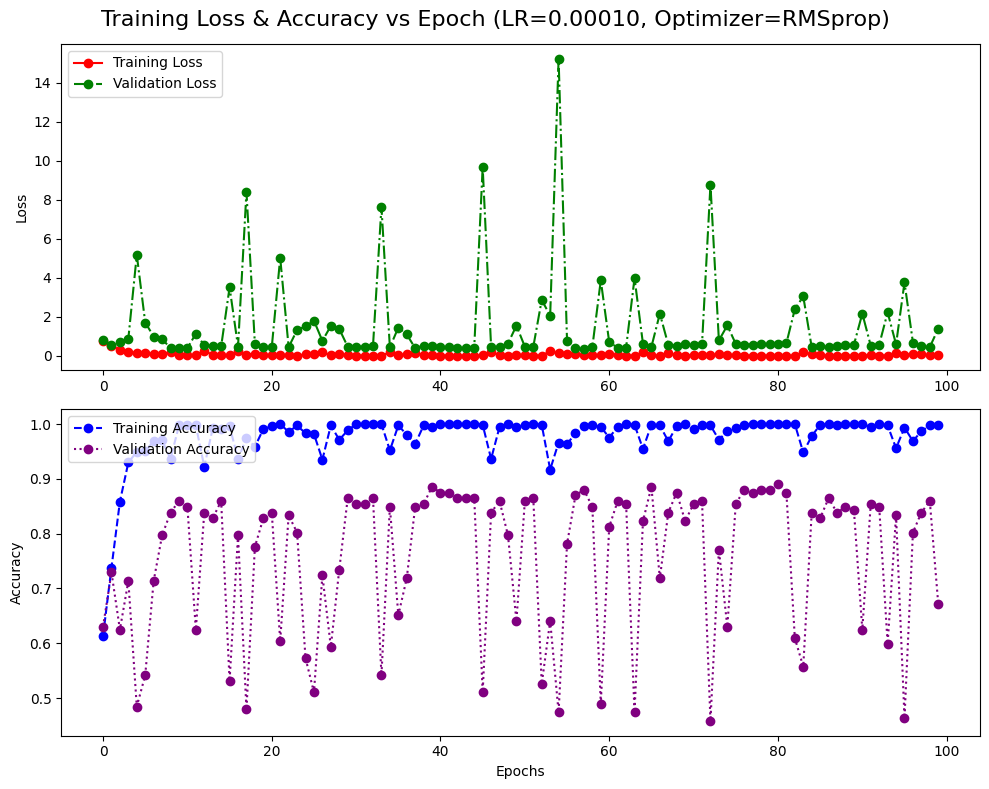

Entrenando con learning_rate=0.00100, epochs=100, optimizer=SGD


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5486381322957199
Epoch 1 Training Loss = 0.6708065570560411
Epoch 1 Validation Accuracy = 0.4791666666666667
Epoch 1 Validation Loss = 0.7036092281341553
La mejor precisión de Validation Loss (0.7036092281341553) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6653696498054474
Epoch 2 Training Loss = 0.6001193200645125
Epoch 2 Validation Accuracy = 0.578125
Epoch 2 Validation Loss = 0.6570325692494711
La mejor precisión de Validation Loss (0.6570325692494711) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.7367055771725033
Epoch 3 Training Loss = 0.5215172163088807
Epoch 3 Validation Accuracy = 0.7395833333333334
Epoch 3 Validation Loss = 0.5117056171099345
La mejor precisión de Validation Loss (0.5117056171099345) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.8664072632944229
Epoch 4 Training Loss = 0.3725985520544683
Epoch 4 Validation Accuracy = 0.7604166666666666
Epoch 4 Validation Loss = 0.49983983238538104
La mejor precisión de Validation Loss (0.49983983238538104) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.9053177691309987
Epoch 5 Training Loss = 0.303423694831388
Epoch 5 Validation Accuracy = 0.6458333333333334
Epoch 5 Validation Loss = 0.6556897362073263
La mejor precisión de Validation Loss (0.49983983238538104) se alcanzó en la época 4


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.9286640726329443
Epoch 6 Training Loss = 0.2270376048354014
Epoch 6 Validation Accuracy = 0.796875
Epoch 6 Validation Loss = 0.3766887883345286
La mejor precisión de Validation Loss (0.3766887883345286) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.9390402075226978
Epoch 7 Training Loss = 0.17178236069846245
Epoch 7 Validation Accuracy = 0.8385416666666666
Epoch 7 Validation Loss = 0.35263903935750324
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.9364461738002594
Epoch 8 Training Loss = 0.16835799237324262
Epoch 8 Validation Accuracy = 0.7708333333333334
Epoch 8 Validation Loss = 0.5027987062931061
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.9792477302204928
Epoch 9 Training Loss = 0.11100316890328156
Epoch 9 Validation Accuracy = 0.734375
Epoch 9 Validation Loss = 0.5417783260345459
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.9818417639429312
Epoch 10 Training Loss = 0.08511571684700042
Epoch 10 Validation Accuracy = 0.7916666666666666
Epoch 10 Validation Loss = 0.4656371474266052
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.9701686121919585
Epoch 11 Training Loss = 0.10281187949168234
Epoch 11 Validation Accuracy = 0.8072916666666666
Epoch 11 Validation Loss = 0.3713906904061635
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.9779507133592736
Epoch 12 Training Loss = 0.07723237050337241
Epoch 12 Validation Accuracy = 0.8229166666666666
Epoch 12 Validation Loss = 0.39583760499954224
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.9766536964980544
Epoch 13 Training Loss = 0.0877256271285615
Epoch 13 Validation Accuracy = 0.84375
Epoch 13 Validation Loss = 0.4321297307809194
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.9584954604409858
Epoch 14 Training Loss = 0.11910932734318744
Epoch 14 Validation Accuracy = 0.7708333333333334
Epoch 14 Validation Loss = 0.5165476898352305
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.9909208819714657
Epoch 15 Training Loss = 0.057352085740350174
Epoch 15 Validation Accuracy = 0.7708333333333334
Epoch 15 Validation Loss = 0.494509756565094
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.9974059662775616
Epoch 16 Training Loss = 0.02504806043568095
Epoch 16 Validation Accuracy = 0.8229166666666666
Epoch 16 Validation Loss = 0.4166853626569112
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.9987029831387808
Epoch 17 Training Loss = 0.016110582691502555
Epoch 17 Validation Accuracy = 0.84375
Epoch 17 Validation Loss = 0.3666555682818095
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 1.0
Epoch 18 Training Loss = 0.009502359092158257
Epoch 18 Validation Accuracy = 0.8333333333333334
Epoch 18 Validation Loss = 0.39029257496198017
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.9974059662775616
Epoch 19 Training Loss = 0.011954554942486042
Epoch 19 Validation Accuracy = 0.84375
Epoch 19 Validation Loss = 0.3860875566800435
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.9610894941634242
Epoch 20 Training Loss = 0.09576140887233224
Epoch 20 Validation Accuracy = 0.8072916666666666
Epoch 20 Validation Loss = 0.6289289395014445
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.953307392996109
Epoch 21 Training Loss = 0.11963167287960126
Epoch 21 Validation Accuracy = 0.8125
Epoch 21 Validation Loss = 0.5161696871121725
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.959792477302205
Epoch 22 Training Loss = 0.12535194602303312
Epoch 22 Validation Accuracy = 0.8125
Epoch 22 Validation Loss = 0.6043247580528259
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.980544747081712
Epoch 23 Training Loss = 0.07256119467086133
Epoch 23 Validation Accuracy = 0.8333333333333334
Epoch 23 Validation Loss = 0.46113792061805725
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.9922178988326849
Epoch 24 Training Loss = 0.027900323126798472
Epoch 24 Validation Accuracy = 0.8333333333333334
Epoch 24 Validation Loss = 0.4861437877019246
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.9974059662775616
Epoch 25 Training Loss = 0.014233498567118565
Epoch 25 Validation Accuracy = 0.8385416666666666
Epoch 25 Validation Loss = 0.4972338577111562
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.9727626459143969
Epoch 26 Training Loss = 0.06753149029017268
Epoch 26 Validation Accuracy = 0.8072916666666666
Epoch 26 Validation Loss = 0.5416399637858073
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.9961089494163424
Epoch 27 Training Loss = 0.025263422600026262
Epoch 27 Validation Accuracy = 0.8072916666666666
Epoch 27 Validation Loss = 0.624824732542038
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.9974059662775616
Epoch 28 Training Loss = 0.021768724311495877
Epoch 28 Validation Accuracy = 0.8333333333333334
Epoch 28 Validation Loss = 0.49327851335207623
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.9909208819714657
Epoch 29 Training Loss = 0.03510339219901039
Epoch 29 Validation Accuracy = 0.8229166666666666
Epoch 29 Validation Loss = 0.5582164724667867
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.9844357976653697
Epoch 30 Training Loss = 0.06884263670398104
Epoch 30 Validation Accuracy = 0.7291666666666666
Epoch 30 Validation Loss = 1.205937961737315
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.9571984435797666
Epoch 31 Training Loss = 0.11491902749478121
Epoch 31 Validation Accuracy = 0.8072916666666666
Epoch 31 Validation Loss = 0.6777632435162863
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.9922178988326849
Epoch 32 Training Loss = 0.033654681826070745
Epoch 32 Validation Accuracy = 0.8229166666666666
Epoch 32 Validation Loss = 0.5711073478062948
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9559014267185474
Epoch 33 Training Loss = 0.1366431576558588
Epoch 33 Validation Accuracy = 0.8020833333333334
Epoch 33 Validation Loss = 0.5940672159194946
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9766536964980544
Epoch 34 Training Loss = 0.06831668309224757
Epoch 34 Validation Accuracy = 0.78125
Epoch 34 Validation Loss = 0.5663764377435049
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9948119325551232
Epoch 35 Training Loss = 0.02761078041304149
Epoch 35 Validation Accuracy = 0.8177083333333334
Epoch 35 Validation Loss = 0.38385169704755145
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9987029831387808
Epoch 36 Training Loss = 0.010018150204968978
Epoch 36 Validation Accuracy = 0.8333333333333334
Epoch 36 Validation Loss = 0.383815735578537
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.9909208819714657
Epoch 37 Training Loss = 0.03545659536981397
Epoch 37 Validation Accuracy = 0.8333333333333334
Epoch 37 Validation Loss = 0.48317626118659973
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.9831387808041504
Epoch 38 Training Loss = 0.06085872014769475
Epoch 38 Validation Accuracy = 0.84375
Epoch 38 Validation Loss = 0.5067768096923828
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9961089494163424
Epoch 39 Training Loss = 0.0274512216876999
Epoch 39 Validation Accuracy = 0.828125
Epoch 39 Validation Loss = 0.4923497537771861
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.9987029831387808
Epoch 40 Training Loss = 0.018872293087396526
Epoch 40 Validation Accuracy = 0.8229166666666666
Epoch 40 Validation Loss = 0.4647655189037323
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9987029831387808
Epoch 41 Training Loss = 0.012307383560958462
Epoch 41 Validation Accuracy = 0.84375
Epoch 41 Validation Loss = 0.44246841470400494
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9974059662775616
Epoch 42 Training Loss = 0.00851019124963095
Epoch 42 Validation Accuracy = 0.84375
Epoch 42 Validation Loss = 0.45238152146339417
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9701686121919585
Epoch 43 Training Loss = 0.09020217559294323
Epoch 43 Validation Accuracy = 0.796875
Epoch 43 Validation Loss = 0.53706623117129
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9883268482490273
Epoch 44 Training Loss = 0.03443951945360533
Epoch 44 Validation Accuracy = 0.828125
Epoch 44 Validation Loss = 0.5540824631849924
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.980544747081712
Epoch 45 Training Loss = 0.05990998924319692
Epoch 45 Validation Accuracy = 0.8020833333333334
Epoch 45 Validation Loss = 0.877398411432902
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.993514915693904
Epoch 46 Training Loss = 0.028337328548599928
Epoch 46 Validation Accuracy = 0.8229166666666666
Epoch 46 Validation Loss = 0.7462416688601176
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9948119325551232
Epoch 47 Training Loss = 0.029804542206527347
Epoch 47 Validation Accuracy = 0.828125
Epoch 47 Validation Loss = 0.538813312848409
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9961089494163424
Epoch 48 Training Loss = 0.014724432069194611
Epoch 48 Validation Accuracy = 0.84375
Epoch 48 Validation Loss = 0.45585740605990094
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.993514915693904
Epoch 49 Training Loss = 0.02866151043722447
Epoch 49 Validation Accuracy = 0.84375
Epoch 49 Validation Loss = 0.43929845094680786
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9948119325551232
Epoch 50 Training Loss = 0.03203105356365481
Epoch 50 Validation Accuracy = 0.8177083333333334
Epoch 50 Validation Loss = 0.5334684252738953
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.9974059662775616
Epoch 51 Training Loss = 0.022533870238119834
Epoch 51 Validation Accuracy = 0.828125
Epoch 51 Validation Loss = 0.5260359545548757
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9909208819714657
Epoch 52 Training Loss = 0.027499035398968665
Epoch 52 Validation Accuracy = 0.8125
Epoch 52 Validation Loss = 0.7146504124005636
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9961089494163424
Epoch 53 Training Loss = 0.013336101925308876
Epoch 53 Validation Accuracy = 0.8177083333333334
Epoch 53 Validation Loss = 0.6463490923245748
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9987029831387808
Epoch 54 Training Loss = 0.006881081959384888
Epoch 54 Validation Accuracy = 0.8385416666666666
Epoch 54 Validation Loss = 0.542453408241272
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9740596627756161
Epoch 55 Training Loss = 0.051764755933781076
Epoch 55 Validation Accuracy = 0.8229166666666666
Epoch 55 Validation Loss = 0.599168082078298
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.9961089494163424
Epoch 56 Training Loss = 0.03618641709848446
Epoch 56 Validation Accuracy = 0.796875
Epoch 56 Validation Loss = 0.7548600832621256
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9559014267185474
Epoch 57 Training Loss = 0.12333039813777662
Epoch 57 Validation Accuracy = 0.8125
Epoch 57 Validation Loss = 0.4722074766953786
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9701686121919585
Epoch 58 Training Loss = 0.07641657069808623
Epoch 58 Validation Accuracy = 0.8229166666666666
Epoch 58 Validation Loss = 0.5040893157323202
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.980544747081712
Epoch 59 Training Loss = 0.05085765519185444
Epoch 59 Validation Accuracy = 0.7916666666666666
Epoch 59 Validation Loss = 0.6631280481815338
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.9844357976653697
Epoch 60 Training Loss = 0.05153252565134051
Epoch 60 Validation Accuracy = 0.796875
Epoch 60 Validation Loss = 0.5933457016944885
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9675745784695201
Epoch 61 Training Loss = 0.07617276435386965
Epoch 61 Validation Accuracy = 0.6302083333333334
Epoch 61 Validation Loss = 1.1229355931282043
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.9909208819714657
Epoch 62 Training Loss = 0.036168691481133844
Epoch 62 Validation Accuracy = 0.8229166666666666
Epoch 62 Validation Loss = 0.39765816926956177
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.9831387808041504
Epoch 63 Training Loss = 0.0550243975896625
Epoch 63 Validation Accuracy = 0.8177083333333334
Epoch 63 Validation Loss = 0.45013689001401264
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9844357976653697
Epoch 64 Training Loss = 0.04778517950108775
Epoch 64 Validation Accuracy = 0.7604166666666666
Epoch 64 Validation Loss = 0.6934545735518137
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9922178988326849
Epoch 65 Training Loss = 0.0391316596586523
Epoch 65 Validation Accuracy = 0.8333333333333334
Epoch 65 Validation Loss = 0.37027469277381897
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9987029831387808
Epoch 66 Training Loss = 0.011778714404207075
Epoch 66 Validation Accuracy = 0.859375
Epoch 66 Validation Loss = 0.35560286541779834
La mejor precisión de Validation Loss (0.35263903935750324) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 1.0
Epoch 67 Training Loss = 0.00639303640526479
Epoch 67 Validation Accuracy = 0.8854166666666666
Epoch 67 Validation Loss = 0.3184834321339925
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 1.0
Epoch 68 Training Loss = 0.007058453813784704
Epoch 68 Validation Accuracy = 0.8802083333333334
Epoch 68 Validation Loss = 0.322698454062144
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9987029831387808
Epoch 69 Training Loss = 0.006329259249332196
Epoch 69 Validation Accuracy = 0.859375
Epoch 69 Validation Loss = 0.38301463921864826
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9779507133592736
Epoch 70 Training Loss = 0.06767713772338342
Epoch 70 Validation Accuracy = 0.7760416666666666
Epoch 70 Validation Loss = 0.8073639472325643
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9766536964980544
Epoch 71 Training Loss = 0.08372259031783127
Epoch 71 Validation Accuracy = 0.8177083333333334
Epoch 71 Validation Loss = 0.5596305330594381
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9857328145265889
Epoch 72 Training Loss = 0.06082423458458076
Epoch 72 Validation Accuracy = 0.7916666666666666
Epoch 72 Validation Loss = 0.5353013873100281
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9753566796368353
Epoch 73 Training Loss = 0.07216998132068939
Epoch 73 Validation Accuracy = 0.859375
Epoch 73 Validation Loss = 0.37374826272328693
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9948119325551232
Epoch 74 Training Loss = 0.04088111274214957
Epoch 74 Validation Accuracy = 0.8697916666666666
Epoch 74 Validation Loss = 0.32228413224220276
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9948119325551232
Epoch 75 Training Loss = 0.022917450556649926
Epoch 75 Validation Accuracy = 0.8489583333333334
Epoch 75 Validation Loss = 0.32917775213718414
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9727626459143969
Epoch 76 Training Loss = 0.08454876488748692
Epoch 76 Validation Accuracy = 0.8802083333333334
Epoch 76 Validation Loss = 0.38049588600794476
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9896238651102465
Epoch 77 Training Loss = 0.038715659951774256
Epoch 77 Validation Accuracy = 0.8645833333333334
Epoch 77 Validation Loss = 0.4105594754219055
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9948119325551232
Epoch 78 Training Loss = 0.022115586236138598
Epoch 78 Validation Accuracy = 0.8645833333333334
Epoch 78 Validation Loss = 0.4947104255358378
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9844357976653697
Epoch 79 Training Loss = 0.050437344960510805
Epoch 79 Validation Accuracy = 0.8020833333333334
Epoch 79 Validation Loss = 0.48602451880772907
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.9922178988326849
Epoch 80 Training Loss = 0.05283747051495832
Epoch 80 Validation Accuracy = 0.8489583333333334
Epoch 80 Validation Loss = 0.4340832531452179
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.9922178988326849
Epoch 81 Training Loss = 0.037336762119978474
Epoch 81 Validation Accuracy = 0.828125
Epoch 81 Validation Loss = 0.3868402987718582
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9909208819714657
Epoch 82 Training Loss = 0.04074349171202992
Epoch 82 Validation Accuracy = 0.8177083333333334
Epoch 82 Validation Loss = 0.5013902882734934
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9961089494163424
Epoch 83 Training Loss = 0.030670474685037606
Epoch 83 Validation Accuracy = 0.8385416666666666
Epoch 83 Validation Loss = 0.36634473005930585
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9974059662775616
Epoch 84 Training Loss = 0.01706990680805904
Epoch 84 Validation Accuracy = 0.8125
Epoch 84 Validation Loss = 0.48711414635181427
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9675745784695201
Epoch 85 Training Loss = 0.09445537296492225
Epoch 85 Validation Accuracy = 0.765625
Epoch 85 Validation Loss = 0.7380292018254598
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9922178988326849
Epoch 86 Training Loss = 0.031105089137854897
Epoch 86 Validation Accuracy = 0.859375
Epoch 86 Validation Loss = 0.3999241292476654
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9974059662775616
Epoch 87 Training Loss = 0.012487357342796915
Epoch 87 Validation Accuracy = 0.8645833333333334
Epoch 87 Validation Loss = 0.36230146884918213
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9987029831387808
Epoch 88 Training Loss = 0.00962703029991124
Epoch 88 Validation Accuracy = 0.8645833333333334
Epoch 88 Validation Loss = 0.3357759714126587
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 1.0
Epoch 89 Training Loss = 0.005320571092393457
Epoch 89 Validation Accuracy = 0.8177083333333334
Epoch 89 Validation Loss = 0.46442654728889465
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.9974059662775616
Epoch 90 Training Loss = 0.009165395625918891
Epoch 90 Validation Accuracy = 0.8697916666666666
Epoch 90 Validation Loss = 0.33024786909421283
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9974059662775616
Epoch 91 Training Loss = 0.016719338775222248
Epoch 91 Validation Accuracy = 0.84375
Epoch 91 Validation Loss = 0.35836641987164813
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9844357976653697
Epoch 92 Training Loss = 0.0482628175894574
Epoch 92 Validation Accuracy = 0.890625
Epoch 92 Validation Loss = 0.41991926232973736
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9896238651102465
Epoch 93 Training Loss = 0.041847134578849844
Epoch 93 Validation Accuracy = 0.8854166666666666
Epoch 93 Validation Loss = 0.3859659830729167
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9987029831387808
Epoch 94 Training Loss = 0.010399243162628432
Epoch 94 Validation Accuracy = 0.8854166666666666
Epoch 94 Validation Loss = 0.38144612312316895
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9987029831387808
Epoch 95 Training Loss = 0.013101392702215222
Epoch 95 Validation Accuracy = 0.8697916666666666
Epoch 95 Validation Loss = 0.4203042984008789
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9792477302204928
Epoch 96 Training Loss = 0.07780779358941757
Epoch 96 Validation Accuracy = 0.8125
Epoch 96 Validation Loss = 0.736206034819285
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.9649805447470817
Epoch 97 Training Loss = 0.07782169043940483
Epoch 97 Validation Accuracy = 0.8177083333333334
Epoch 97 Validation Loss = 0.624205082654953
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9844357976653697
Epoch 98 Training Loss = 0.058241917697372136
Epoch 98 Validation Accuracy = 0.7604166666666666
Epoch 98 Validation Loss = 0.7542766133944193
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9818417639429312
Epoch 99 Training Loss = 0.077434182089745
Epoch 99 Validation Accuracy = 0.859375
Epoch 99 Validation Loss = 0.43251176675160724
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.9623865110246433
Epoch 100 Training Loss = 0.12345690689087108
Epoch 100 Validation Accuracy = 0.7916666666666666
Epoch 100 Validation Loss = 0.5642466048399607
La mejor precisión de Validation Loss (0.3184834321339925) se alcanzó en la época 67


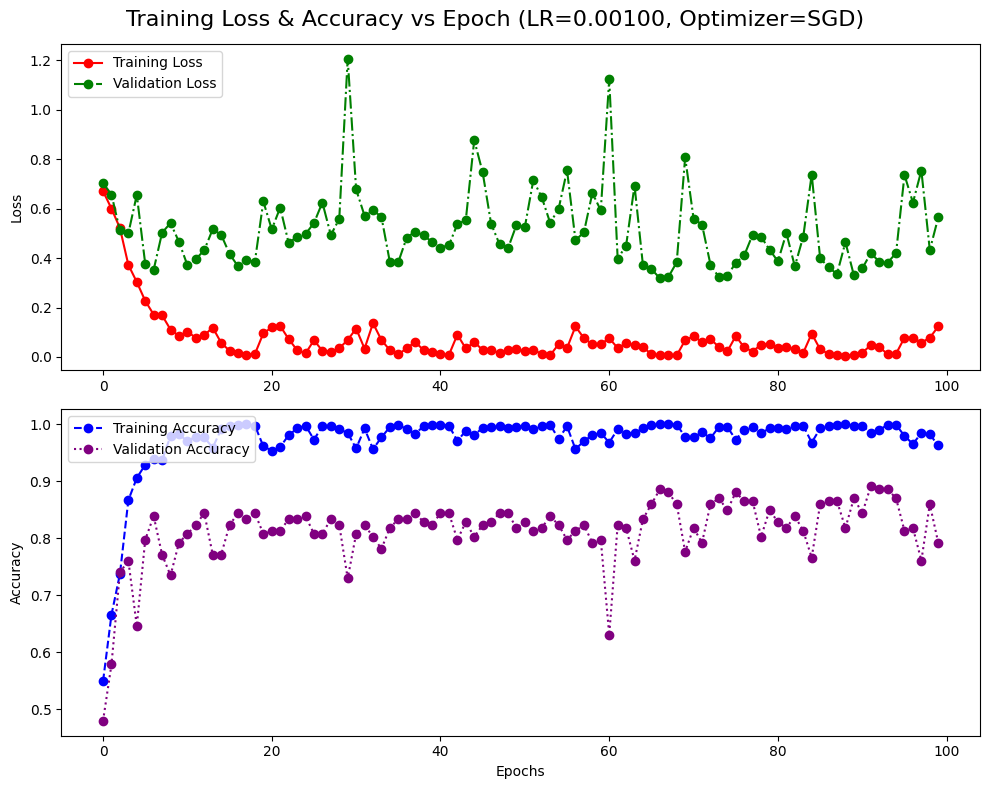

Entrenando con learning_rate=0.00100, epochs=100, optimizer=Adam


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.6407263294422828
Epoch 1 Training Loss = 0.8061584925373241
Epoch 1 Validation Accuracy = 0.5416666666666666
Epoch 1 Validation Loss = 20.745343526204426
La mejor precisión de Validation Loss (20.745343526204426) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.6977950713359273
Epoch 2 Training Loss = 0.6384621458140174
Epoch 2 Validation Accuracy = 0.4583333333333333
Epoch 2 Validation Loss = 10.85622755686442
La mejor precisión de Validation Loss (10.85622755686442) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.767833981841764
Epoch 3 Training Loss = 0.47878741259395535
Epoch 3 Validation Accuracy = 0.6354166666666666
Epoch 3 Validation Loss = 3.146798531214396
La mejor precisión de Validation Loss (3.146798531214396) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.7833981841763943
Epoch 4 Training Loss = 0.4960872886941591
Epoch 4 Validation Accuracy = 0.5
Epoch 4 Validation Loss = 10.357768694559732
La mejor precisión de Validation Loss (3.146798531214396) se alcanzó en la época 3


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.8119325551232166
Epoch 5 Training Loss = 0.4076206767218895
Epoch 5 Validation Accuracy = 0.5208333333333334
Epoch 5 Validation Loss = 1.7654179334640503
La mejor precisión de Validation Loss (1.7654179334640503) se alcanzó en la época 5


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.8119325551232166
Epoch 6 Training Loss = 0.39735594109647776
Epoch 6 Validation Accuracy = 0.7395833333333334
Epoch 6 Validation Loss = 0.5559194584687551
La mejor precisión de Validation Loss (0.5559194584687551) se alcanzó en la época 6


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.8482490272373541
Epoch 7 Training Loss = 0.34599948682654386
Epoch 7 Validation Accuracy = 0.78125
Epoch 7 Validation Loss = 0.5468789835770925
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.914396887159533
Epoch 8 Training Loss = 0.20648347094519748
Epoch 8 Validation Accuracy = 0.4791666666666667
Epoch 8 Validation Loss = 2.5015149116516113
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.8599221789883269
Epoch 9 Training Loss = 0.3405383472075993
Epoch 9 Validation Accuracy = 0.7291666666666666
Epoch 9 Validation Loss = 0.9416027267773946
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.8910505836575876
Epoch 10 Training Loss = 0.26681187830082637
Epoch 10 Validation Accuracy = 0.6822916666666666
Epoch 10 Validation Loss = 1.476395805676778
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.7276264591439688
Epoch 11 Training Loss = 0.5601999647963681
Epoch 11 Validation Accuracy = 0.4635416666666667
Epoch 11 Validation Loss = 3.0361931324005127
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.754863813229572
Epoch 12 Training Loss = 0.4875730275721247
Epoch 12 Validation Accuracy = 0.7552083333333334
Epoch 12 Validation Loss = 1.1186002691586812
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.7769130998702983
Epoch 13 Training Loss = 0.48693584976415843
Epoch 13 Validation Accuracy = 0.7552083333333334
Epoch 13 Validation Loss = 0.6228686372439066
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.867704280155642
Epoch 14 Training Loss = 0.3076436672693097
Epoch 14 Validation Accuracy = 0.5208333333333334
Epoch 14 Validation Loss = 3.681847413380941
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.7094682230869002
Epoch 15 Training Loss = 0.6268765629497484
Epoch 15 Validation Accuracy = 0.5885416666666666
Epoch 15 Validation Loss = 6.040568510691325
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.7094682230869002
Epoch 16 Training Loss = 0.5419527248958979
Epoch 16 Validation Accuracy = 0.6822916666666666
Epoch 16 Validation Loss = 0.9031887451807658
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.7509727626459144
Epoch 17 Training Loss = 0.5532699376537952
Epoch 17 Validation Accuracy = 0.71875
Epoch 17 Validation Loss = 0.5872733394304911
La mejor precisión de Validation Loss (0.5468789835770925) se alcanzó en la época 7


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.8210116731517509
Epoch 18 Training Loss = 0.41522663406515553
Epoch 18 Validation Accuracy = 0.7864583333333334
Epoch 18 Validation Loss = 0.4969048003355662
La mejor precisión de Validation Loss (0.4969048003355662) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.7963683527885862
Epoch 19 Training Loss = 0.4225751919195964
Epoch 19 Validation Accuracy = 0.71875
Epoch 19 Validation Loss = 0.7041877309481303
La mejor precisión de Validation Loss (0.4969048003355662) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.7691309987029832
Epoch 20 Training Loss = 0.44842279981700983
Epoch 20 Validation Accuracy = 0.7239583333333334
Epoch 20 Validation Loss = 0.6589685479799906
La mejor precisión de Validation Loss (0.4969048003355662) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.8495460440985733
Epoch 21 Training Loss = 0.33000819414042315
Epoch 21 Validation Accuracy = 0.7604166666666666
Epoch 21 Validation Loss = 0.5030265053113302
La mejor precisión de Validation Loss (0.4969048003355662) se alcanzó en la época 18


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.8910505836575876
Epoch 22 Training Loss = 0.25711994806616223
Epoch 22 Validation Accuracy = 0.8177083333333334
Epoch 22 Validation Loss = 0.35971057415008545
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.8171206225680934
Epoch 23 Training Loss = 0.36180571993346655
Epoch 23 Validation Accuracy = 0.6458333333333334
Epoch 23 Validation Loss = 0.9533843000729879
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.6718547341115434
Epoch 24 Training Loss = 0.6918290376508591
Epoch 24 Validation Accuracy = 0.5625
Epoch 24 Validation Loss = 5.545087655385335
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.754863813229572
Epoch 25 Training Loss = 0.5230930020450464
Epoch 25 Validation Accuracy = 0.6510416666666666
Epoch 25 Validation Loss = 0.604352593421936
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.8236057068741893
Epoch 26 Training Loss = 0.3971028494347858
Epoch 26 Validation Accuracy = 0.6458333333333334
Epoch 26 Validation Loss = 0.6364327867825826
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.8560311284046692
Epoch 27 Training Loss = 0.31097349590209983
Epoch 27 Validation Accuracy = 0.75
Epoch 27 Validation Loss = 0.7275680700937907
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.8365758754863813
Epoch 28 Training Loss = 0.35298926604551717
Epoch 28 Validation Accuracy = 0.640625
Epoch 28 Validation Loss = 1.3925106128056843
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.8028534370946823
Epoch 29 Training Loss = 0.41076234272945716
Epoch 29 Validation Accuracy = 0.6666666666666666
Epoch 29 Validation Loss = 0.8750787576039633
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.7859922178988327
Epoch 30 Training Loss = 0.43693564501717863
Epoch 30 Validation Accuracy = 0.71875
Epoch 30 Validation Loss = 0.5867866079012553
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.8313878080415046
Epoch 31 Training Loss = 0.3835542746632325
Epoch 31 Validation Accuracy = 0.5625
Epoch 31 Validation Loss = 1.2868760824203491
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.8715953307392996
Epoch 32 Training Loss = 0.30945804827253487
Epoch 32 Validation Accuracy = 0.75
Epoch 32 Validation Loss = 0.5051575005054474
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.9273670557717251
Epoch 33 Training Loss = 0.2031010233551921
Epoch 33 Validation Accuracy = 0.796875
Epoch 33 Validation Loss = 0.4191865821679433
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.9169909208819714
Epoch 34 Training Loss = 0.21990685070225854
Epoch 34 Validation Accuracy = 0.7395833333333334
Epoch 34 Validation Loss = 0.5767723917961121
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.9325551232166018
Epoch 35 Training Loss = 0.19064294397057882
Epoch 35 Validation Accuracy = 0.7708333333333334
Epoch 35 Validation Loss = 0.6518607437610626
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.9623865110246433
Epoch 36 Training Loss = 0.11787404933637527
Epoch 36 Validation Accuracy = 0.5885416666666666
Epoch 36 Validation Loss = 1.1433738072713215
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.7756160830090791
Epoch 37 Training Loss = 0.5589201580225726
Epoch 37 Validation Accuracy = 0.703125
Epoch 37 Validation Loss = 0.8273719151814779
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.8599221789883269
Epoch 38 Training Loss = 0.3115404992909128
Epoch 38 Validation Accuracy = 0.6614583333333334
Epoch 38 Validation Loss = 1.778676708539327
La mejor precisión de Validation Loss (0.35971057415008545) se alcanzó en la época 22


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.9273670557717251
Epoch 39 Training Loss = 0.1981294918926155
Epoch 39 Validation Accuracy = 0.828125
Epoch 39 Validation Loss = 0.3541342318058014
La mejor precisión de Validation Loss (0.3541342318058014) se alcanzó en la época 39


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.933852140077821
Epoch 40 Training Loss = 0.1558510742153871
Epoch 40 Validation Accuracy = 0.6354166666666666
Epoch 40 Validation Loss = 0.8034041921297709
La mejor precisión de Validation Loss (0.3541342318058014) se alcanzó en la época 39


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.9753566796368353
Epoch 41 Training Loss = 0.09567401891552521
Epoch 41 Validation Accuracy = 0.8125
Epoch 41 Validation Loss = 0.3778931498527527
La mejor precisión de Validation Loss (0.3541342318058014) se alcanzó en la época 39


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.9299610894941635
Epoch 42 Training Loss = 0.19684534777927026
Epoch 42 Validation Accuracy = 0.75
Epoch 42 Validation Loss = 1.0146241386731465
La mejor precisión de Validation Loss (0.3541342318058014) se alcanzó en la época 39


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.9234760051880675
Epoch 43 Training Loss = 0.19746861584610204
Epoch 43 Validation Accuracy = 0.6875
Epoch 43 Validation Loss = 1.005904237429301
La mejor precisión de Validation Loss (0.3541342318058014) se alcanzó en la época 39


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.9066147859922179
Epoch 44 Training Loss = 0.23778173540043615
Epoch 44 Validation Accuracy = 0.796875
Epoch 44 Validation Loss = 0.5063832302888235
La mejor precisión de Validation Loss (0.3541342318058014) se alcanzó en la época 39


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.9273670557717251
Epoch 45 Training Loss = 0.18037880650551172
Epoch 45 Validation Accuracy = 0.7291666666666666
Epoch 45 Validation Loss = 0.7113638321558634
La mejor precisión de Validation Loss (0.3541342318058014) se alcanzó en la época 39


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.9779507133592736
Epoch 46 Training Loss = 0.08240829085406935
Epoch 46 Validation Accuracy = 0.8802083333333334
Epoch 46 Validation Loss = 0.336587260166804
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.9727626459143969
Epoch 47 Training Loss = 0.09055250866916006
Epoch 47 Validation Accuracy = 0.8385416666666666
Epoch 47 Validation Loss = 0.5313484271367391
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.9857328145265889
Epoch 48 Training Loss = 0.07338054364138849
Epoch 48 Validation Accuracy = 0.6770833333333334
Epoch 48 Validation Loss = 1.0361854235331218
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.9182879377431906
Epoch 49 Training Loss = 0.2507550744231109
Epoch 49 Validation Accuracy = 0.7864583333333334
Epoch 49 Validation Loss = 0.6280848979949951
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.9040207522697795
Epoch 50 Training Loss = 0.24398820564131482
Epoch 50 Validation Accuracy = 0.640625
Epoch 50 Validation Loss = 1.0112323363622029
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.8832684824902723
Epoch 51 Training Loss = 0.3098683073807474
Epoch 51 Validation Accuracy = 0.5208333333333334
Epoch 51 Validation Loss = 2.13729194800059
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.9312581063553826
Epoch 52 Training Loss = 0.20155433527690428
Epoch 52 Validation Accuracy = 0.875
Epoch 52 Validation Loss = 0.3838127752145131
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.9623865110246433
Epoch 53 Training Loss = 0.13306421967496282
Epoch 53 Validation Accuracy = 0.8125
Epoch 53 Validation Loss = 0.39827964703241986
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.9831387808041504
Epoch 54 Training Loss = 0.06818683764350089
Epoch 54 Validation Accuracy = 0.8541666666666666
Epoch 54 Validation Loss = 0.33928394814332324
La mejor precisión de Validation Loss (0.336587260166804) se alcanzó en la época 46


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.9727626459143969
Epoch 55 Training Loss = 0.10075497669777828
Epoch 55 Validation Accuracy = 0.875
Epoch 55 Validation Loss = 0.3360102375348409
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.959792477302205
Epoch 56 Training Loss = 0.12290774375664121
Epoch 56 Validation Accuracy = 0.7447916666666666
Epoch 56 Validation Loss = 0.9566259980201721
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.9675745784695201
Epoch 57 Training Loss = 0.09369220034776185
Epoch 57 Validation Accuracy = 0.8333333333333334
Epoch 57 Validation Loss = 0.45829882224400836
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.9688715953307393
Epoch 58 Training Loss = 0.09611836789917544
Epoch 58 Validation Accuracy = 0.71875
Epoch 58 Validation Loss = 0.948925236860911
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.9870298313878081
Epoch 59 Training Loss = 0.0487068003604017
Epoch 59 Validation Accuracy = 0.8177083333333334
Epoch 59 Validation Loss = 0.46051985025405884
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 1.0
Epoch 60 Training Loss = 0.01379355135580329
Epoch 60 Validation Accuracy = 0.84375
Epoch 60 Validation Loss = 0.4054151475429535
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.9987029831387808
Epoch 61 Training Loss = 0.014457166465494574
Epoch 61 Validation Accuracy = 0.828125
Epoch 61 Validation Loss = 0.44586381316185
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.8702983138780804
Epoch 62 Training Loss = 0.3561714124677391
Epoch 62 Validation Accuracy = 0.6770833333333334
Epoch 62 Validation Loss = 0.8887793819109598
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.893644617380026
Epoch 63 Training Loss = 0.2928516017091877
Epoch 63 Validation Accuracy = 0.7552083333333334
Epoch 63 Validation Loss = 0.6046266555786133
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.9701686121919585
Epoch 64 Training Loss = 0.124250096492421
Epoch 64 Validation Accuracy = 0.8333333333333334
Epoch 64 Validation Loss = 0.4425916870435079
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.9247730220492867
Epoch 65 Training Loss = 0.19017141431222165
Epoch 65 Validation Accuracy = 0.78125
Epoch 65 Validation Loss = 0.5621219972769419
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9286640726329443
Epoch 66 Training Loss = 0.19310693516385113
Epoch 66 Validation Accuracy = 0.7395833333333334
Epoch 66 Validation Loss = 0.6636624534924825
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.9675745784695201
Epoch 67 Training Loss = 0.10165421855569504
Epoch 67 Validation Accuracy = 0.8541666666666666
Epoch 67 Validation Loss = 0.3739286760489146
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.9909208819714657
Epoch 68 Training Loss = 0.03939793932453358
Epoch 68 Validation Accuracy = 0.7916666666666666
Epoch 68 Validation Loss = 0.5485490759213766
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.9662775616083009
Epoch 69 Training Loss = 0.10975323661910576
Epoch 69 Validation Accuracy = 0.8489583333333334
Epoch 69 Validation Loss = 0.38614631195863086
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.8962386511024644
Epoch 70 Training Loss = 0.26577932322844766
Epoch 70 Validation Accuracy = 0.7291666666666666
Epoch 70 Validation Loss = 0.7242523431777954
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.8845654993514915
Epoch 71 Training Loss = 0.3124338002095117
Epoch 71 Validation Accuracy = 0.6666666666666666
Epoch 71 Validation Loss = 0.830517033735911
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9364461738002594
Epoch 72 Training Loss = 0.17258136053648132
Epoch 72 Validation Accuracy = 0.7239583333333334
Epoch 72 Validation Loss = 0.7526962558428446
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.9740596627756161
Epoch 73 Training Loss = 0.11283787420133054
Epoch 73 Validation Accuracy = 0.8177083333333334
Epoch 73 Validation Loss = 0.4153769612312317
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.9883268482490273
Epoch 74 Training Loss = 0.06283934733283195
Epoch 74 Validation Accuracy = 0.7864583333333334
Epoch 74 Validation Loss = 0.4397704601287842
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9688715953307393
Epoch 75 Training Loss = 0.09513918330214058
Epoch 75 Validation Accuracy = 0.7447916666666666
Epoch 75 Validation Loss = 0.7461296518643697
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9883268482490273
Epoch 76 Training Loss = 0.05378793742406229
Epoch 76 Validation Accuracy = 0.8333333333333334
Epoch 76 Validation Loss = 0.46164607008298236
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.9948119325551232
Epoch 77 Training Loss = 0.025485419863943693
Epoch 77 Validation Accuracy = 0.78125
Epoch 77 Validation Loss = 0.605957825978597
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 1.0
Epoch 78 Training Loss = 0.013145262581729916
Epoch 78 Validation Accuracy = 0.8385416666666666
Epoch 78 Validation Loss = 0.44741963346799213
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 1.0
Epoch 79 Training Loss = 0.006742881473284287
Epoch 79 Validation Accuracy = 0.8385416666666666
Epoch 79 Validation Loss = 0.5072828729947408
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 1.0
Epoch 80 Training Loss = 0.009628643639572628
Epoch 80 Validation Accuracy = 0.8072916666666666
Epoch 80 Validation Loss = 0.6400592625141144
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 1.0
Epoch 81 Training Loss = 0.005600586819828484
Epoch 81 Validation Accuracy = 0.8645833333333334
Epoch 81 Validation Loss = 0.5232257346312205
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9987029831387808
Epoch 82 Training Loss = 0.007106811967805202
Epoch 82 Validation Accuracy = 0.8333333333333334
Epoch 82 Validation Loss = 0.4981907506783803
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9546044098573282
Epoch 83 Training Loss = 0.13660370964308097
Epoch 83 Validation Accuracy = 0.8020833333333334
Epoch 83 Validation Loss = 0.5336974362532297
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9714656290531777
Epoch 84 Training Loss = 0.091277327962901
Epoch 84 Validation Accuracy = 0.8333333333333334
Epoch 84 Validation Loss = 0.42977843681971234
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9909208819714657
Epoch 85 Training Loss = 0.04037938940540516
Epoch 85 Validation Accuracy = 0.859375
Epoch 85 Validation Loss = 0.49738502502441406
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.9740596627756161
Epoch 86 Training Loss = 0.07705665236984013
Epoch 86 Validation Accuracy = 0.7552083333333334
Epoch 86 Validation Loss = 0.844293495019277
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9857328145265889
Epoch 87 Training Loss = 0.053570092010375804
Epoch 87 Validation Accuracy = 0.8072916666666666
Epoch 87 Validation Loss = 0.7016201019287109
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.9974059662775616
Epoch 88 Training Loss = 0.016906320237000165
Epoch 88 Validation Accuracy = 0.8802083333333334
Epoch 88 Validation Loss = 0.5238862733046213
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9662775616083009
Epoch 89 Training Loss = 0.10322276658430483
Epoch 89 Validation Accuracy = 0.78125
Epoch 89 Validation Loss = 0.6144858797391256
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.8404669260700389
Epoch 90 Training Loss = 0.4226801778478536
Epoch 90 Validation Accuracy = 0.484375
Epoch 90 Validation Loss = 3.038506110509237
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9260700389105059
Epoch 91 Training Loss = 0.2186504124667394
Epoch 91 Validation Accuracy = 0.8229166666666666
Epoch 91 Validation Loss = 0.43782156705856323
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9040207522697795
Epoch 92 Training Loss = 0.2429853165969156
Epoch 92 Validation Accuracy = 0.6822916666666666
Epoch 92 Validation Loss = 0.9743915796279907
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.893644617380026
Epoch 93 Training Loss = 0.26060054927639154
Epoch 93 Validation Accuracy = 0.6979166666666666
Epoch 93 Validation Loss = 1.0853375593821208
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.959792477302205
Epoch 94 Training Loss = 0.1117428038830974
Epoch 94 Validation Accuracy = 0.84375
Epoch 94 Validation Loss = 0.4402589599291484
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9909208819714657
Epoch 95 Training Loss = 0.042842735044764484
Epoch 95 Validation Accuracy = 0.8541666666666666
Epoch 95 Validation Loss = 0.438412070274353
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.9987029831387808
Epoch 96 Training Loss = 0.020758093843277637
Epoch 96 Validation Accuracy = 0.8541666666666666
Epoch 96 Validation Loss = 0.40867797533671063
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 1.0
Epoch 97 Training Loss = 0.013464142794294425
Epoch 97 Validation Accuracy = 0.8333333333333334
Epoch 97 Validation Loss = 0.4525693356990814
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9987029831387808
Epoch 98 Training Loss = 0.011665926659153593
Epoch 98 Validation Accuracy = 0.8541666666666666
Epoch 98 Validation Loss = 0.43289123972256977
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 1.0
Epoch 99 Training Loss = 0.007113861424990975
Epoch 99 Validation Accuracy = 0.84375
Epoch 99 Validation Loss = 0.46488556265830994
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 1.0
Epoch 100 Training Loss = 0.00794877917850064
Epoch 100 Validation Accuracy = 0.828125
Epoch 100 Validation Loss = 0.562032163143158
La mejor precisión de Validation Loss (0.3360102375348409) se alcanzó en la época 55


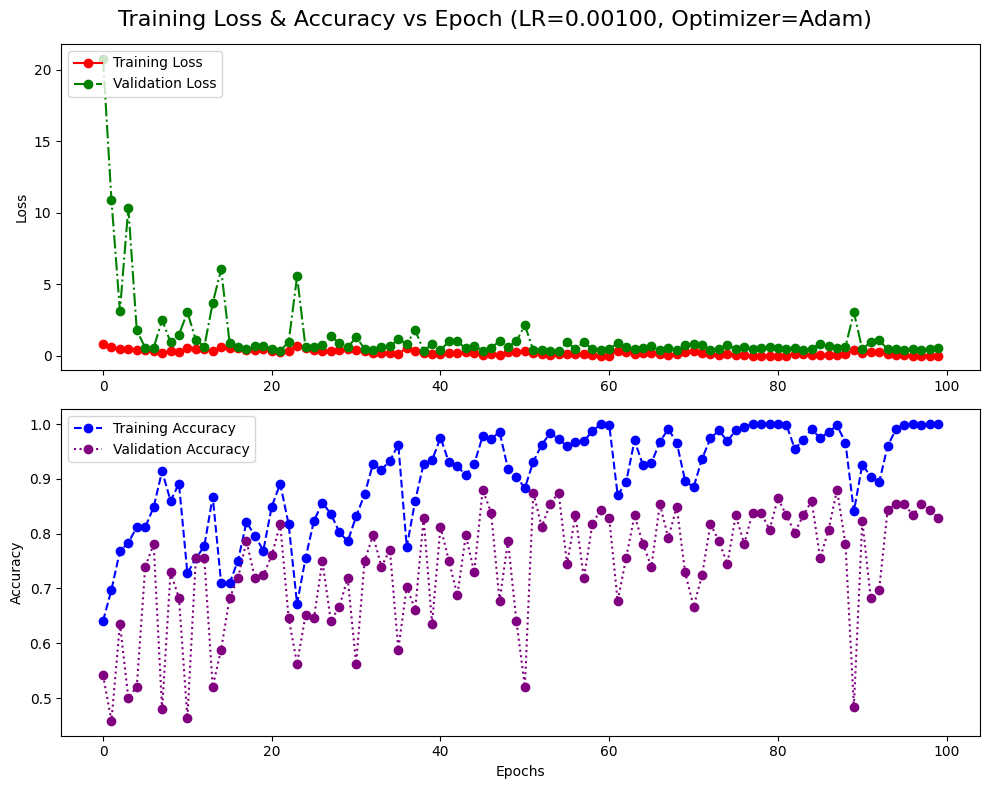

Entrenando con learning_rate=0.00100, epochs=100, optimizer=RMSprop


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/13 [00:00<?, ?batch/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 1 Training Accuracy = 0.5214007782101168
Epoch 1 Training Loss = 1.7891730629825715
Epoch 1 Validation Accuracy = 0.4583333333333333
Epoch 1 Validation Loss = 1576.8461100260417
La mejor precisión de Validation Loss (1576.8461100260417) se alcanzó en la época 1


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 2 Training Accuracy = 0.582360570687419
Epoch 2 Training Loss = 0.796889585975543
Epoch 2 Validation Accuracy = 0.4583333333333333
Epoch 2 Validation Loss = 0.7569054961204529
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 3 Training Accuracy = 0.5784695201037614
Epoch 3 Training Loss = 0.7227584273589415
Epoch 3 Validation Accuracy = 0.5520833333333334
Epoch 3 Validation Loss = 1.4290011723836262
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 4 Training Accuracy = 0.6199740596627756
Epoch 4 Training Loss = 0.7111562686053077
Epoch 4 Validation Accuracy = 0.53125
Epoch 4 Validation Loss = 0.7609782417615255
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 5 Training Accuracy = 0.622568093385214
Epoch 5 Training Loss = 0.6632794734336986
Epoch 5 Validation Accuracy = 0.4583333333333333
Epoch 5 Validation Loss = 0.8873234192530314
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 6 Training Accuracy = 0.6005188067444877
Epoch 6 Training Loss = 0.6963462402075336
Epoch 6 Validation Accuracy = 0.4583333333333333
Epoch 6 Validation Loss = 41.64931869506836
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 7 Training Accuracy = 0.6147859922178989
Epoch 7 Training Loss = 0.6743047395105028
Epoch 7 Validation Accuracy = 0.5416666666666666
Epoch 7 Validation Loss = 171.8728790283203
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 8 Training Accuracy = 0.5616083009079118
Epoch 8 Training Loss = 0.7240031361579895
Epoch 8 Validation Accuracy = 0.4583333333333333
Epoch 8 Validation Loss = 3.650754690170288
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 9 Training Accuracy = 0.6342412451361867
Epoch 9 Training Loss = 0.633282221013006
Epoch 9 Validation Accuracy = 0.5260416666666666
Epoch 9 Validation Loss = 1.7618228594462078
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 10 Training Accuracy = 0.5732814526588845
Epoch 10 Training Loss = 0.6523035677335914
Epoch 10 Validation Accuracy = 0.5052083333333334
Epoch 10 Validation Loss = 1.3285599549611409
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 11 Training Accuracy = 0.6095979247730221
Epoch 11 Training Loss = 0.6580134141615238
Epoch 11 Validation Accuracy = 0.6458333333333334
Epoch 11 Validation Loss = 1.2508601347605388
La mejor precisión de Validation Loss (0.7569054961204529) se alcanzó en la época 2


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 12 Training Accuracy = 0.6614785992217899
Epoch 12 Training Loss = 0.6078199736493726
Epoch 12 Validation Accuracy = 0.5416666666666666
Epoch 12 Validation Loss = 0.7456838488578796
La mejor precisión de Validation Loss (0.7456838488578796) se alcanzó en la época 12


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 13 Training Accuracy = 0.5875486381322957
Epoch 13 Training Loss = 0.6891537268492652
Epoch 13 Validation Accuracy = 0.6197916666666666
Epoch 13 Validation Loss = 0.6863801678021749
La mejor precisión de Validation Loss (0.6863801678021749) se alcanzó en la época 13


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 14 Training Accuracy = 0.6005188067444877
Epoch 14 Training Loss = 0.64639992627343
Epoch 14 Validation Accuracy = 0.4583333333333333
Epoch 14 Validation Loss = 2.7601682345072427
La mejor precisión de Validation Loss (0.6863801678021749) se alcanzó en la época 13


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 15 Training Accuracy = 0.6083009079118028
Epoch 15 Training Loss = 0.6205337461949013
Epoch 15 Validation Accuracy = 0.6979166666666666
Epoch 15 Validation Loss = 0.5925378203392029
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 16 Training Accuracy = 0.6511024643320363
Epoch 16 Training Loss = 0.6117951523623733
Epoch 16 Validation Accuracy = 0.5416666666666666
Epoch 16 Validation Loss = 6.941652774810791
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 17 Training Accuracy = 0.6342412451361867
Epoch 17 Training Loss = 0.6354433751910268
Epoch 17 Validation Accuracy = 0.5416666666666666
Epoch 17 Validation Loss = 30.337671279907227
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 18 Training Accuracy = 0.562905317769131
Epoch 18 Training Loss = 0.6948975042455701
Epoch 18 Validation Accuracy = 0.5208333333333334
Epoch 18 Validation Loss = 4.753632465998332
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 19 Training Accuracy = 0.6251621271076524
Epoch 19 Training Loss = 0.6597228895210879
Epoch 19 Validation Accuracy = 0.5885416666666666
Epoch 19 Validation Loss = 1.1291364431381226
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 20 Training Accuracy = 0.6251621271076524
Epoch 20 Training Loss = 0.6620610414698584
Epoch 20 Validation Accuracy = 0.5208333333333334
Epoch 20 Validation Loss = 0.7302563190460205
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 21 Training Accuracy = 0.6511024643320363
Epoch 21 Training Loss = 0.6394112859254681
Epoch 21 Validation Accuracy = 0.5104166666666666
Epoch 21 Validation Loss = 0.6996990839640299
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 22 Training Accuracy = 0.6316472114137484
Epoch 22 Training Loss = 0.6508094825324072
Epoch 22 Validation Accuracy = 0.5625
Epoch 22 Validation Loss = 2.738285263379415
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 23 Training Accuracy = 0.6653696498054474
Epoch 23 Training Loss = 0.6132860301224329
Epoch 23 Validation Accuracy = 0.59375
Epoch 23 Validation Loss = 0.6669114430745443
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 24 Training Accuracy = 0.6977950713359273
Epoch 24 Training Loss = 0.5943568683629216
Epoch 24 Validation Accuracy = 0.4583333333333333
Epoch 24 Validation Loss = 4.417745033899943
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 25 Training Accuracy = 0.6926070038910506
Epoch 25 Training Loss = 0.5709479538537804
Epoch 25 Validation Accuracy = 0.5364583333333334
Epoch 25 Validation Loss = 24.617651621500652
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 26 Training Accuracy = 0.6523994811932555
Epoch 26 Training Loss = 0.6369081516828673
Epoch 26 Validation Accuracy = 0.53125
Epoch 26 Validation Loss = 0.8399357795715332
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 27 Training Accuracy = 0.6913099870298314
Epoch 27 Training Loss = 0.5772006833290466
Epoch 27 Validation Accuracy = 0.4583333333333333
Epoch 27 Validation Loss = 1.462985674540202
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 28 Training Accuracy = 0.6329442282749675
Epoch 28 Training Loss = 0.637246803666831
Epoch 28 Validation Accuracy = 0.4583333333333333
Epoch 28 Validation Loss = 1.8363864819208782
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 29 Training Accuracy = 0.708171206225681
Epoch 29 Training Loss = 0.5705423177293611
Epoch 29 Validation Accuracy = 0.4583333333333333
Epoch 29 Validation Loss = 5.308714230855306
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 30 Training Accuracy = 0.7444876783398184
Epoch 30 Training Loss = 0.5311690250414045
Epoch 30 Validation Accuracy = 0.4635416666666667
Epoch 30 Validation Loss = 1.292802373568217
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 31 Training Accuracy = 0.6044098573281452
Epoch 31 Training Loss = 0.6610762588244932
Epoch 31 Validation Accuracy = 0.53125
Epoch 31 Validation Loss = 0.9166125655174255
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 32 Training Accuracy = 0.6083009079118028
Epoch 32 Training Loss = 0.6648041075614949
Epoch 32 Validation Accuracy = 0.4895833333333333
Epoch 32 Validation Loss = 0.7751387556393942
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 33 Training Accuracy = 0.6718547341115434
Epoch 33 Training Loss = 0.5919945265532468
Epoch 33 Validation Accuracy = 0.4583333333333333
Epoch 33 Validation Loss = 1.0619755188624065
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 34 Training Accuracy = 0.7159533073929961
Epoch 34 Training Loss = 0.5433106967447333
Epoch 34 Validation Accuracy = 0.453125
Epoch 34 Validation Loss = 3.888118267059326
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 35 Training Accuracy = 0.6277561608300908
Epoch 35 Training Loss = 0.6518480295337128
Epoch 35 Validation Accuracy = 0.6302083333333334
Epoch 35 Validation Loss = 0.6155415177345276
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 36 Training Accuracy = 0.7120622568093385
Epoch 36 Training Loss = 0.5758188321664639
Epoch 36 Validation Accuracy = 0.4635416666666667
Epoch 36 Validation Loss = 6.722673416137695
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 37 Training Accuracy = 0.682230869001297
Epoch 37 Training Loss = 0.571698525845618
Epoch 37 Validation Accuracy = 0.4635416666666667
Epoch 37 Validation Loss = 6.4922410647074384
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 38 Training Accuracy = 0.7444876783398184
Epoch 38 Training Loss = 0.5394174611212833
Epoch 38 Validation Accuracy = 0.671875
Epoch 38 Validation Loss = 0.7095945874849955
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 39 Training Accuracy = 0.74189364461738
Epoch 39 Training Loss = 0.5164686201765998
Epoch 39 Validation Accuracy = 0.4479166666666667
Epoch 39 Validation Loss = 1.4463270902633667
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 40 Training Accuracy = 0.648508430609598
Epoch 40 Training Loss = 0.6306035795409701
Epoch 40 Validation Accuracy = 0.609375
Epoch 40 Validation Loss = 1.7063060601552327
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 41 Training Accuracy = 0.7172503242542153
Epoch 41 Training Loss = 0.584194533208001
Epoch 41 Validation Accuracy = 0.4322916666666667
Epoch 41 Validation Loss = 1.468497594197591
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 42 Training Accuracy = 0.7457846952010376
Epoch 42 Training Loss = 0.5422639703394992
Epoch 42 Validation Accuracy = 0.4583333333333333
Epoch 42 Validation Loss = 1.4142685333887737
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 43 Training Accuracy = 0.7833981841763943
Epoch 43 Training Loss = 0.46426096137241013
Epoch 43 Validation Accuracy = 0.5260416666666666
Epoch 43 Validation Loss = 1.130012313524882
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 44 Training Accuracy = 0.7665369649805448
Epoch 44 Training Loss = 0.4837704733033434
Epoch 44 Validation Accuracy = 0.4635416666666667
Epoch 44 Validation Loss = 16.08720874786377
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 45 Training Accuracy = 0.6939040207522698
Epoch 45 Training Loss = 0.60293550744904
Epoch 45 Validation Accuracy = 0.6510416666666666
Epoch 45 Validation Loss = 0.6212888956069946
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 46 Training Accuracy = 0.7185473411154345
Epoch 46 Training Loss = 0.5333497139266493
Epoch 46 Validation Accuracy = 0.4791666666666667
Epoch 46 Validation Loss = 1.1483219861984253
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 47 Training Accuracy = 0.7444876783398184
Epoch 47 Training Loss = 0.5094733047075618
Epoch 47 Validation Accuracy = 0.671875
Epoch 47 Validation Loss = 0.7262168924013773
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 48 Training Accuracy = 0.7989623865110247
Epoch 48 Training Loss = 0.4585285959849871
Epoch 48 Validation Accuracy = 0.6510416666666666
Epoch 48 Validation Loss = 0.7226714491844177
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 49 Training Accuracy = 0.795071335927367
Epoch 49 Training Loss = 0.44012992143940216
Epoch 49 Validation Accuracy = 0.453125
Epoch 49 Validation Loss = 2.3107833862304688
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 50 Training Accuracy = 0.7146562905317769
Epoch 50 Training Loss = 0.566501925041085
Epoch 50 Validation Accuracy = 0.4739583333333333
Epoch 50 Validation Loss = 1.6137165625890095
La mejor precisión de Validation Loss (0.5925378203392029) se alcanzó en la época 15


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 51 Training Accuracy = 0.7795071335927367
Epoch 51 Training Loss = 0.4808214096359706
Epoch 51 Validation Accuracy = 0.7864583333333334
Epoch 51 Validation Loss = 0.49556009968121845
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 52 Training Accuracy = 0.8469520103761349
Epoch 52 Training Loss = 0.36055869988894185
Epoch 52 Validation Accuracy = 0.5729166666666666
Epoch 52 Validation Loss = 1.1215540170669556
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 53 Training Accuracy = 0.8456549935149157
Epoch 53 Training Loss = 0.3643704983665476
Epoch 53 Validation Accuracy = 0.609375
Epoch 53 Validation Loss = 0.8738565643628439
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 54 Training Accuracy = 0.7639429312581063
Epoch 54 Training Loss = 0.5000144192216925
Epoch 54 Validation Accuracy = 0.53125
Epoch 54 Validation Loss = 1.8979501724243164
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 55 Training Accuracy = 0.7613488975356679
Epoch 55 Training Loss = 0.4954300730376856
Epoch 55 Validation Accuracy = 0.4583333333333333
Epoch 55 Validation Loss = 1.8479115962982178
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 56 Training Accuracy = 0.8093385214007782
Epoch 56 Training Loss = 0.42568025483850064
Epoch 56 Validation Accuracy = 0.46875
Epoch 56 Validation Loss = 2.277681350708008
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 57 Training Accuracy = 0.8482490272373541
Epoch 57 Training Loss = 0.3415070543338662
Epoch 57 Validation Accuracy = 0.5885416666666666
Epoch 57 Validation Loss = 1.5921250184377034
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 58 Training Accuracy = 0.8521400778210116
Epoch 58 Training Loss = 0.33417371162799236
Epoch 58 Validation Accuracy = 0.5416666666666666
Epoch 58 Validation Loss = 1.825754721959432
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 59 Training Accuracy = 0.8832684824902723
Epoch 59 Training Loss = 0.2625998528589689
Epoch 59 Validation Accuracy = 0.609375
Epoch 59 Validation Loss = 0.8780941764513651
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 60 Training Accuracy = 0.8767833981841764
Epoch 60 Training Loss = 0.28579746733688965
Epoch 60 Validation Accuracy = 0.4583333333333333
Epoch 60 Validation Loss = 28.9676456451416
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 61 Training Accuracy = 0.8560311284046692
Epoch 61 Training Loss = 0.36348339787716993
Epoch 61 Validation Accuracy = 0.453125
Epoch 61 Validation Loss = 22.293227513631184
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 62 Training Accuracy = 0.7937743190661478
Epoch 62 Training Loss = 0.4288948261687573
Epoch 62 Validation Accuracy = 0.734375
Epoch 62 Validation Loss = 0.5612716774145762
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 63 Training Accuracy = 0.8897535667963683
Epoch 63 Training Loss = 0.259198359632925
Epoch 63 Validation Accuracy = 0.6041666666666666
Epoch 63 Validation Loss = 1.4683331648508708
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 64 Training Accuracy = 0.7898832684824902
Epoch 64 Training Loss = 0.433388140318304
Epoch 64 Validation Accuracy = 0.4739583333333333
Epoch 64 Validation Loss = 16.48497136433919
La mejor precisión de Validation Loss (0.49556009968121845) se alcanzó en la época 51


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 65 Training Accuracy = 0.85473411154345
Epoch 65 Training Loss = 0.3370253172897566
Epoch 65 Validation Accuracy = 0.78125
Epoch 65 Validation Loss = 0.4605029324690501
La mejor precisión de Validation Loss (0.4605029324690501) se alcanzó en la época 65


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 66 Training Accuracy = 0.9286640726329443
Epoch 66 Training Loss = 0.2109217947559134
Epoch 66 Validation Accuracy = 0.4583333333333333
Epoch 66 Validation Loss = 5.415701866149902
La mejor precisión de Validation Loss (0.4605029324690501) se alcanzó en la época 65


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 67 Training Accuracy = 0.833981841763943
Epoch 67 Training Loss = 0.3693449696678132
Epoch 67 Validation Accuracy = 0.4583333333333333
Epoch 67 Validation Loss = 5.024172782897949
La mejor precisión de Validation Loss (0.4605029324690501) se alcanzó en la época 65


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 68 Training Accuracy = 0.8365758754863813
Epoch 68 Training Loss = 0.37128476236117025
Epoch 68 Validation Accuracy = 0.6770833333333334
Epoch 68 Validation Loss = 0.6378656427065531
La mejor precisión de Validation Loss (0.4605029324690501) se alcanzó en la época 65


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 69 Training Accuracy = 0.8949416342412452
Epoch 69 Training Loss = 0.2509569999424864
Epoch 69 Validation Accuracy = 0.7083333333333334
Epoch 69 Validation Loss = 1.4750833710034688
La mejor precisión de Validation Loss (0.4605029324690501) se alcanzó en la época 65


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 70 Training Accuracy = 0.9351491569390402
Epoch 70 Training Loss = 0.19212544258157258
Epoch 70 Validation Accuracy = 0.8020833333333334
Epoch 70 Validation Loss = 0.4160412351290385
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 71 Training Accuracy = 0.9312581063553826
Epoch 71 Training Loss = 0.18873821289777445
Epoch 71 Validation Accuracy = 0.59375
Epoch 71 Validation Loss = 1.554948091506958
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 72 Training Accuracy = 0.9312581063553826
Epoch 72 Training Loss = 0.1964497786551598
Epoch 72 Validation Accuracy = 0.6302083333333334
Epoch 72 Validation Loss = 1.989337166150411
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 73 Training Accuracy = 0.8002594033722439
Epoch 73 Training Loss = 0.4573039172069881
Epoch 73 Validation Accuracy = 0.484375
Epoch 73 Validation Loss = 2.0220449765523276
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 74 Training Accuracy = 0.8184176394293126
Epoch 74 Training Loss = 0.4470348044282886
Epoch 74 Validation Accuracy = 0.78125
Epoch 74 Validation Loss = 0.4846735994021098
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 75 Training Accuracy = 0.9195849546044098
Epoch 75 Training Loss = 0.20891107056391378
Epoch 75 Validation Accuracy = 0.640625
Epoch 75 Validation Loss = 0.8339803616205851
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 76 Training Accuracy = 0.9221789883268483
Epoch 76 Training Loss = 0.22873151348722584
Epoch 76 Validation Accuracy = 0.7083333333333334
Epoch 76 Validation Loss = 0.8510378201802572
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 77 Training Accuracy = 0.8845654993514915
Epoch 77 Training Loss = 0.28422435464871376
Epoch 77 Validation Accuracy = 0.8072916666666666
Epoch 77 Validation Loss = 0.6844885945320129
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 78 Training Accuracy = 0.9156939040207522
Epoch 78 Training Loss = 0.20436705111606884
Epoch 78 Validation Accuracy = 0.78125
Epoch 78 Validation Loss = 0.5141310294469198
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 79 Training Accuracy = 0.9909208819714657
Epoch 79 Training Loss = 0.06801391420970476
Epoch 79 Validation Accuracy = 0.6145833333333334
Epoch 79 Validation Loss = 0.8747531175613403
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 80 Training Accuracy = 0.8897535667963683
Epoch 80 Training Loss = 0.2709048316534971
Epoch 80 Validation Accuracy = 0.7083333333333334
Epoch 80 Validation Loss = 0.6942993005116781
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 81 Training Accuracy = 0.9727626459143969
Epoch 81 Training Loss = 0.08448621497674327
Epoch 81 Validation Accuracy = 0.8072916666666666
Epoch 81 Validation Loss = 0.45814428726832074
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 82 Training Accuracy = 0.9961089494163424
Epoch 82 Training Loss = 0.03322407491287717
Epoch 82 Validation Accuracy = 0.828125
Epoch 82 Validation Loss = 0.5312142272790273
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 83 Training Accuracy = 0.9987029831387808
Epoch 83 Training Loss = 0.01679976231354529
Epoch 83 Validation Accuracy = 0.5208333333333334
Epoch 83 Validation Loss = 3.5089396635691323
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 84 Training Accuracy = 0.9546044098573282
Epoch 84 Training Loss = 0.1321400531199815
Epoch 84 Validation Accuracy = 0.828125
Epoch 84 Validation Loss = 0.48230616251627606
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 85 Training Accuracy = 0.9948119325551232
Epoch 85 Training Loss = 0.025207693397457653
Epoch 85 Validation Accuracy = 0.546875
Epoch 85 Validation Loss = 17.871331850687664
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 86 Training Accuracy = 0.7989623865110247
Epoch 86 Training Loss = 0.5813557154628244
Epoch 86 Validation Accuracy = 0.671875
Epoch 86 Validation Loss = 1.40904966990153
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 87 Training Accuracy = 0.9079118028534371
Epoch 87 Training Loss = 0.23156932958832974
Epoch 87 Validation Accuracy = 0.640625
Epoch 87 Validation Loss = 1.9749555985132854
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 88 Training Accuracy = 0.8754863813229572
Epoch 88 Training Loss = 0.3301976194119639
Epoch 88 Validation Accuracy = 0.8072916666666666
Epoch 88 Validation Loss = 0.4954608380794525
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 89 Training Accuracy = 0.9714656290531777
Epoch 89 Training Loss = 0.116622528281116
Epoch 89 Validation Accuracy = 0.7239583333333334
Epoch 89 Validation Loss = 0.6928793986638387
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 90 Training Accuracy = 0.9610894941634242
Epoch 90 Training Loss = 0.11889964512195414
Epoch 90 Validation Accuracy = 0.5
Epoch 90 Validation Loss = 2.7216899394989014
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 91 Training Accuracy = 0.9390402075226978
Epoch 91 Training Loss = 0.16544551568543092
Epoch 91 Validation Accuracy = 0.6666666666666666
Epoch 91 Validation Loss = 1.5611175298690796
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 92 Training Accuracy = 0.9649805447470817
Epoch 92 Training Loss = 0.1040682274021991
Epoch 92 Validation Accuracy = 0.7083333333333334
Epoch 92 Validation Loss = 0.7876837849617004
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 93 Training Accuracy = 0.9714656290531777
Epoch 93 Training Loss = 0.08330102730663215
Epoch 93 Validation Accuracy = 0.65625
Epoch 93 Validation Loss = 1.0883560578028362
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 94 Training Accuracy = 0.9130998702983139
Epoch 94 Training Loss = 0.24781852134958818
Epoch 94 Validation Accuracy = 0.828125
Epoch 94 Validation Loss = 0.4347023169199626
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 95 Training Accuracy = 0.9948119325551232
Epoch 95 Training Loss = 0.034180770047134615
Epoch 95 Validation Accuracy = 0.578125
Epoch 95 Validation Loss = 1.2333296140034993
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 96 Training Accuracy = 0.8119325551232166
Epoch 96 Training Loss = 0.43250313992630185
Epoch 96 Validation Accuracy = 0.5729166666666666
Epoch 96 Validation Loss = 2.2029706637064614
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 97 Training Accuracy = 0.8975356679636836
Epoch 97 Training Loss = 0.2759507449993673
Epoch 97 Validation Accuracy = 0.5885416666666666
Epoch 97 Validation Loss = 2.743056138356527
La mejor precisión de Validation Loss (0.4160412351290385) se alcanzó en la época 70


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 98 Training Accuracy = 0.9221789883268483
Epoch 98 Training Loss = 0.22516137073553336
Epoch 98 Validation Accuracy = 0.8489583333333334
Epoch 98 Validation Loss = 0.3205006917317708
La mejor precisión de Validation Loss (0.3205006917317708) se alcanzó en la época 98


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 99 Training Accuracy = 0.9870298313878081
Epoch 99 Training Loss = 0.06919822562606727
Epoch 99 Validation Accuracy = 0.6927083333333334
Epoch 99 Validation Loss = 1.0863871773084004
La mejor precisión de Validation Loss (0.3205006917317708) se alcanzó en la época 98


  0%|          | 0/13 [00:00<?, ?batch/s]

Epoch 100 Training Accuracy = 0.959792477302205
Epoch 100 Training Loss = 0.11615396997179889
Epoch 100 Validation Accuracy = 0.8177083333333334
Epoch 100 Validation Loss = 0.4289125899473826
La mejor precisión de Validation Loss (0.3205006917317708) se alcanzó en la época 98


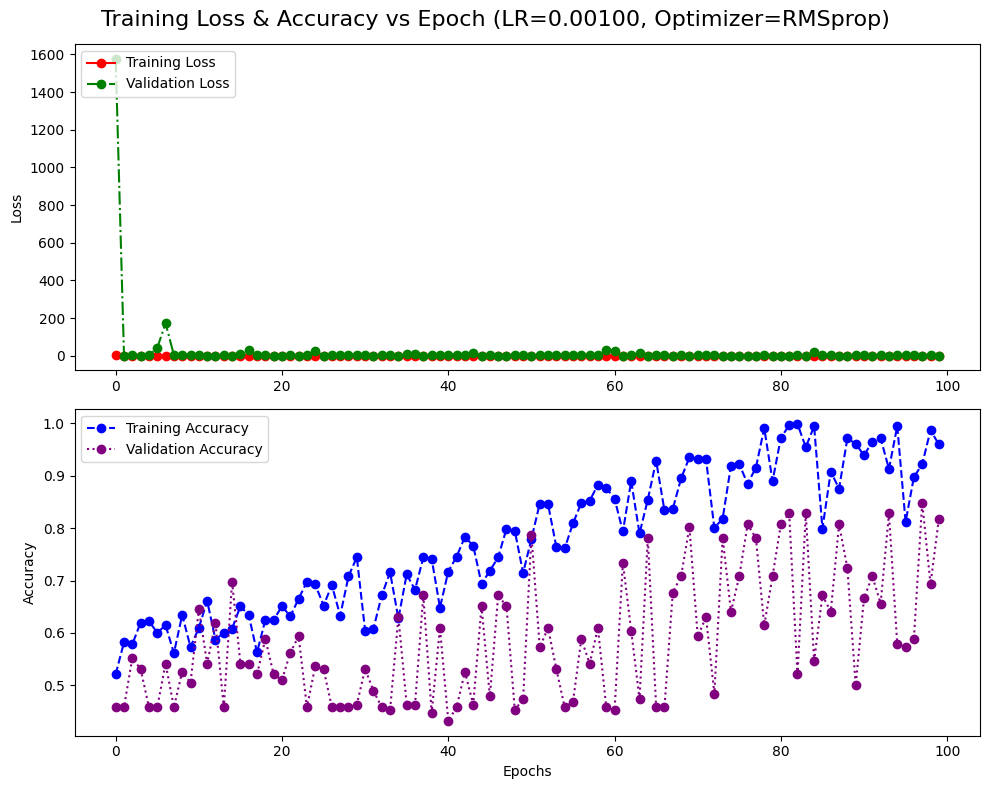

Los mejores hiperparámetros son: lr = 0.00010, optimizer = Adam


In [ ]:
from itertools import product
from sklearn.model_selection import ParameterGrid

torch.cuda.empty_cache()

epochs = 100

best_val_loss = float('inf')  # Inicializa la mejor pérdida de validación como infinito
best_hyperparameters = {}  # Almacenar los mejores hiperparámetros
best_model = None # Almacenar el mejor modelo

val_loss_dict = {}# Diccionario para almacenar los valores de val_loss por combinación de hiperparámetros


for params in ParameterGrid(param_grid):
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    print(f'Entrenando con learning_rate={learning_rate:.5f}, epochs={epochs}, optimizer={optimizer_name}')
    # loading the pretrained model
    # Cargar la ResNet-59 preentrenada
    model = models.resnet50(pretrained=True)
    # Modificar la capa de clasificación para dos clases
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)  # Dos clases

    # Define la función de pérdida
    criterion = nn.CrossEntropyLoss()

    model.to(device)

    # Define el optimizador fuera del bucle
    if optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)

    # Restablece todas las variables a 0 para la próxima combinación
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    best_epoch = 0
    best_val_loss = float('inf')
    torch.cuda.empty_cache()

    for epoch in range(epochs):
        model.train()
        total = 0
        correct = 0
        counter = 0
        train_running_loss = 0

        # Utiliza tqdm para mostrar una barra de progreso durante el entrenamiento
        with tqdm(train_loader, unit="batch") as tepoch:  # Utiliza train_loader en lugar de train_dataset
            # Etiqueta de la barra de progreso
            tepoch.set_description(f'Epoch {epoch+1}/{epochs}')

            for images, labels in tepoch:  # Utiliza tepoch como iterable
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_running_loss += loss.item() * images.size(0)

                _, pred = torch.max(outputs.data, 1)

                # Lleva un registro de cuántas imágenes se han propagado hacia adelante
                total += labels.size(0)
                # Lleva un registro de cuántas se predijeron correctamente
                correct += (pred == labels).sum().item()

                # Actualiza la barra de progreso con la pérdida actual
                tepoch.set_postfix(loss=train_running_loss/total)  # Puedes mostrar la pérdida en la barra de progreso

                # Registra las pérdidas y precisión de entrenamiento en cada época
            train_accuracy.append(correct/total)
            train_loss.append(train_running_loss/len(train_dataset))


            print(f'Epoch {epoch+1} Training Accuracy = {correct/total}')
            print(f'Epoch {epoch+1} Training Loss = {train_running_loss/len(train_dataset)}')

            # Obtén nuestra precisión y pérdida de validación
            if epoch % 1 == 0:
                model.eval()
                total = 0
                correct = 0
                val_running_loss = 0

                # No necesitamos gradientes para la validación, así que envuélvelo en no_grad para ahorrar memoria
                with torch.no_grad():
                    for images, labels in val_loader:
                        images, labels = images.to(device), labels.to(device)
                        val_output = model(images)
                        loss_val = criterion(val_output, labels)

                        # Calcula la pérdida acumulada multiplicando el valor de pérdida por el tamaño del lote
                        val_running_loss += loss_val.item() * images.size(0)
                        _, pred = torch.max(val_output.data, 1)
                        total += labels.size(0)
                        correct += (pred == labels).sum().item()

                    val_accuracy.append(correct/total)
                    # Calcula la pérdida por época dividiendo la pérdida acumulada por el número de elementos en el conjunto de validación
                    val_loss.append(val_running_loss/len(validation_dataset))

                    # Actualiza la variable best_val_loss y guarda los pesos del modelo si la pérdida de validación actual es mejor.
                    if val_loss[-1] < best_val_loss:
                        best_val_loss = val_loss[-1]
                        # Guarda los pesos del modelo en variables para almacenarlo al finalizar el entrenamiento.
                        best_epoch = epoch
                        best_model_name = f"model_lr{learning_rate}_optimizer{optimizer_name}_epoch{best_epoch}.pth"
                        best_model_dict = model.state_dict()
                        #torch.save(model.state_dict(), best_model_name)
                        best_model = model

                    print(f'Epoch {epoch+1} Validation Accuracy = {correct/total}')
                    print(f'Epoch {epoch+1} Validation Loss = {val_running_loss/len(validation_dataset)}')
                    print(f"La mejor precisión de Validation Loss ({best_val_loss}) se alcanzó en la época {best_epoch + 1}")

    # Guarda los pesos del modelo en un archivo.
    torch.save(best_model_dict, best_model_name)

    # Almacena el valor de val_loss para esta combinación de hiperparámetros en el diccionario
    val_loss_dict[(learning_rate, optimizer_name)] = best_val_loss

    epoch_log = [*range(epochs)]

    # Crear la figura y los ejes
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))  # 2 filas, 1 columna

    # Obtener los hiperparámetros de la combinación actual
    learning_rate = params['learning_rate']
    optimizer_name = params['optimizer']

    # Título y rotación del eje x con información de hiperparámetros
    fig.suptitle(f"Training Loss & Accuracy vs Epoch (LR={learning_rate:.5f}, Optimizer={optimizer_name})", fontsize=16)
    ax2.set_xlabel('Epochs')

    # Crear las líneas para los datos de entrenamiento (colores y estilos personalizados)
    ax1.plot(epoch_log, train_loss, color='red', linestyle='-', marker='o', label='Training Loss')
    ax2.plot(epoch_log, train_accuracy, color='blue', linestyle='--', marker='o', label='Training Accuracy')

    # Crear las líneas para los datos de validación (colores y estilos personalizados)
    ax1.plot(epoch_log, val_loss, color='green', linestyle='-.', marker='o', label='Validation Loss')
    ax2.plot(epoch_log, val_accuracy, color='purple', linestyle=':', marker='o', label='Validation Accuracy')

    # Configurar ejes y leyendas para el primer subgráfico (pérdida)
    ax1.set_ylabel('Loss', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.legend(loc='upper left')

    # Configurar ejes y leyendas para el segundo subgráfico (precisión)
    ax2.set_ylabel('Accuracy', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    ax2.legend(loc='upper left')

    # Ajustar el espaciado entre los subgráficos
    plt.tight_layout()

    # Nombre del archivo PDF
    pdf_filename = f"Training_Loss_Accuracy_LR_{learning_rate:.5f}_Optimizer_{optimizer_name}.pdf"

    # Guardar la gráfica en un archivo PDF
    plt.savefig(pdf_filename, format='pdf')

    # Mostrar la gráfica en pantalla
    plt.show()

    del model

# Después de completar todos los bucles, puedes determinar los mejores hiperparámetros
best_hyperparameters = min(val_loss_dict, key=lambda k: val_loss_dict[k])

print(f"Los mejores hiperparámetros son: lr = {best_hyperparameters[0]:.5f}, optimizer = {best_hyperparameters[1]}")

#  **Mejores Hiperparámetros**

En este bloque de código, se utiliza la biblioteca `termcolor` para resaltar y dar formato visual a los mejores hiperparámetros encontrados durante la búsqueda.

1. **Importación de la Biblioteca:**
   - Se importa la función `colored` de la biblioteca `termcolor`.

2. **Aplicación de Formato y Color:**
   - Los mejores hiperparámetros, almacenados en la variable `best_hyperparameters`, se resaltan y formatean con el color rojo y atributos en negrita.

3. **Impresión del Texto Resaltado:**
   - Se imprime en la consola el texto resaltado que contiene los mejores hiperparámetros.

Este bloque proporciona una presentación visualmente llamativa de los mejores hiperparámetros identificados durante la búsqueda.

In [ ]:
from termcolor import colored

# Aplicar el formato y color
highlighted_text = colored(best_hyperparameters, 'red', attrs=['bold'])

# Imprimir el texto resaltado
print(highlighted_text)

(0.0001, 'Adam')
